# Berea sandestone - Permeability changes due to injection on polymer gel

In this document; we want to apply machine learning on the result of single-phase non-Newtonian fluid flow through 2 dimentional Berea sandestone with the dimension of 400 * 400 lattices and predict the permeability change after polymer gel injection.


# importing essential libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# reading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/ML-Berea2D/

/content/drive/MyDrive/ML-Berea2D


In [ ]:
ls

02Results.csv      logs/           New.csv         perm.csv
06_ML_Berea.ipynb  network.gv      perm-comp2.csv  Results01.csv
07_ML_Berea.ipynb  network.gv.pdf  perm-comp.csv


In [ ]:
Berea= pd.read_csv('Results.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
Berea.columns

Index(['runNum', 'N', 'lx', 'ly', 'lz', 'dx', 'dt', 'Nx', 'Ny', 'u', 'Re',
       'deltaP', 'Cu', 'n', 'Nu0', 'NuInf', 'OmegaO', 'OmegaInf', 'lambda',
       'TDfactor', 'AvgNu', 'AvgOmega', 'AvgVelTotal', 'AvgDen', 'AvgP',
       'GradP', 'qNorm', 'MaxShear', 'MinShear', 'MaxOmega', 'MinOmega',
       'MaxVel', 'MinVel', 'threshold', 'porosity', 'perm', 'poroPerc',
       'permPerc'],
      dtype='object')

In [ ]:
Berea['OmegaO'].unique()

array([0.909091])

In [ ]:
Berea.shape

(20160, 38)

In [ ]:
Berea.head()

runNum    N  lx  ly  lz  ...  threshold  porosity      perm  poroPerc  permPerc
0       1  400   1   1   0  ...        0.9  0.332931  0.214527       0.0       0.0
1       2  400   1   1   0  ...        0.9  0.332931  0.214527       0.0       0.0
2       3  400   1   1   0  ...        0.9  0.332931  0.214527       0.0       0.0
3       4  400   1   1   0  ...        0.9  0.332931  0.214527       0.0       0.0
4       5  400   1   1   0  ...        0.9  0.332931  0.214527       0.0       0.0

[5 rows x 38 columns]

# Data Preparation

##Data Cleaning

First, we need to omitt raws with nan values in results which means divergence

In [ ]:
Berea_1=Berea.drop(Berea[Berea.AvgNu.isnull()].index)

In [ ]:
Berea_1.shape

(18802, 38)

Having 0 in porosity columns means the divergence in simulation, so we get rid od these rows too.

In [ ]:
Berea_1[Berea_1['porosity']<= 0]['u'].count()

2936

In [ ]:
Berea_2 = Berea_1[Berea_1['porosity'] > 0]

In [ ]:
Berea_2.shape

(15866, 38)

Also, negative changes in permeability means unrealistic results in simulation and we get rid of them

In [ ]:
Berea_2[Berea_2['permPerc']<0]['u'].count()

898

In [ ]:
Berea_3 = Berea_2[Berea_2['permPerc']>=0]

In [ ]:
Berea_3.shape

(14968, 38)

We need to check whether we have some rows with negative or zero permeability

In [ ]:
Berea_3[Berea_3['perm']<=0]['u'].count()

121

In [ ]:
Berea_4 = Berea_3[Berea_3['perm']>0]

In [ ]:
Berea_4.shape

(14847, 38)

In [ ]:
Berea_4[Berea_4['permPerc']==1]['u'].count()

0

## Reduce the order of Model

###Delete Redundant Parameters

Some Parameters in this dataframe, are the results of the simulation which are not our desired output for ANN. So, we could get rid of them

In [ ]:
Berea_4.columns

Index(['runNum', 'N', 'lx', 'ly', 'lz', 'dx', 'dt', 'Nx', 'Ny', 'u', 'Re',
       'deltaP', 'Cu', 'n', 'Nu0', 'NuInf', 'OmegaO', 'OmegaInf', 'lambda',
       'TDfactor', 'AvgNu', 'AvgOmega', 'AvgVelTotal', 'AvgDen', 'AvgP',
       'GradP', 'qNorm', 'MaxShear', 'MinShear', 'MaxOmega', 'MinOmega',
       'MaxVel', 'MinVel', 'threshold', 'porosity', 'perm', 'poroPerc',
       'permPerc'],
      dtype='object')

In [ ]:
Berea_5=Berea_4.drop([ 'runNum','AvgNu', 'AvgOmega', 'AvgVelTotal', 'AvgDen', 'AvgP',
       'GradP', 'qNorm', 'MaxShear', 'MinShear', 'MaxOmega', 'MinOmega',
       'MaxVel', 'MinVel'],axis=1)

In [ ]:
Berea_5.columns

Index(['N', 'lx', 'ly', 'lz', 'dx', 'dt', 'Nx', 'Ny', 'u', 'Re', 'deltaP',
       'Cu', 'n', 'Nu0', 'NuInf', 'OmegaO', 'OmegaInf', 'lambda', 'TDfactor',
       'threshold', 'porosity', 'perm', 'poroPerc', 'permPerc'],
      dtype='object')

In [ ]:
Berea_5.shape

(14847, 24)

In [ ]:
Berea_5.head()

N  lx  ly  lz      dx  ...  threshold  porosity      perm  poroPerc  permPerc
0  400   1   1   0  0.0025  ...        0.9  0.332931  0.214527       0.0       0.0
1  400   1   1   0  0.0025  ...        0.9  0.332931  0.214527       0.0       0.0
2  400   1   1   0  0.0025  ...        0.9  0.332931  0.214527       0.0       0.0
3  400   1   1   0  0.0025  ...        0.9  0.332931  0.214527       0.0       0.0
4  400   1   1   0  0.0025  ...        0.9  0.332931  0.214527       0.0       0.0

[5 rows x 24 columns]

###Disturbustion function analysis

In [ ]:
Berea_5.columns

Index(['N', 'lx', 'ly', 'lz', 'dx', 'dt', 'Nx', 'Ny', 'u', 'Re', 'deltaP',
       'Cu', 'n', 'Nu0', 'NuInf', 'OmegaO', 'OmegaInf', 'lambda', 'TDfactor',
       'threshold', 'porosity', 'perm', 'poroPerc', 'permPerc'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarnin

Text(0.5, 1.0, 'permPerc')

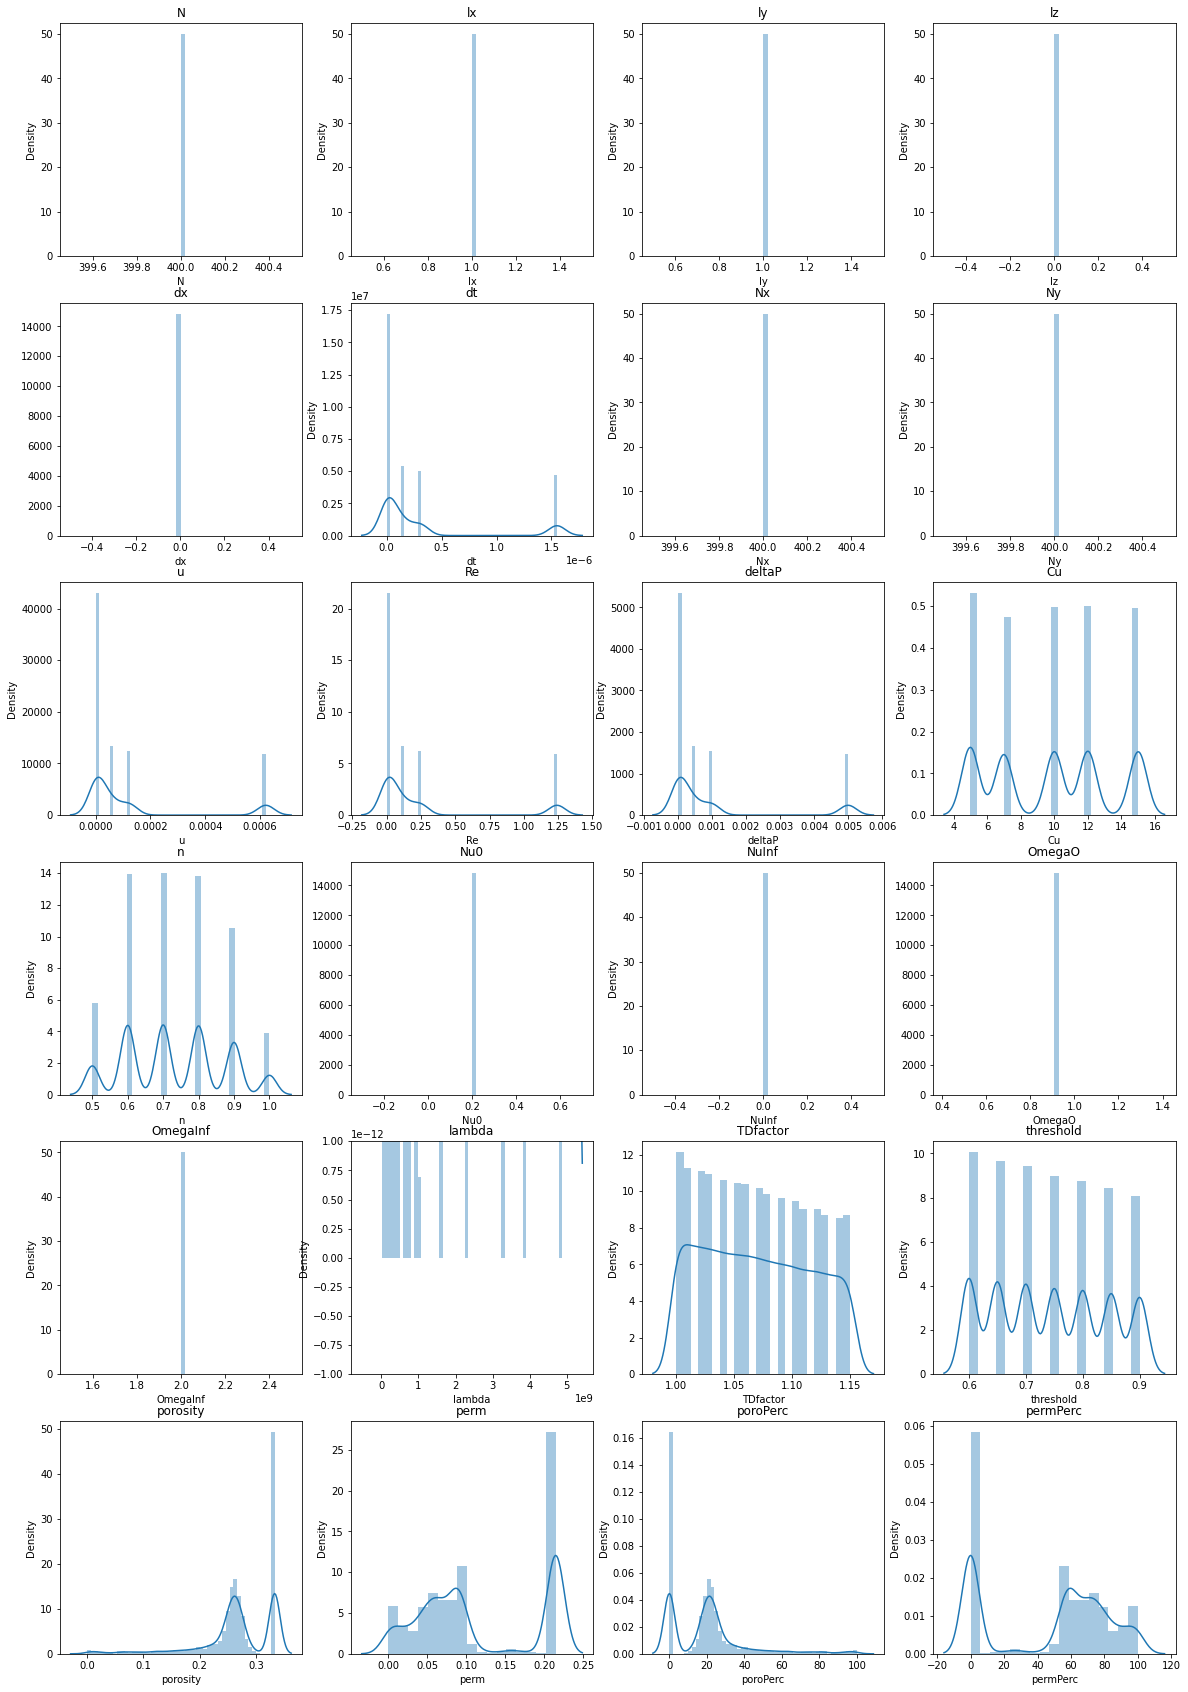

In [ ]:
f, ax = plt.subplots(6,4,figsize=(20,30))
#simulation setup
ax=plt.subplot(6,4, 1)
sns.distplot(Berea_5['N'])
ax.set_title('N')

ax=plt.subplot(6,4, 2)
sns.distplot(Berea_5['lx'])
ax.set_title('lx')

ax=plt.subplot(6,4, 3)
sns.distplot(Berea_5['ly'])
ax.set_title('ly')

ax=plt.subplot(6,4, 4)
sns.distplot(Berea_5['lz'])
ax.set_title('lz')

ax=plt.subplot(6,4, 5)
sns.distplot(Berea_5['dx'], kde=False)
ax.set_title('dx')

ax=plt.subplot(6,4, 6)
sns.distplot(Berea_5['dt'])
ax.set_title('dt')

ax=plt.subplot(6,4, 7)
sns.distplot(Berea_5['Nx'])
ax.set_title('Nx')

ax=plt.subplot(6,4, 8)
sns.distplot(Berea_5['Ny'])
ax.set_title('Ny')

#Porous media setup
ax=plt.subplot(6,4, 9)
sns.distplot(Berea_5['u'])
ax.set_title('u')

ax=plt.subplot(6,4, 10)
sns.distplot(Berea_5['Re'])
ax.set_title('Re')

ax=plt.subplot(6,4, 11)
sns.distplot(Berea_5['deltaP'])
ax.set_title('deltaP')

# Carreu fluid flow setup
ax=plt.subplot(6,4, 12)
sns.distplot(Berea_5['Cu'])
ax.set_title('Cu')

ax=plt.subplot(6,4, 13)
sns.distplot(Berea_5['n'])
ax.set_title('n')

ax=plt.subplot(6,4, 14)
sns.distplot(Berea_5['Nu0'], kde=False)
ax.set_title('Nu0')

ax=plt.subplot(6,4, 15)
sns.distplot(Berea_5['NuInf'])
ax.set_title('NuInf')

ax=plt.subplot(6,4, 16)
sns.distplot(Berea_5['OmegaO'], kde=False)
ax.set_title('OmegaO')

ax=plt.subplot(6,4, 17)
sns.distplot(Berea_5['OmegaInf'])
ax.set_title('OmegaInf')

ax=plt.subplot(6,4, 18)
sns.distplot(Berea_5['lambda'])
ax.set_title('lambda')

ax=plt.subplot(6,4, 19)
sns.distplot(Berea_5['TDfactor'])
ax.set_title('TDfactor')

ax=plt.subplot(6,4, 20)
sns.distplot(Berea_5['threshold'])
ax.set_title('threshold')

#Results
ax=plt.subplot(6,4, 21)
sns.distplot(Berea_5[ 'porosity'])
ax.set_title( 'porosity')

ax=plt.subplot(6,4, 22)
sns.distplot(Berea_5['perm'])
ax.set_title('perm')

ax=plt.subplot(6,4, 23)
sns.distplot(Berea_5['poroPerc'])
ax.set_title( 'poroPerc')

ax=plt.subplot(6,4, 24)
sns.distplot(Berea_5['permPerc'])
ax.set_title('permPerc')


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarnin

Text(0.5, 1.0, 'permPerc')

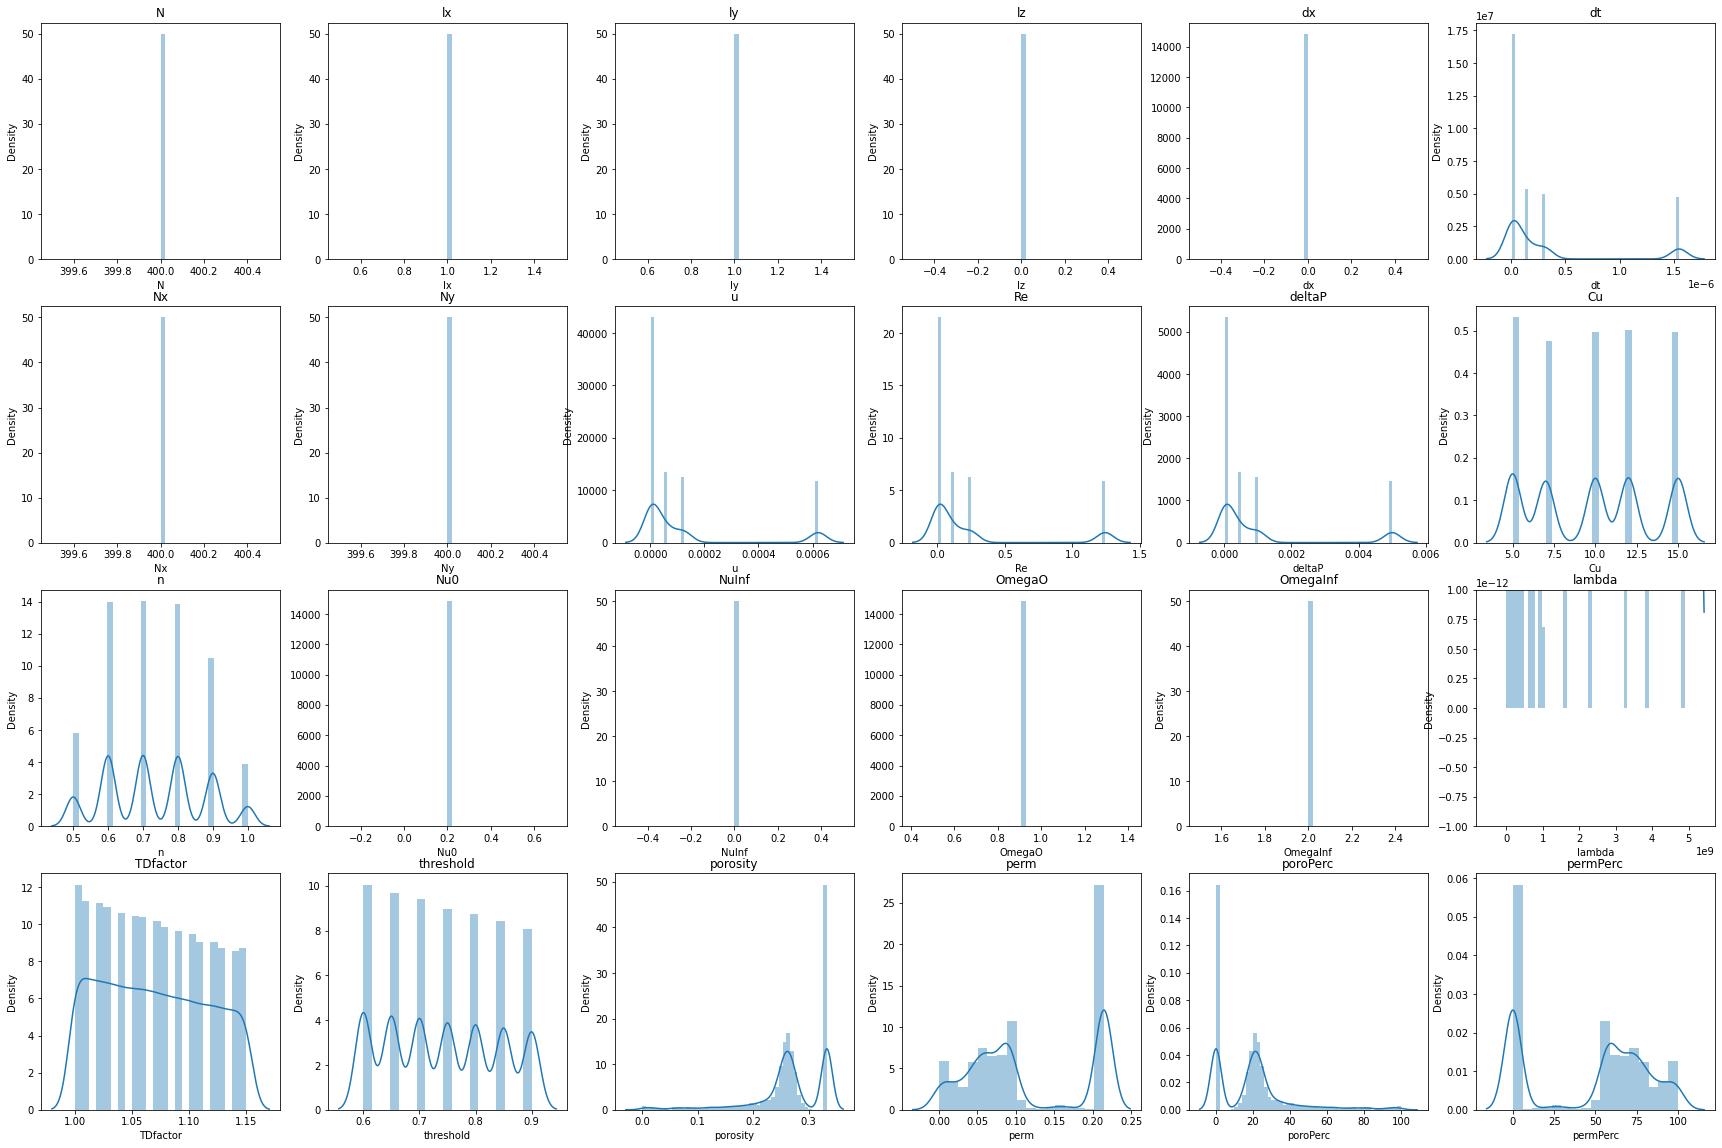

In [ ]:
f, ax = plt.subplots(4,6,figsize=(30,20))
#simulation setup
ax=plt.subplot(4,6, 1)
sns.distplot(Berea_5['N'])
ax.set_title('N')

ax=plt.subplot(4,6, 2)
sns.distplot(Berea_5['lx'])
ax.set_title('lx')

ax=plt.subplot(4,6, 3)
sns.distplot(Berea_5['ly'])
ax.set_title('ly')

ax=plt.subplot(4,6, 4)
sns.distplot(Berea_5['lz'])
ax.set_title('lz')

ax=plt.subplot(4,6, 5)
sns.distplot(Berea_5['dx'], kde=False)
ax.set_title('dx')

ax=plt.subplot(4,6, 6)
sns.distplot(Berea_5['dt'])
ax.set_title('dt')

ax=plt.subplot(4,6, 7)
sns.distplot(Berea_5['Nx'])
ax.set_title('Nx')

ax=plt.subplot(4,6, 8)
sns.distplot(Berea_5['Ny'])
ax.set_title('Ny')

#Porous media setup
ax=plt.subplot(4,6, 9)
sns.distplot(Berea_5['u'])
ax.set_title('u')

ax=plt.subplot(4,6, 10)
sns.distplot(Berea_5['Re'])
ax.set_title('Re')

ax=plt.subplot(4,6, 11)
sns.distplot(Berea_5['deltaP'])
ax.set_title('deltaP')

# Carreu fluid flow setup
ax=plt.subplot(4,6, 12)
sns.distplot(Berea_5['Cu'])
ax.set_title('Cu')

ax=plt.subplot(4,6, 13)
sns.distplot(Berea_5['n'])
ax.set_title('n')

ax=plt.subplot(4,6, 14)
sns.distplot(Berea_5['Nu0'], kde=False)
ax.set_title('Nu0')

ax=plt.subplot(4,6, 15)
sns.distplot(Berea_5['NuInf'])
ax.set_title('NuInf')

ax=plt.subplot(4,6, 16)
sns.distplot(Berea_5['OmegaO'], kde=False)
ax.set_title('OmegaO')

ax=plt.subplot(4,6, 17)
sns.distplot(Berea_5['OmegaInf'])
ax.set_title('OmegaInf')

ax=plt.subplot(4,6, 18)
sns.distplot(Berea_5['lambda'])
ax.set_title('lambda')

ax=plt.subplot(4,6, 19)
sns.distplot(Berea_5['TDfactor'])
ax.set_title('TDfactor')

ax=plt.subplot(4,6, 20)
sns.distplot(Berea_5['threshold'])
ax.set_title('threshold')

#Results
ax=plt.subplot(4,6, 21)
sns.distplot(Berea_5[ 'porosity'])
ax.set_title( 'porosity')

ax=plt.subplot(4,6, 22)
sns.distplot(Berea_5['perm'])
ax.set_title('perm')

ax=plt.subplot(4,6, 23)
sns.distplot(Berea_5['poroPerc'])
ax.set_title( 'poroPerc')

ax=plt.subplot(4,6, 24)
sns.distplot(Berea_5['permPerc'])
ax.set_title('permPerc')


It seems some columns contains constant value for all simulations. SO, we drop them

In [ ]:
Berea_5.columns

Index(['N', 'lx', 'ly', 'lz', 'dx', 'dt', 'Nx', 'Ny', 'u', 'Re', 'deltaP',
       'Cu', 'n', 'Nu0', 'NuInf', 'OmegaO', 'OmegaInf', 'lambda', 'TDfactor',
       'threshold', 'porosity', 'perm', 'poroPerc', 'permPerc'],
      dtype='object')

In [ ]:
Berea_6=Berea_5.drop([ 'N', 'lx', 'ly', 'lz', 'dx', 'Nx', 'Ny','Nu0', 'NuInf', 'OmegaO', 'OmegaInf'],axis=1)

In [ ]:
Berea_6.shape

(14847, 13)

###Linear correlation

In [ ]:
#sns.pairplot(Berea_6)

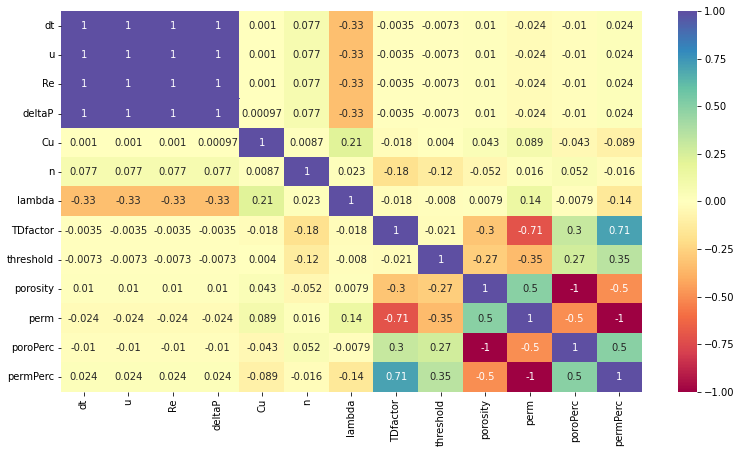

In [ ]:
plt.figure(figsize=(13,7))
sns.heatmap(Berea_6.corr(),cmap="Spectral",annot=True)

It seems some parameters which have perfect correlation with each other and we can drop them and keep just one of them

In [ ]:
Berea_6.columns

Index(['dt', 'u', 'Re', 'deltaP', 'Cu', 'n', 'lambda', 'TDfactor', 'threshold',
       'porosity', 'perm', 'poroPerc', 'permPerc'],
      dtype='object')

In [ ]:
Berea_7=Berea_6.drop(['dt', 'u', 'Re','porosity', 'perm'],axis=1)

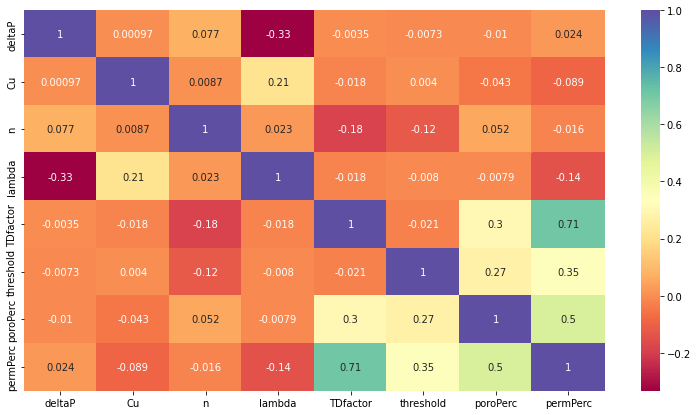

In [ ]:
plt.figure(figsize=(13,7))
sns.heatmap(Berea_7.corr(),cmap="Spectral",annot=True)

In [ ]:
100*Berea_7.isnull().sum()/len(Berea_7)

deltaP       0.0
Cu           0.0
n            0.0
lambda       0.0
TDfactor     0.0
threshold    0.0
poroPerc     0.0
permPerc     0.0
dtype: float64

#sampling- 1st


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


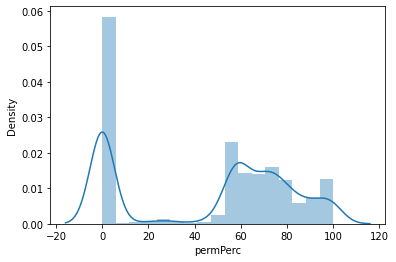

In [ ]:
sns.distplot(Berea_7['permPerc'])

The disturbution plot for permPerc which we want to predict with ANN shows extremely unbalanced data. So in this section we are going to make a balanced dataset which could be used for prediction 

## Version 1 sampling

###Version1 Preparation

In [ ]:
perm_0_005 = Berea_7[np.logical_and(Berea_7['permPerc'] >-1, Berea_7['permPerc'] <= 5)]
perm_005_01 = Berea_7[np.logical_and(Berea_7['permPerc'] >5, Berea_7['permPerc'] <= 10)]
perm_01_015= Berea_7[np.logical_and(Berea_7['permPerc'] >10, Berea_7['permPerc'] <= 15)]
perm_015_02 = Berea_7[np.logical_and(Berea_7['permPerc'] >15, Berea_7['permPerc'] <= 20)]
perm_02_025= Berea_7[np.logical_and(Berea_7['permPerc'] >20, Berea_7['permPerc'] <= 25)]
perm_025_03 = Berea_7[np.logical_and(Berea_7['permPerc'] >25, Berea_7['permPerc'] <= 30)]
perm_03_035= Berea_7[np.logical_and(Berea_7['permPerc'] >30, Berea_7['permPerc'] <= 35)]
perm_035_04 = Berea_7[np.logical_and(Berea_7['permPerc'] >35, Berea_7['permPerc'] <= 40)]
perm_04_045= Berea_7[np.logical_and(Berea_7['permPerc'] >40, Berea_7['permPerc'] <= 45)]
perm_045_05 = Berea_7[np.logical_and(Berea_7['permPerc'] >45, Berea_7['permPerc'] <= 50)]
perm_05_055= Berea_7[np.logical_and(Berea_7['permPerc'] >50, Berea_7['permPerc'] <= 55)]
perm_055_06 = Berea_7[np.logical_and(Berea_7['permPerc'] >55, Berea_7['permPerc'] <= 60)]
perm_06_065= Berea_7[np.logical_and(Berea_7['permPerc'] >60, Berea_7['permPerc'] <= 65)]
perm_065_07 = Berea_7[np.logical_and(Berea_7['permPerc'] >65, Berea_7['permPerc'] <=70)]
perm_07_075= Berea_7[np.logical_and(Berea_7['permPerc'] >70, Berea_7['permPerc'] <= 75)]
perm_075_08 = Berea_7[np.logical_and(Berea_7['permPerc'] >75, Berea_7['permPerc'] <= 80)]
perm_08_085= Berea_7[np.logical_and(Berea_7['permPerc'] >80, Berea_7['permPerc'] <= 85)]
perm_085_09 = Berea_7[np.logical_and(Berea_7['permPerc'] >85, Berea_7['permPerc'] <= 90)]
perm_09_095= Berea_7[np.logical_and(Berea_7['permPerc'] >90, Berea_7['permPerc'] <= 95)]
perm_095_1 = Berea_7[np.logical_and(Berea_7['permPerc'] >95, Berea_7['permPerc'] <= 100)]

In [ ]:
class_count=[len(perm_0_005),len(perm_005_01),len(perm_01_015),len(perm_015_02),len(perm_02_025),len(perm_025_03),len(perm_03_035),
             len(perm_035_04),len(perm_04_045),len(perm_045_05),len(perm_05_055),len(perm_055_06),len(perm_06_065),len(perm_065_07),
             len(perm_07_075),len(perm_075_08),len(perm_08_085),len(perm_085_09),len(perm_09_095),len(perm_095_1)]

In [ ]:
class_count

[5093,
 4,
 29,
 36,
 49,
 97,
 33,
 17,
 43,
 105,
 175,
 2448,
 780,
 1068,
 1275,
 999,
 579,
 542,
 428,
 1047]

In [ ]:
np.median(class_count)

301.5

For balancing the data, we choose combination of undersampling and oversampling. for the first model, we selected 200 samples from each class

In [ ]:
perm_0_005_sample1=	perm_0_005.sample(200,replace='True')
perm_005_01_sample1=perm_005_01.sample(200,replace='True')
perm_01_015_sample1=	perm_01_015.sample(200,replace='True')
perm_015_02_sample1=	perm_015_02.sample(200,replace='True')
perm_02_025_sample1=	perm_02_025.sample(200,replace='True')
perm_025_03_sample1=	perm_025_03.sample(200,replace='True')
perm_03_035_sample1=	perm_03_035.sample(200,replace='True')
perm_035_04_sample1=	perm_035_04.sample(200,replace='True')
perm_04_045_sample1=	perm_04_045.sample(200,replace='True')
perm_045_05_sample1=	perm_045_05.sample(200,replace='True')
perm_05_055_sample1=	perm_05_055.sample(200,replace='True')
perm_055_06_sample1=	perm_055_06.sample(200,replace='True')
perm_06_065_sample1=	perm_06_065.sample(200,replace='True')
perm_065_07_sample1=	perm_065_07.sample(200,replace='True')
perm_07_075_sample1=	perm_07_075.sample(200,replace='True')
perm_075_08_sample1=	perm_075_08.sample(200,replace='True')
perm_08_085_sample1=	perm_08_085.sample(200,replace='True')
perm_085_09_sample1=	perm_085_09.sample(200,replace='True')
perm_09_095_sample1=	perm_09_095.sample(200,replace='True')
perm_095_1_sample1=	perm_095_1.sample(200,replace='True')


In [ ]:
Berea_balanced_1=pd.concat([perm_0_005_sample1,
perm_005_01_sample1,
perm_01_015_sample1,
perm_015_02_sample1,
perm_02_025_sample1,
perm_025_03_sample1,
perm_03_035_sample1,
perm_035_04_sample1,
perm_04_045_sample1,
perm_045_05_sample1,
perm_05_055_sample1,
perm_055_06_sample1,
perm_06_065_sample1,
perm_065_07_sample1,
perm_07_075_sample1,
perm_075_08_sample1,
perm_08_085_sample1,
perm_085_09_sample1,
perm_09_095_sample1,
perm_095_1_sample1,
] ,axis=0)

In [ ]:
Berea_balanced_1.shape

(4000, 8)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


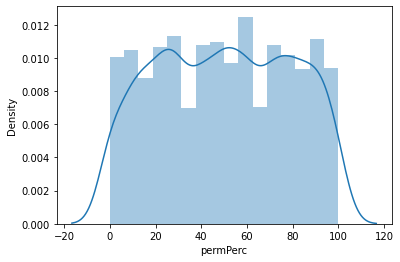

In [ ]:
sns.distplot(Berea_balanced_1['permPerc'])

#Feature Selectiion

##Forward Selection

###1-TD factor

Since the feature selection and hyperparameters optimization parts are the next steps, for know we select all the features for training and also, we choose 4 hidden layers with 19 neuron in each of them fo evaluationg the performance of ANN on the balanced dataset

####import libraries

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

####training the model

In [ ]:

X = Berea_balanced_1.drop([ 'threshold','lambda','deltaP','n','Cu','poroPerc','permPerc',],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_balanced_1['permPerc']

In [ ]:
X_train_01, X_test_01, y_train_01, y_test_01 = train_test_split(X,y,test_size=0.3,random_state=101)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_01= scaler.fit_transform(X_train_01)

In [ ]:
X_test_01= scaler.transform(X_test_01)

In [ ]:
X_train_01.shape

(2800, 1)

In [ ]:
model_01 = Sequential()

model_01.add(Dense(19,activation='relu'))
model_01.add(Dense(19,activation='relu'))
model_01.add(Dense(19,activation='relu'))
model_01.add(Dense(19,activation='relu'))
model_01.add(Dense(19,activation='relu'))
model_01.add(Dense(19,activation='relu'))
model_01.add(Dense(19,activation='relu'))
model_01.add(Dense(1))

model_01.compile(optimizer='adam',loss='mse')

In [ ]:
model_01.fit(x=X_train_01,y=y_train_01.values,
          validation_data=(X_test_01,y_test_01.values),
          batch_size=128,epochs=400)

Epoch 1/400
22/22 [==============================] - 1s 11ms/step - loss: 3302.2407 - val_loss: 3372.8601
Epoch 2/400
22/22 [==============================] - 0s 4ms/step - loss: 3219.5256 - val_loss: 3216.2930
Epoch 3/400
22/22 [==============================] - 0s 5ms/step - loss: 2897.2908 - val_loss: 2589.4326
Epoch 4/400
22/22 [==============================] - 0s 4ms/step - loss: 1779.6991 - val_loss: 900.9987
Epoch 5/400
22/22 [==============================] - 0s 4ms/step - loss: 636.2166 - val_loss: 615.6986
Epoch 6/400
22/22 [==============================] - 0s 5ms/step - loss: 571.5275 - val_loss: 610.6624
Epoch 7/400
22/22 [==============================] - 0s 4ms/step - loss: 563.0434 - val_loss: 608.3055
Epoch 8/400
22/22 [==============================] - 0s 4ms/step - loss: 561.5511 - val_loss: 605.8597
Epoch 9/400
22/22 [==============================] - 0s 5ms/step - loss: 558.3257 - val_loss: 604.3235
Epoch 10/400
22/22 [==============================] - 0s 5ms/step

####evaluation

In [ ]:
losses_01 = pd.DataFrame(model_01.history.history)

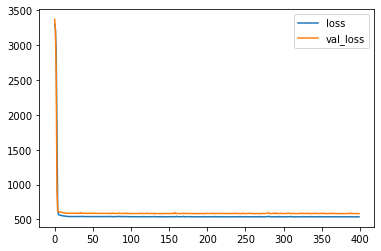

In [ ]:
losses_01.plot()

In [ ]:
predictions_01 = model_01.predict(X_test_01)

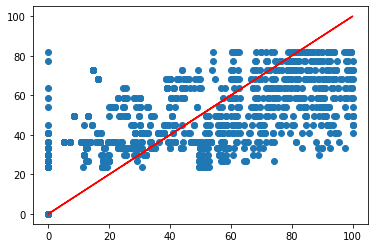

In [ ]:
# Our predictions
plt.scatter(y_test_01,predictions_01)

# Perfect predictions
plt.plot(y_test_01,y_test_01,'r')

In [ ]:
errors_01 = y_test_01.values.reshape(1200, 1) - predictions_01

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


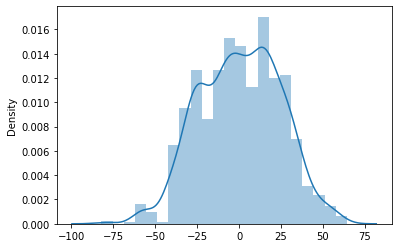

In [ ]:
sns.distplot(errors_01)

###2-TD factor  , threshold,

Since the feature selection and hyperparameters optimization parts are the next steps, for know we select all the features for training and also, we choose 4 hidden layers with 19 neuron in each of them fo evaluationg the performance of ANN on the balanced dataset

####import libraries

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

####training the model

In [ ]:

X = Berea_balanced_1.drop(['lambda','deltaP','n','Cu','poroPerc','permPerc',],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_balanced_1['permPerc']

In [ ]:
X_train_02, X_test_02, y_train_02, y_test_02 = train_test_split(X,y,test_size=0.3,random_state=101)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_02= scaler.fit_transform(X_train_02)

In [ ]:
X_test_02= scaler.transform(X_test_02)

In [ ]:
X_train_02.shape

(2800, 2)

In [ ]:
model_02 = Sequential()

model_02.add(Dense(19,activation='relu'))
model_02.add(Dense(19,activation='relu'))
model_02.add(Dense(19,activation='relu'))
model_02.add(Dense(19,activation='relu'))
model_02.add(Dense(19,activation='relu'))
model_02.add(Dense(19,activation='relu'))
model_02.add(Dense(19,activation='relu'))
model_02.add(Dense(1))

model_02.compile(optimizer='adam',loss='mse')

In [ ]:
model_02.fit(x=X_train_02,y=y_train_02.values,
          validation_data=(X_test_02,y_test_02.values),
          batch_size=128,epochs=400)

Epoch 1/400
22/22 [==============================] - 1s 10ms/step - loss: 3318.4470 - val_loss: 3411.0007
Epoch 2/400
22/22 [==============================] - 0s 4ms/step - loss: 3304.8933 - val_loss: 3385.0049
Epoch 3/400
22/22 [==============================] - 0s 3ms/step - loss: 3245.6299 - val_loss: 3256.2229
Epoch 4/400
22/22 [==============================] - 0s 4ms/step - loss: 2926.1030 - val_loss: 2585.6328
Epoch 5/400
22/22 [==============================] - 0s 4ms/step - loss: 1655.1886 - val_loss: 694.7634
Epoch 6/400
22/22 [==============================] - 0s 4ms/step - loss: 580.4368 - val_loss: 579.3325
Epoch 7/400
22/22 [==============================] - 0s 4ms/step - loss: 526.0234 - val_loss: 551.7305
Epoch 8/400
22/22 [==============================] - 0s 4ms/step - loss: 497.8710 - val_loss: 530.0770
Epoch 9/400
22/22 [==============================] - 0s 4ms/step - loss: 476.9476 - val_loss: 509.8604
Epoch 10/400
22/22 [==============================] - 0s 4ms/st

####evaluation

In [ ]:
losses_02 = pd.DataFrame(model_02.history.history)

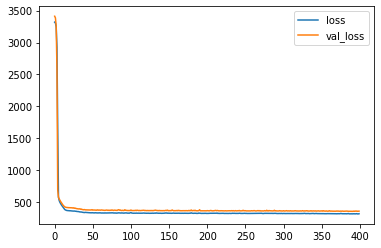

In [ ]:
losses_02.plot()

In [ ]:
predictions_02 = model_02.predict(X_test_02)

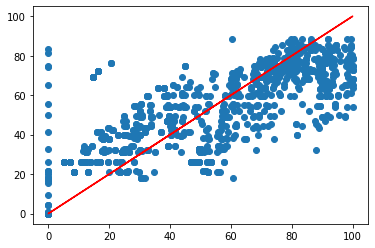

In [ ]:
# Our predictions
plt.scatter(y_test_02,predictions_02)

# Perfect predictions
plt.plot(y_test_02,y_test_02,'r')

In [ ]:
errors_02 = y_test_02.values.reshape(1200, 1) - predictions_02

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


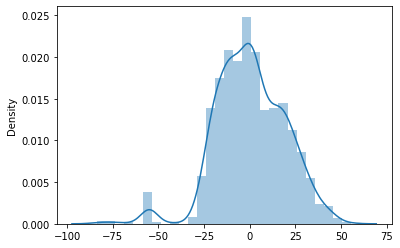

In [ ]:
sns.distplot(errors_02)

###3-TD factor  , threshold,lambda

Since the feature selection and hyperparameters optimization parts are the next steps, for know we select all the features for training and also, we choose 4 hidden layers with 19 neuron in each of them fo evaluationg the performance of ANN on the balanced dataset

####import libraries

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

####training the model

In [ ]:

X = Berea_balanced_1.drop(['deltaP','n','Cu','poroPerc','permPerc',],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_balanced_1['permPerc']

In [ ]:
X_train_03, X_test_03, y_train_03, y_test_03 = train_test_split(X,y,test_size=0.3,random_state=101)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_03= scaler.fit_transform(X_train_03)

In [ ]:
X_test_03= scaler.transform(X_test_03)

In [ ]:
X_train_03.shape

(2800, 3)

In [ ]:
model_03 = Sequential()

model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(1))

model_03.compile(optimizer='adam',loss='mse')

In [ ]:
model_03.fit(x=X_train_03,y=y_train_03.values,
          validation_data=(X_test_03,y_test_03.values),
          batch_size=128,epochs=400)

Epoch 1/400
22/22 [==============================] - 1s 11ms/step - loss: 3313.3464 - val_loss: 3392.6365
Epoch 2/400
22/22 [==============================] - 0s 5ms/step - loss: 3258.7217 - val_loss: 3280.3079
Epoch 3/400
22/22 [==============================] - 0s 4ms/step - loss: 2973.6438 - val_loss: 2646.7380
Epoch 4/400
22/22 [==============================] - 0s 4ms/step - loss: 1693.7064 - val_loss: 677.0881
Epoch 5/400
22/22 [==============================] - 0s 4ms/step - loss: 587.4950 - val_loss: 581.4513
Epoch 6/400
22/22 [==============================] - 0s 4ms/step - loss: 527.0132 - val_loss: 552.9511
Epoch 7/400
22/22 [==============================] - 0s 5ms/step - loss: 498.9200 - val_loss: 525.6085
Epoch 8/400
22/22 [==============================] - 0s 4ms/step - loss: 467.0794 - val_loss: 495.4399
Epoch 9/400
22/22 [==============================] - 0s 5ms/step - loss: 440.1922 - val_loss: 472.3410
Epoch 10/400
22/22 [==============================] - 0s 4ms/step

####evaluation

In [ ]:
losses_03 = pd.DataFrame(model_03.history.history)

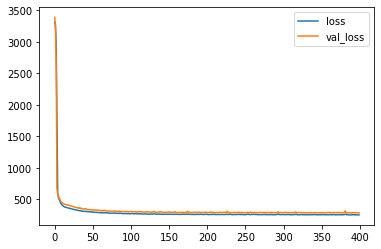

In [ ]:
losses_03.plot()

In [ ]:
predictions_03 = model_03.predict(X_test_03)

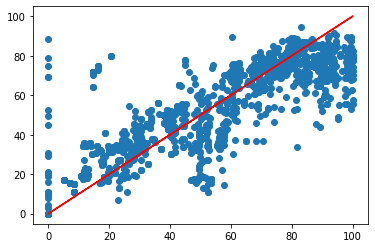

In [ ]:
# Our predictions
plt.scatter(y_test_03,predictions_03)

# Perfect predictions
plt.plot(y_test_03,y_test_03,'r')

In [ ]:
errors_03 = y_test_03.values.reshape(1200, 1) - predictions_02

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


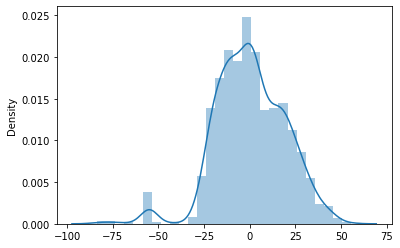

In [ ]:
sns.distplot(errors_03)

###4-TD factor  , threshold,lambda, deltaP

Since the feature selection and hyperparameters optimization parts are the next steps, for know we select all the features for training and also, we choose 4 hidden layers with 19 neuron in each of them fo evaluationg the performance of ANN on the balanced dataset

####import libraries

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

####training the model

In [ ]:

X = Berea_balanced_1.drop(['n','Cu','poroPerc','permPerc',],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_balanced_1['permPerc']

In [ ]:
X_train_04, X_test_04, y_train_04, y_test_04 = train_test_split(X,y,test_size=0.3,random_state=101)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_04= scaler.fit_transform(X_train_04)

In [ ]:
X_test_04= scaler.transform(X_test_04)

In [ ]:
X_train_04.shape

(2800, 4)

In [ ]:
model_04 = Sequential()

model_04.add(Dense(19,activation='relu'))
model_04.add(Dense(19,activation='relu'))
model_04.add(Dense(19,activation='relu'))
model_04.add(Dense(19,activation='relu'))
model_04.add(Dense(19,activation='relu'))
model_04.add(Dense(19,activation='relu'))
model_04.add(Dense(19,activation='relu'))
model_04.add(Dense(1))

model_04.compile(optimizer='adam',loss='mse')

In [ ]:
model_04.fit(x=X_train_04,y=y_train_04.values,
          validation_data=(X_test_04,y_test_04.values),
          batch_size=128,epochs=400)

Epoch 1/400
22/22 [==============================] - 1s 12ms/step - loss: 3310.0762 - val_loss: 3385.8484
Epoch 2/400
22/22 [==============================] - 0s 4ms/step - loss: 3225.6226 - val_loss: 3202.6228
Epoch 3/400
22/22 [==============================] - 0s 5ms/step - loss: 2815.8887 - val_loss: 2358.9360
Epoch 4/400
22/22 [==============================] - 0s 4ms/step - loss: 1376.1823 - val_loss: 653.6325
Epoch 5/400
22/22 [==============================] - 0s 5ms/step - loss: 641.1080 - val_loss: 654.3692
Epoch 6/400
22/22 [==============================] - 0s 4ms/step - loss: 573.5141 - val_loss: 597.0075
Epoch 7/400
22/22 [==============================] - 0s 4ms/step - loss: 534.9037 - val_loss: 564.7853
Epoch 8/400
22/22 [==============================] - 0s 4ms/step - loss: 497.3927 - val_loss: 527.7867
Epoch 9/400
22/22 [==============================] - 0s 5ms/step - loss: 462.4127 - val_loss: 492.1180
Epoch 10/400
22/22 [==============================] - 0s 5ms/step

####evaluation

In [ ]:
losses_04 = pd.DataFrame(model_04.history.history)

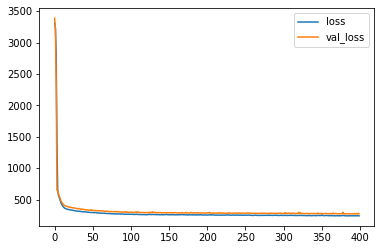

In [ ]:
losses_04.plot()

In [ ]:
predictions_04 = model_04.predict(X_test_04)

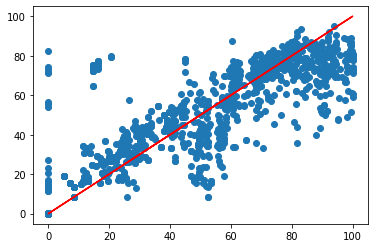

In [ ]:
# Our predictions
plt.scatter(y_test_04,predictions_04)

# Perfect predictions
plt.plot(y_test_04,y_test_04,'r')

In [ ]:
errors_04= y_test_04.values.reshape(1200, 1) - predictions_04

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


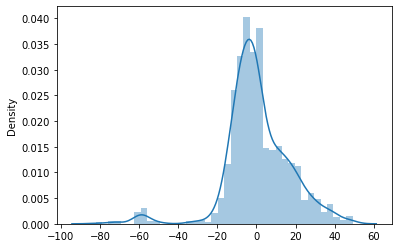

In [ ]:
sns.distplot(errors_04)

###5-TD factor  , threshold,lambda, deltaP, n

Since the feature selection and hyperparameters optimization parts are the next steps, for know we select all the features for training and also, we choose 4 hidden layers with 19 neuron in each of them fo evaluationg the performance of ANN on the balanced dataset

####import libraries

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

####training the model

In [ ]:

X = Berea_balanced_1.drop(['Cu','poroPerc','permPerc',],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_balanced_1['permPerc']

In [ ]:
X_train_05, X_test_05, y_train_05, y_test_05 = train_test_split(X,y,test_size=0.3,random_state=101)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_05= scaler.fit_transform(X_train_05)

In [ ]:
X_test_05= scaler.transform(X_test_05)

In [ ]:
X_train_05.shape

(2800, 5)

In [ ]:
model_05 = Sequential()

model_05.add(Dense(19,activation='relu'))
model_05.add(Dense(19,activation='relu'))
model_05.add(Dense(19,activation='relu'))
model_05.add(Dense(19,activation='relu'))
model_05.add(Dense(19,activation='relu'))
model_05.add(Dense(19,activation='relu'))
model_05.add(Dense(19,activation='relu'))
model_05.add(Dense(1))

model_05.compile(optimizer='adam',loss='mse')

In [ ]:
model_05.fit(x=X_train_05,y=y_train_05.values,
          validation_data=(X_test_05,y_test_05.values),
          batch_size=128,epochs=400)

Epoch 1/400
22/22 [==============================] - 1s 11ms/step - loss: 3307.8271 - val_loss: 3378.3562
Epoch 2/400
22/22 [==============================] - 0s 4ms/step - loss: 3221.1606 - val_loss: 3206.0122
Epoch 3/400
22/22 [==============================] - 0s 4ms/step - loss: 2845.2058 - val_loss: 2431.0972
Epoch 4/400
22/22 [==============================] - 0s 4ms/step - loss: 1461.3512 - val_loss: 633.4932
Epoch 5/400
22/22 [==============================] - 0s 4ms/step - loss: 624.9015 - val_loss: 607.5433
Epoch 6/400
22/22 [==============================] - 0s 4ms/step - loss: 542.9872 - val_loss: 545.2697
Epoch 7/400
22/22 [==============================] - 0s 4ms/step - loss: 481.1656 - val_loss: 479.9866
Epoch 8/400
22/22 [==============================] - 0s 4ms/step - loss: 410.4754 - val_loss: 402.5953
Epoch 9/400
22/22 [==============================] - 0s 4ms/step - loss: 335.7868 - val_loss: 335.3721
Epoch 10/400
22/22 [==============================] - 0s 4ms/step

####evaluation

In [ ]:
losses_05 = pd.DataFrame(model_05.history.history)

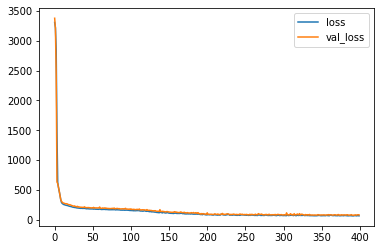

In [ ]:
losses_05.plot()

In [ ]:
predictions_05 = model_05.predict(X_test_05)

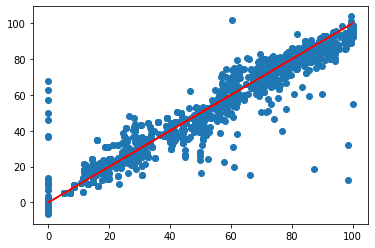

In [ ]:
# Our predictions
plt.scatter(y_test_05,predictions_05)

# Perfect predictions
plt.plot(y_test_05,y_test_05,'r')

In [ ]:
errors_05= y_test_05.values.reshape(1200, 1) - predictions_05

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


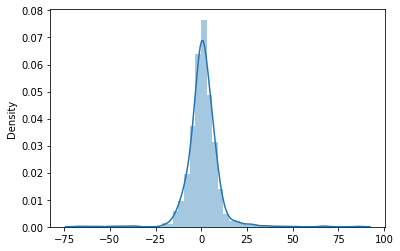

In [ ]:
sns.distplot(errors_05)

###6-TD factor  , threshold,lambda, deltaP, n,Cu

Since the feature selection and hyperparameters optimization parts are the next steps, for know we select all the features for training and also, we choose 4 hidden layers with 19 neuron in each of them fo evaluationg the performance of ANN on the balanced dataset

####import libraries

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

####training the model

In [ ]:

X = Berea_balanced_1.drop(['poroPerc','permPerc',],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_balanced_1['permPerc']

In [ ]:
X_train_06, X_test_06, y_train_06, y_test_06 = train_test_split(X,y,test_size=0.3,random_state=101)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_06= scaler.fit_transform(X_train_06)

In [ ]:
X_test_06= scaler.transform(X_test_06)

In [ ]:
X_train_06.shape

(2800, 6)

In [ ]:
model_06 = Sequential()

model_06.add(Dense(19,activation='relu'))
model_06.add(Dense(19,activation='relu'))
model_06.add(Dense(19,activation='relu'))
model_06.add(Dense(19,activation='relu'))
model_06.add(Dense(19,activation='relu'))
model_06.add(Dense(19,activation='relu'))
model_06.add(Dense(19,activation='relu'))
model_06.add(Dense(1))

model_06.compile(optimizer='adam',loss='mse')

In [ ]:
model_06.fit(x=X_train_06,y=y_train_06.values,
          validation_data=(X_test_06,y_test_06.values),
          batch_size=128,epochs=400)

Epoch 1/400
22/22 [==============================] - 1s 12ms/step - loss: 3285.9697 - val_loss: 3331.5095
Epoch 2/400
22/22 [==============================] - 0s 5ms/step - loss: 3109.4646 - val_loss: 2948.4255
Epoch 3/400
22/22 [==============================] - 0s 4ms/step - loss: 2265.7974 - val_loss: 1413.3904
Epoch 4/400
22/22 [==============================] - 0s 5ms/step - loss: 948.0439 - val_loss: 835.6733
Epoch 5/400
22/22 [==============================] - 0s 4ms/step - loss: 730.1931 - val_loss: 711.3677
Epoch 6/400
22/22 [==============================] - 0s 4ms/step - loss: 623.8660 - val_loss: 613.1592
Epoch 7/400
22/22 [==============================] - 0s 4ms/step - loss: 533.5937 - val_loss: 527.6948
Epoch 8/400
22/22 [==============================] - 0s 5ms/step - loss: 459.3983 - val_loss: 454.1002
Epoch 9/400
22/22 [==============================] - 0s 4ms/step - loss: 400.0444 - val_loss: 396.3336
Epoch 10/400
22/22 [==============================] - 0s 5ms/step 

####evaluation

In [ ]:
losses_06 = pd.DataFrame(model_06.history.history)

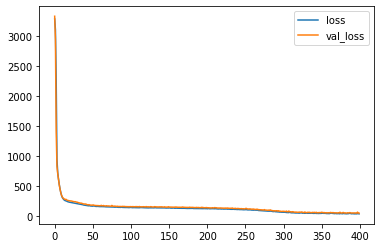

In [ ]:
losses_06.plot()

In [ ]:
predictions_06 = model_06.predict(X_test_06)

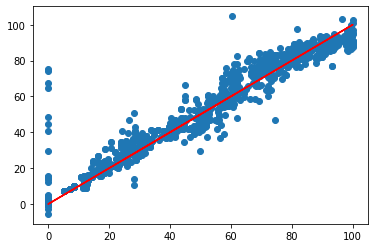

In [ ]:
# Our predictions
plt.scatter(y_test_06,predictions_06)

# Perfect predictions
plt.plot(y_test_06,y_test_06,'r')

In [ ]:
errors_06= y_test_06.values.reshape(1200, 1) - predictions_06

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


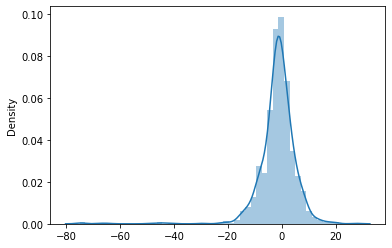

In [ ]:
sns.distplot(errors_06)

##Backward Elimination

###1- all params

Since the feature selection and hyperparameters optimization parts are the next steps, for know we select all the features for training and also, we choose 4 hidden layers with 19 neuron in each of them fo evaluationg the performance of ANN on the balanced dataset

####import libraries

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

####training the model

In [ ]:

X = Berea_balanced_1.drop(['poroPerc','permPerc',],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_balanced_1['permPerc']

In [ ]:
X_train_BW_01, X_test_BW_01, y_train_BW_01, y_test_BW_01 = train_test_split(X,y,test_size=0.3,random_state=101)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_BW_01= scaler.fit_transform(X_train_BW_01)

In [ ]:
X_test_BW_01= scaler.transform(X_test_BW_01)

In [ ]:
X_train_BW_01.shape

(2800, 6)

In [ ]:
model_BW_01 = Sequential()

model_BW_01.add(Dense(19,activation='relu'))
model_BW_01.add(Dense(19,activation='relu'))
model_BW_01.add(Dense(19,activation='relu'))
model_BW_01.add(Dense(19,activation='relu'))
model_BW_01.add(Dense(19,activation='relu'))
model_BW_01.add(Dense(19,activation='relu'))
model_BW_01.add(Dense(19,activation='relu'))
model_BW_01.add(Dense(1))

model_BW_01.compile(optimizer='adam',loss='mse')

In [ ]:
model_BW_01.fit(x=X_train_BW_01,y=y_train_BW_01.values,
          validation_data=(X_test_BW_01,y_test_BW_01.values),
          batch_size=128,epochs=400)

Epoch 1/400
22/22 [==============================] - 1s 11ms/step - loss: 3300.6821 - val_loss: 3361.4326
Epoch 2/400
22/22 [==============================] - 0s 4ms/step - loss: 3171.6611 - val_loss: 3073.4639
Epoch 3/400
22/22 [==============================] - 0s 4ms/step - loss: 2462.6387 - val_loss: 1634.4331
Epoch 4/400
22/22 [==============================] - 0s 4ms/step - loss: 947.3675 - val_loss: 773.2537
Epoch 5/400
22/22 [==============================] - 0s 4ms/step - loss: 662.5326 - val_loss: 620.9175
Epoch 6/400
22/22 [==============================] - 0s 5ms/step - loss: 535.8887 - val_loss: 514.1809
Epoch 7/400
22/22 [==============================] - 0s 5ms/step - loss: 434.0303 - val_loss: 420.8157
Epoch 8/400
22/22 [==============================] - 0s 5ms/step - loss: 355.1517 - val_loss: 353.9407
Epoch 9/400
22/22 [==============================] - 0s 3ms/step - loss: 304.7428 - val_loss: 318.9522
Epoch 10/400
22/22 [==============================] - 0s 4ms/step 

####evaluation

In [ ]:
losses_BW_01 = pd.DataFrame(model_BW_01.history.history)

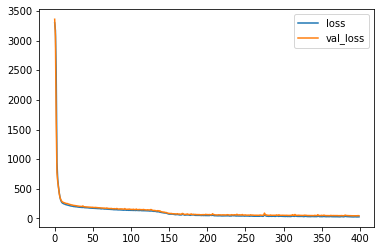

In [ ]:
losses_BW_01.plot()

In [ ]:
predictions_BW_01 = model_BW_01.predict(X_test_BW_01)

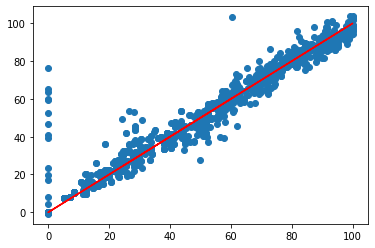

In [ ]:
# Our predictions
plt.scatter(y_test_BW_01,predictions_BW_01)

# Perfect predictions
plt.plot(y_test_BW_01,y_test_BW_01,'r')

In [ ]:
errors_BW_01= y_test_BW_01.values.reshape(1200, 1) - predictions_BW_01

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


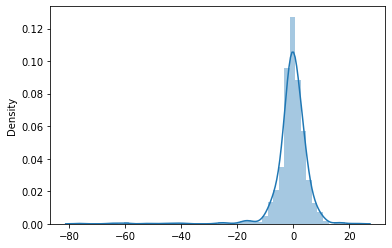

In [ ]:
sns.distplot(errors_BW_01)

###2- all params-TDfactor

Since the feature selection and hyperparameters optimization parts are the next steps, for know we select all the features for training and also, we choose 4 hidden layers with 19 neuron in each of them fo evaluationg the performance of ANN on the balanced dataset

####import libraries

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

####training the model

In [ ]:

X = Berea_balanced_1.drop(['TDfactor','poroPerc','permPerc',],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_balanced_1['permPerc']

In [ ]:
X_train_BW_02, X_test_BW_02, y_train_BW_02, y_test_BW_02 = train_test_split(X,y,test_size=0.3,random_state=101)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_BW_02= scaler.fit_transform(X_train_BW_02)

In [ ]:
X_test_BW_02= scaler.transform(X_test_BW_02)

In [ ]:
X_train_BW_02.shape

(2800, 5)

In [ ]:
model_BW_02 = Sequential()

model_BW_02.add(Dense(19,activation='relu'))
model_BW_02.add(Dense(19,activation='relu'))
model_BW_02.add(Dense(19,activation='relu'))
model_BW_02.add(Dense(19,activation='relu'))
model_BW_02.add(Dense(19,activation='relu'))
model_BW_02.add(Dense(19,activation='relu'))
model_BW_02.add(Dense(19,activation='relu'))
model_BW_02.add(Dense(1))

model_BW_02.compile(optimizer='adam',loss='mse')

In [ ]:
model_BW_02.fit(x=X_train_BW_02,y=y_train_BW_02.values,
          validation_data=(X_test_BW_02,y_test_BW_02.values),
          batch_size=128,epochs=400)

Epoch 1/400
22/22 [==============================] - 1s 12ms/step - loss: 3302.2756 - val_loss: 3368.7029
Epoch 2/400
22/22 [==============================] - 0s 4ms/step - loss: 3193.1985 - val_loss: 3129.6670
Epoch 3/400
22/22 [==============================] - 0s 4ms/step - loss: 2613.5151 - val_loss: 1883.8915
Epoch 4/400
22/22 [==============================] - 0s 4ms/step - loss: 1055.0178 - val_loss: 817.9756
Epoch 5/400
22/22 [==============================] - 0s 4ms/step - loss: 683.2163 - val_loss: 660.3603
Epoch 6/400
22/22 [==============================] - 0s 4ms/step - loss: 612.7814 - val_loss: 607.0063
Epoch 7/400
22/22 [==============================] - 0s 5ms/step - loss: 578.1810 - val_loss: 581.5971
Epoch 8/400
22/22 [==============================] - 0s 5ms/step - loss: 561.7571 - val_loss: 567.1071
Epoch 9/400
22/22 [==============================] - 0s 4ms/step - loss: 553.1307 - val_loss: 556.6146
Epoch 10/400
22/22 [==============================] - 0s 5ms/step

####evaluation

In [ ]:
losses_BW_02 = pd.DataFrame(model_BW_02.history.history)

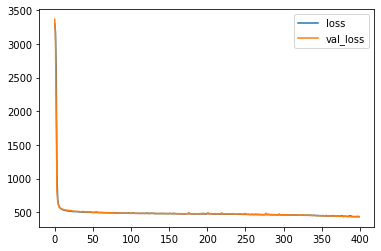

In [ ]:
losses_BW_02.plot()

In [ ]:
predictions_BW_02 = model_BW_02.predict(X_test_BW_02)

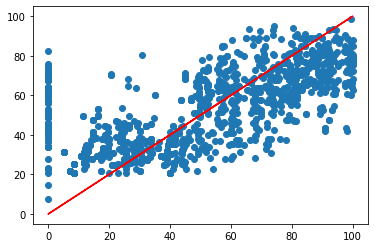

In [ ]:
# Our predictions
plt.scatter(y_test_BW_02,predictions_BW_02)

# Perfect predictions
plt.plot(y_test_BW_02,y_test_BW_02,'r')

In [ ]:
errors_BW_02= y_test_BW_02.values.reshape(1200, 1) - predictions_BW_02

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


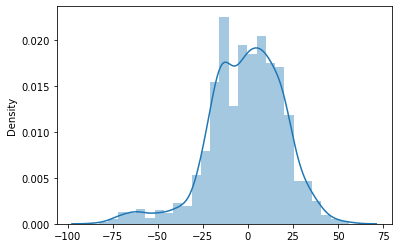

In [ ]:
sns.distplot(errors_BW_02)

###3- all params-TDfactor-threshold

Since the feature selection and hyperparameters optimization parts are the next steps, for know we select all the features for training and also, we choose 4 hidden layers with 19 neuron in each of them fo evaluationg the performance of ANN on the balanced dataset

####import libraries

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

####training the model

In [ ]:

X = Berea_balanced_1.drop(['TDfactor','poroPerc','permPerc','threshold'],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_balanced_1['permPerc']

In [ ]:
X_train_BW_03, X_test_BW_03, y_train_BW_03, y_test_BW_03 = train_test_split(X,y,test_size=0.3,random_state=101)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_BW_03= scaler.fit_transform(X_train_BW_03)

In [ ]:
X_test_BW_03= scaler.transform(X_test_BW_03)

In [ ]:
X_train_BW_03.shape

(2800, 4)

In [ ]:
model_BW_03 = Sequential()

model_BW_03.add(Dense(19,activation='relu'))
model_BW_03.add(Dense(19,activation='relu'))
model_BW_03.add(Dense(19,activation='relu'))
model_BW_03.add(Dense(19,activation='relu'))
model_BW_03.add(Dense(19,activation='relu'))
model_BW_03.add(Dense(19,activation='relu'))
model_BW_03.add(Dense(19,activation='relu'))
model_BW_03.add(Dense(1))

model_BW_03.compile(optimizer='adam',loss='mse')

In [ ]:
model_BW_03.fit(x=X_train_BW_03,y=y_train_BW_03.values,
          validation_data=(X_test_BW_03,y_test_BW_03.values),
          batch_size=128,epochs=400)

Epoch 1/400
22/22 [==============================] - 1s 13ms/step - loss: 3305.3882 - val_loss: 3375.9993
Epoch 2/400
22/22 [==============================] - 0s 5ms/step - loss: 3214.4700 - val_loss: 3182.0176
Epoch 3/400
22/22 [==============================] - 0s 5ms/step - loss: 2735.2727 - val_loss: 2137.7649
Epoch 4/400
22/22 [==============================] - 0s 4ms/step - loss: 1204.2509 - val_loss: 924.8286
Epoch 5/400
22/22 [==============================] - 0s 5ms/step - loss: 768.1819 - val_loss: 754.3233
Epoch 6/400
22/22 [==============================] - 0s 5ms/step - loss: 691.8183 - val_loss: 703.6298
Epoch 7/400
22/22 [==============================] - 0s 5ms/step - loss: 660.6896 - val_loss: 671.8326
Epoch 8/400
22/22 [==============================] - 0s 4ms/step - loss: 637.8440 - val_loss: 656.2892
Epoch 9/400
22/22 [==============================] - 0s 5ms/step - loss: 619.9310 - val_loss: 648.0494
Epoch 10/400
22/22 [==============================] - 0s 4ms/step

####evaluation

In [ ]:
losses_BW_03 = pd.DataFrame(model_BW_03.history.history)

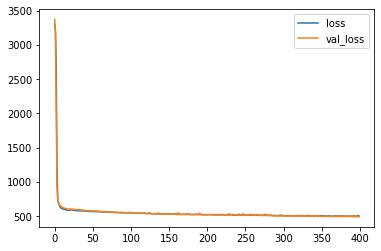

In [ ]:
losses_BW_03.plot()

In [ ]:
predictions_BW_03 = model_BW_03.predict(X_test_BW_03)

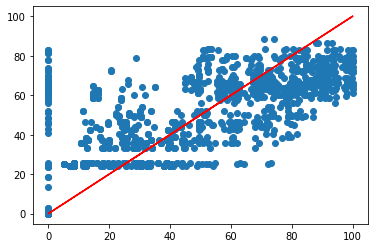

In [ ]:
# Our predictions
plt.scatter(y_test_BW_03,predictions_BW_03)

# Perfect predictions
plt.plot(y_test_BW_03,y_test_BW_03,'r')

In [ ]:
errors_BW_03= y_test_BW_03.values.reshape(1200, 1) - predictions_BW_03

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


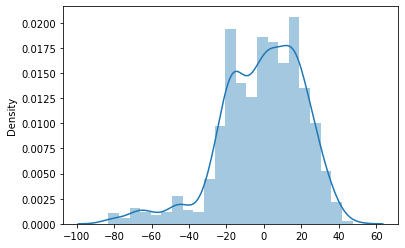

In [ ]:
sns.distplot(errors_BW_03)

###4- all params-TDfactor-threshold-lambda

Since the feature selection and hyperparameters optimization parts are the next steps, for know we select all the features for training and also, we choose 4 hidden layers with 19 neuron in each of them fo evaluationg the performance of ANN on the balanced dataset

####import libraries

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

####training the model

In [ ]:

X = Berea_balanced_1.drop(['TDfactor','poroPerc','permPerc','threshold','lambda'],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_balanced_1['permPerc']

In [ ]:
X_train_BW_04, X_test_BW_04, y_train_BW_04, y_test_BW_04 = train_test_split(X,y,test_size=0.3,random_state=101)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_BW_04= scaler.fit_transform(X_train_BW_04)

In [ ]:
X_test_BW_04= scaler.transform(X_test_BW_04)

In [ ]:
X_train_BW_04.shape

(2800, 3)

In [ ]:
model_BW_04 = Sequential()

model_BW_04.add(Dense(19,activation='relu'))
model_BW_04.add(Dense(19,activation='relu'))
model_BW_04.add(Dense(19,activation='relu'))
model_BW_04.add(Dense(19,activation='relu'))
model_BW_04.add(Dense(19,activation='relu'))
model_BW_04.add(Dense(19,activation='relu'))
model_BW_04.add(Dense(19,activation='relu'))
model_BW_04.add(Dense(1))

model_BW_04.compile(optimizer='adam',loss='mse')

In [ ]:
model_BW_04.fit(x=X_train_BW_04,y=y_train_BW_04.values,
          validation_data=(X_test_BW_04,y_test_BW_04.values),
          batch_size=128,epochs=400)

Epoch 1/400
22/22 [==============================] - 1s 11ms/step - loss: 3301.7344 - val_loss: 3370.4331
Epoch 2/400
22/22 [==============================] - 0s 5ms/step - loss: 3211.7139 - val_loss: 3186.2693
Epoch 3/400
22/22 [==============================] - 0s 4ms/step - loss: 2776.4448 - val_loss: 2268.1353
Epoch 4/400
22/22 [==============================] - 0s 5ms/step - loss: 1384.1907 - val_loss: 950.4911
Epoch 5/400
22/22 [==============================] - 0s 4ms/step - loss: 819.6493 - val_loss: 797.8533
Epoch 6/400
22/22 [==============================] - 0s 4ms/step - loss: 724.4153 - val_loss: 728.4430
Epoch 7/400
22/22 [==============================] - 0s 4ms/step - loss: 674.7837 - val_loss: 700.0362
Epoch 8/400
22/22 [==============================] - 0s 4ms/step - loss: 652.9918 - val_loss: 669.6817
Epoch 9/400
22/22 [==============================] - 0s 4ms/step - loss: 635.9843 - val_loss: 654.1624
Epoch 10/400
22/22 [==============================] - 0s 4ms/step

####evaluation

In [ ]:
losses_BW_04 = pd.DataFrame(model_BW_04.history.history)

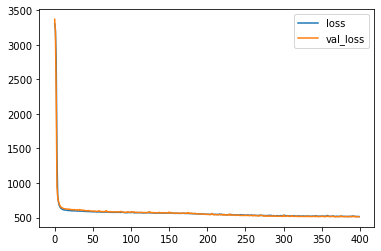

In [ ]:
losses_BW_04.plot()

In [ ]:
predictions_BW_04 = model_BW_04.predict(X_test_BW_04)

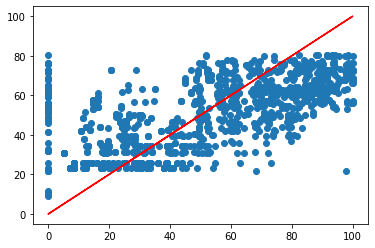

In [ ]:
# Our predictions
plt.scatter(y_test_BW_04,predictions_BW_04)

# Perfect predictions
plt.plot(y_test_BW_04,y_test_BW_04,'r')

In [ ]:
errors_BW_04= y_test_BW_04.values.reshape(1200, 1) - predictions_BW_04

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


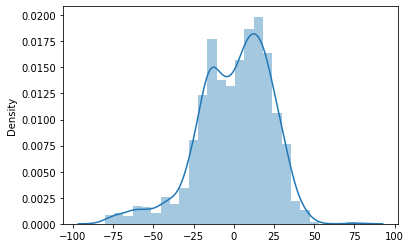

In [ ]:
sns.distplot(errors_BW_04)

###5- all params-TDfactor-threshold-lambda-deltaP

Since the feature selection and hyperparameters optimization parts are the next steps, for know we select all the features for training and also, we choose 4 hidden layers with 19 neuron in each of them fo evaluationg the performance of ANN on the balanced dataset

####import libraries

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

####training the model

In [ ]:

X = Berea_balanced_1.drop(['TDfactor','poroPerc','permPerc','threshold','lambda','deltaP'],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_balanced_1['permPerc']

In [ ]:
X_train_BW_05, X_test_BW_05, y_train_BW_05, y_test_BW_05 = train_test_split(X,y,test_size=0.3,random_state=101)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_BW_05= scaler.fit_transform(X_train_BW_05)

In [ ]:
X_test_BW_05= scaler.transform(X_test_BW_05)

In [ ]:
X_train_BW_05.shape

(2800, 2)

In [ ]:
model_BW_05 = Sequential()

model_BW_05.add(Dense(19,activation='relu'))
model_BW_05.add(Dense(19,activation='relu'))
model_BW_05.add(Dense(19,activation='relu'))
model_BW_05.add(Dense(19,activation='relu'))
model_BW_05.add(Dense(19,activation='relu'))
model_BW_05.add(Dense(19,activation='relu'))
model_BW_05.add(Dense(19,activation='relu'))
model_BW_05.add(Dense(1))

model_BW_05.compile(optimizer='adam',loss='mse')

In [ ]:
model_BW_05.fit(x=X_train_BW_05,y=y_train_BW_05.values,
          validation_data=(X_test_BW_05,y_test_BW_05.values),
          batch_size=128,epochs=400)

Epoch 1/400
22/22 [==============================] - 1s 11ms/step - loss: 3313.1121 - val_loss: 3396.3530
Epoch 2/400
22/22 [==============================] - 0s 4ms/step - loss: 3268.2268 - val_loss: 3303.3701
Epoch 3/400
22/22 [==============================] - 0s 6ms/step - loss: 3039.9204 - val_loss: 2776.1665
Epoch 4/400
22/22 [==============================] - 0s 5ms/step - loss: 1912.6000 - val_loss: 931.3813
Epoch 5/400
22/22 [==============================] - 0s 5ms/step - loss: 822.4750 - val_loss: 786.6036
Epoch 6/400
22/22 [==============================] - 0s 4ms/step - loss: 732.1490 - val_loss: 733.4518
Epoch 7/400
22/22 [==============================] - 0s 4ms/step - loss: 685.6720 - val_loss: 697.3082
Epoch 8/400
22/22 [==============================] - 0s 4ms/step - loss: 660.0724 - val_loss: 672.0092
Epoch 9/400
22/22 [==============================] - 0s 5ms/step - loss: 644.1838 - val_loss: 657.0399
Epoch 10/400
22/22 [==============================] - 0s 5ms/step

####evaluation

In [ ]:
losses_BW_05 = pd.DataFrame(model_BW_05.history.history)

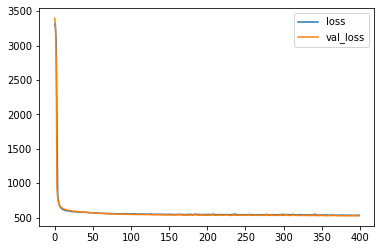

In [ ]:
losses_BW_05.plot()

In [ ]:
predictions_BW_05 = model_BW_05.predict(X_test_BW_05)

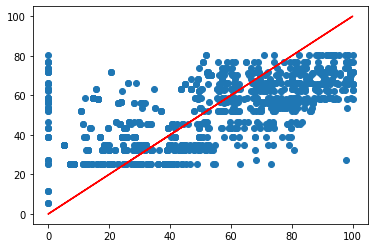

In [ ]:
# Our predictions
plt.scatter(y_test_BW_05,predictions_BW_05)

# Perfect predictions
plt.plot(y_test_BW_05,y_test_BW_05,'r')

In [ ]:
errors_BW_05= y_test_BW_05.values.reshape(1200, 1) - predictions_BW_05

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


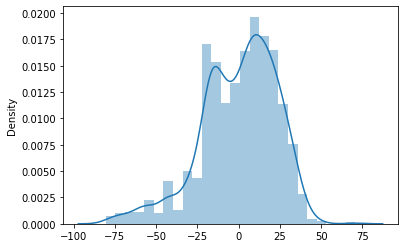

In [ ]:
sns.distplot(errors_BW_05)

###6- all params-TDfactor-threshold-lambda-deltaP-n

Since the feature selection and hyperparameters optimization parts are the next steps, for know we select all the features for training and also, we choose 4 hidden layers with 19 neuron in each of them fo evaluationg the performance of ANN on the balanced dataset

####import libraries

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

####training the model

In [ ]:

X = Berea_balanced_1.drop(['TDfactor','poroPerc','permPerc','threshold','lambda','deltaP','n'],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_balanced_1['permPerc']

In [ ]:
X_train_BW_06, X_test_BW_06, y_train_BW_06, y_test_BW_06 = train_test_split(X,y,test_size=0.3,random_state=101)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_BW_06= scaler.fit_transform(X_train_BW_06)

In [ ]:
X_test_BW_06= scaler.transform(X_test_BW_06)

In [ ]:
X_train_BW_06.shape

(2800, 1)

In [ ]:
model_BW_06 = Sequential()

model_BW_06.add(Dense(19,activation='relu'))
model_BW_06.add(Dense(19,activation='relu'))
model_BW_06.add(Dense(19,activation='relu'))
model_BW_06.add(Dense(19,activation='relu'))
model_BW_06.add(Dense(19,activation='relu'))
model_BW_06.add(Dense(19,activation='relu'))
model_BW_06.add(Dense(19,activation='relu'))
model_BW_06.add(Dense(1))

model_BW_06.compile(optimizer='adam',loss='mse')

In [ ]:
model_BW_06.fit(x=X_train_BW_06,y=y_train_BW_06.values,
          validation_data=(X_test_BW_06,y_test_BW_06.values),
          batch_size=128,epochs=400)

Epoch 1/400
22/22 [==============================] - 1s 11ms/step - loss: 3313.2837 - val_loss: 3397.7754
Epoch 2/400
22/22 [==============================] - 0s 4ms/step - loss: 3275.8853 - val_loss: 3328.1714
Epoch 3/400
22/22 [==============================] - 0s 4ms/step - loss: 3127.7754 - val_loss: 3031.0327
Epoch 4/400
22/22 [==============================] - 0s 4ms/step - loss: 2504.9253 - val_loss: 1883.6559
Epoch 5/400
22/22 [==============================] - 0s 4ms/step - loss: 1333.4940 - val_loss: 1247.3934
Epoch 6/400
22/22 [==============================] - 0s 4ms/step - loss: 1122.8005 - val_loss: 1141.0123
Epoch 7/400
22/22 [==============================] - 0s 4ms/step - loss: 1052.0579 - val_loss: 1085.1091
Epoch 8/400
22/22 [==============================] - 0s 4ms/step - loss: 1003.5864 - val_loss: 1038.5504
Epoch 9/400
22/22 [==============================] - 0s 4ms/step - loss: 959.7836 - val_loss: 992.6455
Epoch 10/400
22/22 [==============================] - 0s

####evaluation

In [ ]:
losses_BW_06 = pd.DataFrame(model_BW_06.history.history)

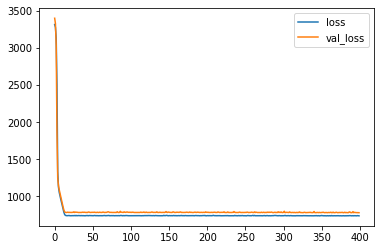

In [ ]:
losses_BW_06.plot()

In [ ]:
predictions_BW_06 = model_BW_06.predict(X_test_BW_06)

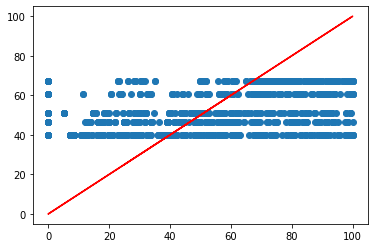

In [ ]:
# Our predictions
plt.scatter(y_test_BW_06,predictions_BW_06)

# Perfect predictions
plt.plot(y_test_BW_06,y_test_BW_06,'r')

In [ ]:
errors_BW_06= y_test_BW_06.values.reshape(1200, 1) - predictions_BW_06

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


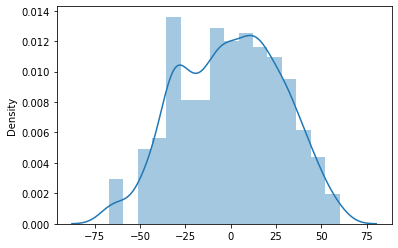

In [ ]:
sns.distplot(errors_BW_06)

#Report

##forward

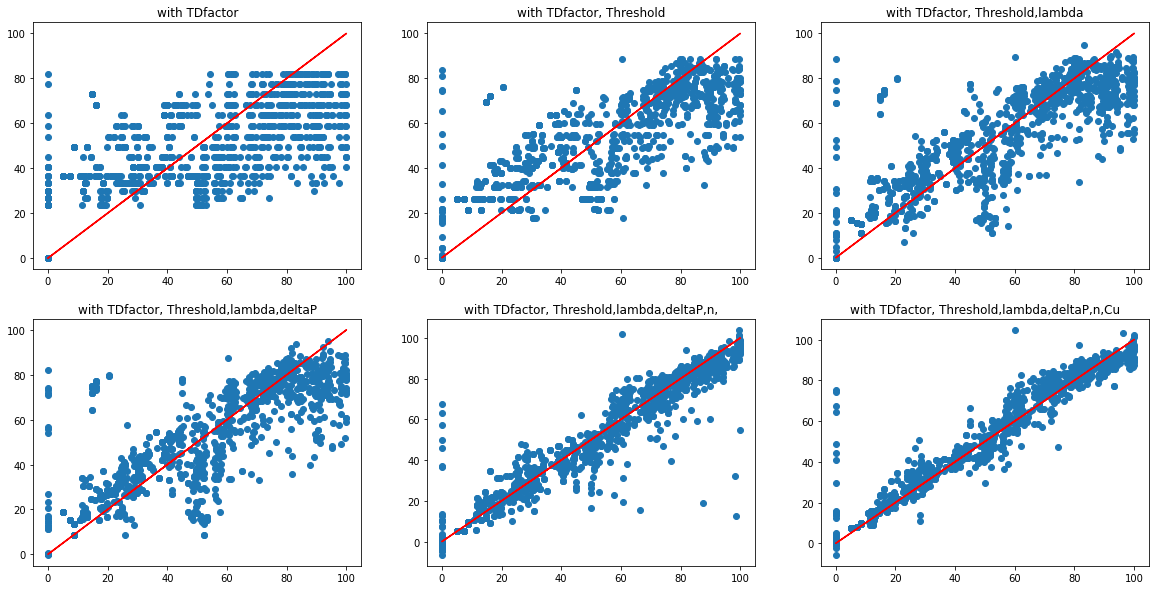

In [ ]:
f, ax = plt.subplots(2,3,figsize=(20,10))

ax=plt.subplot(2,3, 1)
plt.scatter(y_test_01,predictions_01)# Our predictions
cax=plt.plot(y_test_01,y_test_01,'r')# Perfect predictions
ax.set_title('with TDfactor')

ax=plt.subplot(2,3, 2)
plt.scatter(y_test_02,predictions_02)# Our predictions
cax=plt.plot(y_test_02,y_test_02,'r')# Perfect predictions
ax.set_title('with TDfactor, Threshold')

ax=plt.subplot(2,3, 3)
plt.scatter(y_test_03,predictions_03)# Our predictions
cax=plt.plot(y_test_03,y_test_03,'r')# Perfect predictions
ax.set_title('with TDfactor, Threshold,lambda')

ax=plt.subplot(2,3, 4)
plt.scatter(y_test_04,predictions_04)# Our predictions
cax=plt.plot(y_test_04,y_test_04,'r')# Perfect predictions
ax.set_title('with TDfactor, Threshold,lambda,deltaP')

ax=plt.subplot(2,3, 5)
plt.scatter(y_test_05,predictions_05)# Our predictions
cax=plt.plot(y_test_05,y_test_05,'r')# Perfect predictions
ax.set_title('with TDfactor, Threshold,lambda,deltaP,n,')

ax=plt.subplot(2,3, 6)
plt.scatter(y_test_06,predictions_06)# Our predictions
cax=plt.plot(y_test_06,y_test_06,'r')# Perfect predictions
ax.set_title('with TDfactor, Threshold,lambda,deltaP,n,Cu')

plt.show()

In [ ]:
MAE_FW=[mean_absolute_error(y_test_01,predictions_01),mean_absolute_error(y_test_02,predictions_02),mean_absolute_error(y_test_03,predictions_03),
        mean_absolute_error(y_test_04,predictions_04),mean_absolute_error(y_test_05,predictions_05),mean_absolute_error(y_test_06,predictions_06),]

In [ ]:
MAE_FW

[19.94450081061643,
 14.777218386823087,
 12.104098155293325,
 11.480985329714711,
 5.498442482590699,
 4.448152367578771]

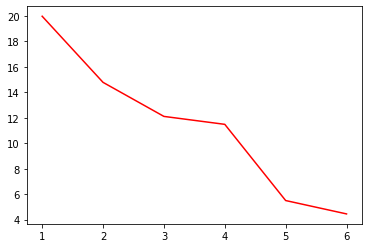

In [ ]:
plt.plot(range(1,7),MAE_FW,'r')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

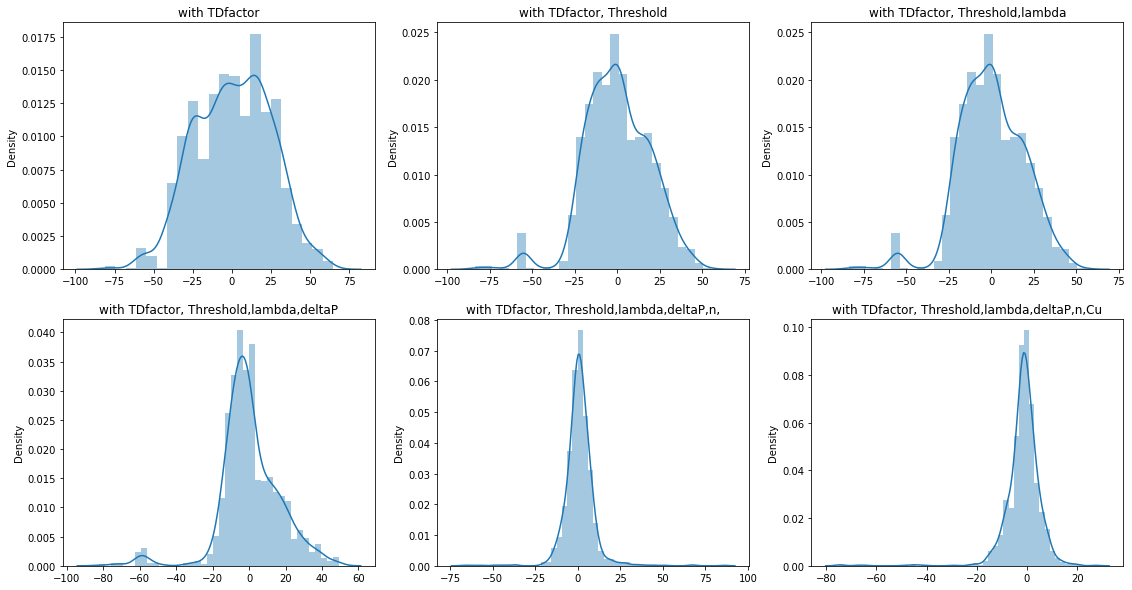

In [ ]:
f, ax = plt.subplots(2,3,figsize=(19,10))

ax=plt.subplot(2,3, 1)
sns.distplot(errors_01)
ax.set_title('with TDfactor')

ax=plt.subplot(2,3, 2)
sns.distplot(errors_02)
ax.set_title('with TDfactor, Threshold')

ax=plt.subplot(2,3, 3)
sns.distplot(errors_03)
ax.set_title('with TDfactor, Threshold,lambda')

ax=plt.subplot(2,3, 4)
sns.distplot(errors_04)
ax.set_title('with TDfactor, Threshold,lambda,deltaP')

ax=plt.subplot(2,3, 5)
sns.distplot(errors_05)
ax.set_title('with TDfactor, Threshold,lambda,deltaP,n,')

ax=plt.subplot(2,3, 6)
sns.distplot(errors_06)
ax.set_title('with TDfactor, Threshold,lambda,deltaP,n,Cu')

plt.show()

##backward

In [ ]:
f, ax = plt.subplots(2,3,figsize=(20,10))

ax=plt.subplot(2,3, 1)
plt.scatter(y_test_BW_01,predictions_BW_01)# Our predictions
cax=plt.plot(y_test_BW_01,y_test_BW_01,'r')# Perfect predictions
ax.set_title('without TDfactor')

ax=plt.subplot(2,3, 2)
plt.scatter(y_test_BW_02,predictions_BW_02)# Our predictions
cax=plt.plot(y_test_BW_02,y_test_BW_02,'r')# Perfect predictions
ax.set_title('without TDfactor, Threshold')

ax=plt.subplot(2,3, 3)
plt.scatter(y_test_BW_03,predictions_BW_03)# Our predictions
cax=plt.plot(y_test_BW_03,y_test_BW_03,'r')# Perfect predictions
ax.set_title('without TDfactor, Threshold,lambda')

ax=plt.subplot(2,3, 4)
plt.scatter(y_test_BW_04,predictions_BW_04)# Our predictions
cax=plt.plot(y_test_BW_04,y_test_BW_04,'r')# Perfect predictions
ax.set_title('without TDfactor, Threshold,lambda,deltaP')

ax=plt.subplot(2,3, 5)
plt.scatter(y_test_BW_05,predictions_BW_05)# Our predictions
cax=plt.plot(y_test_BW_05,y_test_BW_05,'r')# Perfect predictions
ax.set_title('without TDfactor, Threshold,lambda,deltaP,n,')

ax=plt.subplot(2,3, 6)
plt.scatter(y_test_BW_06,predictions_BW_06)# Our predictions
cax=plt.plot(y_test_BW_06,y_test_BW_06,'r')# Perfect predictions
ax.set_title('without TDfactor, Threshold,lambda,deltaP,n,Cu')

plt.show()

SyntaxError: ignored

In [ ]:
MAE_FW=[mean_absolute_error(y_test_BW_01,predictions_BW_01),mean_absolute_error(y_test_BW_02,predictions_BW_02),mean_absolute_error(y_test_BW_03,predictions_BW_03),
        mean_absolute_error(y_test_BW_04,predictions_BW_04),mean_absolute_error(y_test_BW_05,predictions_BW_05),mean_absolute_error(y_test_BW_06,predictions_BW_06),]

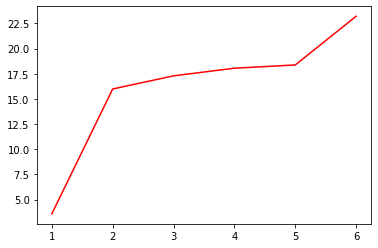

In [ ]:
plt.plot(range(1,7),MAE_FW,'r')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

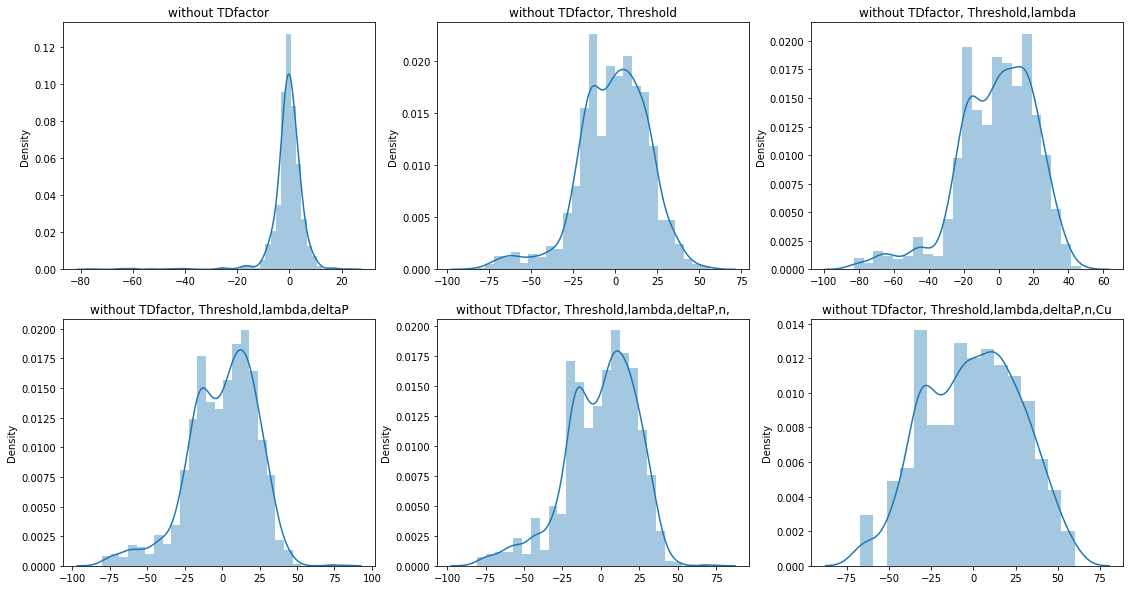

In [ ]:
f, ax = plt.subplots(2,3,figsize=(19,10))

ax=plt.subplot(2,3, 1)
sns.distplot(errors_BW_01)
ax.set_title('without TDfactor')

ax=plt.subplot(2,3, 2)
sns.distplot(errors_BW_02)
ax.set_title('without TDfactor, Threshold')

ax=plt.subplot(2,3, 3)
sns.distplot(errors_BW_03)
ax.set_title('without TDfactor, Threshold,lambda')

ax=plt.subplot(2,3, 4)
sns.distplot(errors_BW_04)
ax.set_title('without TDfactor, Threshold,lambda,deltaP')

ax=plt.subplot(2,3, 5)
sns.distplot(errors_BW_05)
ax.set_title('without TDfactor, Threshold,lambda,deltaP,n,')

ax=plt.subplot(2,3, 6)
sns.distplot(errors_BW_06)
ax.set_title('without TDfactor, Threshold,lambda,deltaP,n,Cu')

plt.show()

#HPO -1st

Although the result of model 7 for Berea-7 dataset looks fine, we could try to make it better by addding new neurons and hidden layers to the network.

## with 11 neurons in each layer

In [ ]:

X = Berea_7.drop(['poroPerc', 'permPerc'],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_7['permPerc']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)

####Scaling

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train= scaler.fit_transform(X_train)

In [ ]:
X_test= scaler.transform(X_test)

In [ ]:
X_train.shape

(10392, 6)

In [ ]:
X_test.shape

(4455, 6)

#### training and validation

In [ ]:
deep_model_1 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_1.add(Dense(11,activation='relu'))
deep_model_1.add(Dense(1))

deep_model_1.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_1.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
82/82 [==============================] - 1s 3ms/step - loss: 3494.4500 - val_loss: 3343.4263
Epoch 2/400
82/82 [==============================] - 0s 2ms/step - loss: 3417.4692 - val_loss: 3254.6841
Epoch 3/400
82/82 [==============================] - 0s 3ms/step - loss: 3305.2590 - val_loss: 3128.9460
Epoch 4/400
82/82 [==============================] - 0s 2ms/step - loss: 3161.9143 - val_loss: 2977.6030
Epoch 5/400
82/82 [==============================] - 0s 2ms/step - loss: 2992.0862 - val_loss: 2803.3347
Epoch 6/400
82/82 [==============================] - 0s 2ms/step - loss: 2802.1260 - val_loss: 2613.1111
Epoch 7/400
82/82 [==============================] - 0s 3ms/step - loss: 2599.2004 - val_loss: 2413.9497
Epoch 8/400
82/82 [==============================] - 0s 2ms/step - loss: 2392.4250 - val_loss: 2216.4360
Epoch 9/400
82/82 [==============================] - 0s 2ms/step - loss: 2187.1052 - val_loss: 2024.1118
Epoch 10/400
82/82 [==============================] - 0

In [ ]:
deep_model_2 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_2.add(Dense(11,activation='relu'))
deep_model_2.add(Dense(11,activation='relu'))
deep_model_2.add(Dense(1))

deep_model_2.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_2.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
82/82 [==============================] - 1s 4ms/step - loss: 3436.8496 - val_loss: 3237.3623
Epoch 2/400
82/82 [==============================] - 0s 2ms/step - loss: 3203.7822 - val_loss: 2900.2268
Epoch 3/400
82/82 [==============================] - 0s 3ms/step - loss: 2678.7349 - val_loss: 2224.8838
Epoch 4/400
82/82 [==============================] - 0s 3ms/step - loss: 1902.5206 - val_loss: 1481.7865
Epoch 5/400
82/82 [==============================] - 0s 3ms/step - loss: 1266.9897 - val_loss: 1084.4962
Epoch 6/400
82/82 [==============================] - 0s 2ms/step - loss: 995.6916 - val_loss: 923.0679
Epoch 7/400
82/82 [==============================] - 0s 3ms/step - loss: 851.4066 - val_loss: 788.8403
Epoch 8/400
82/82 [==============================] - 0s 2ms/step - loss: 720.8047 - val_loss: 669.6833
Epoch 9/400
82/82 [==============================] - 0s 3ms/step - loss: 607.4419 - val_loss: 566.3531
Epoch 10/400
82/82 [==============================] - 0s 3ms/st

In [ ]:
deep_model_3 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_3.add(Dense(11,activation='relu'))
deep_model_3.add(Dense(11,activation='relu'))
deep_model_3.add(Dense(11,activation='relu'))
deep_model_3.add(Dense(1))

deep_model_3.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_3.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
82/82 [==============================] - 1s 4ms/step - loss: 3511.1116 - val_loss: 3373.0388
Epoch 2/400
82/82 [==============================] - 0s 3ms/step - loss: 3382.7976 - val_loss: 3026.7019
Epoch 3/400
82/82 [==============================] - 0s 3ms/step - loss: 2406.8997 - val_loss: 1473.0312
Epoch 4/400
82/82 [==============================] - 0s 2ms/step - loss: 1155.7036 - val_loss: 1048.0859
Epoch 5/400
82/82 [==============================] - 0s 3ms/step - loss: 988.2510 - val_loss: 947.1397
Epoch 6/400
82/82 [==============================] - 0s 2ms/step - loss: 873.3292 - val_loss: 813.6037
Epoch 7/400
82/82 [==============================] - 0s 3ms/step - loss: 709.3306 - val_loss: 619.7435
Epoch 8/400
82/82 [==============================] - 0s 3ms/step - loss: 530.1907 - val_loss: 479.1646
Epoch 9/400
82/82 [==============================] - 0s 2ms/step - loss: 434.0961 - val_loss: 423.7336
Epoch 10/400
82/82 [==============================] - 0s 3ms/step

In [ ]:
deep_model_4 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_4.add(Dense(11,activation='relu'))
deep_model_4.add(Dense(11,activation='relu'))
deep_model_4.add(Dense(11,activation='relu'))
deep_model_4.add(Dense(11,activation='relu'))
deep_model_4.add(Dense(1))

deep_model_4.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_4.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
82/82 [==============================] - 1s 4ms/step - loss: 3478.9358 - val_loss: 3266.6589
Epoch 2/400
82/82 [==============================] - 0s 3ms/step - loss: 2882.8154 - val_loss: 1814.4088
Epoch 3/400
82/82 [==============================] - 0s 3ms/step - loss: 1199.2797 - val_loss: 986.3580
Epoch 4/400
82/82 [==============================] - 0s 3ms/step - loss: 831.5646 - val_loss: 693.6121
Epoch 5/400
82/82 [==============================] - 0s 3ms/step - loss: 556.0145 - val_loss: 477.4766
Epoch 6/400
82/82 [==============================] - 0s 3ms/step - loss: 426.5084 - val_loss: 406.6045
Epoch 7/400
82/82 [==============================] - 0s 3ms/step - loss: 379.8166 - val_loss: 372.7382
Epoch 8/400
82/82 [==============================] - 0s 3ms/step - loss: 354.0836 - val_loss: 351.1677
Epoch 9/400
82/82 [==============================] - 0s 3ms/step - loss: 335.2349 - val_loss: 336.0139
Epoch 10/400
82/82 [==============================] - 0s 2ms/step - 

## with 15 neurons in each layer

#### training and validation

In [ ]:
deep_model_5 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_5.add(Dense(15,activation='relu'))
deep_model_5.add(Dense(1))

deep_model_5.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_5.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
82/82 [==============================] - 1s 4ms/step - loss: 3492.8477 - val_loss: 3320.0737
Epoch 2/400
82/82 [==============================] - 0s 2ms/step - loss: 3359.2351 - val_loss: 3163.5803
Epoch 3/400
82/82 [==============================] - 0s 3ms/step - loss: 3177.1194 - val_loss: 2965.7903
Epoch 4/400
82/82 [==============================] - 0s 3ms/step - loss: 2946.9121 - val_loss: 2720.4475
Epoch 5/400
82/82 [==============================] - 0s 2ms/step - loss: 2675.4287 - val_loss: 2448.2759
Epoch 6/400
82/82 [==============================] - 0s 2ms/step - loss: 2388.8647 - val_loss: 2173.7136
Epoch 7/400
82/82 [==============================] - 0s 3ms/step - loss: 2108.3240 - val_loss: 1913.8600
Epoch 8/400
82/82 [==============================] - 0s 3ms/step - loss: 1849.5283 - val_loss: 1683.4521
Epoch 9/400
82/82 [==============================] - 0s 2ms/step - loss: 1625.0654 - val_loss: 1489.6104
Epoch 10/400
82/82 [==============================] - 0

In [ ]:
deep_model_6 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_6.add(Dense(15,activation='relu'))
deep_model_6.add(Dense(15,activation='relu'))
deep_model_6.add(Dense(1))

deep_model_6.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_6.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
82/82 [==============================] - 1s 4ms/step - loss: 3484.4324 - val_loss: 3303.0083
Epoch 2/400
82/82 [==============================] - 0s 2ms/step - loss: 3243.6775 - val_loss: 2880.2842
Epoch 3/400
82/82 [==============================] - 0s 2ms/step - loss: 2555.5969 - val_loss: 2005.1942
Epoch 4/400
82/82 [==============================] - 0s 3ms/step - loss: 1637.1075 - val_loss: 1287.4506
Epoch 5/400
82/82 [==============================] - 0s 3ms/step - loss: 1158.1622 - val_loss: 1069.4169
Epoch 6/400
82/82 [==============================] - 0s 3ms/step - loss: 998.1362 - val_loss: 947.7561
Epoch 7/400
82/82 [==============================] - 0s 2ms/step - loss: 872.2565 - val_loss: 818.2692
Epoch 8/400
82/82 [==============================] - 0s 3ms/step - loss: 746.8251 - val_loss: 699.9216
Epoch 9/400
82/82 [==============================] - 0s 3ms/step - loss: 635.5799 - val_loss: 595.9803
Epoch 10/400
82/82 [==============================] - 0s 3ms/st

In [ ]:
deep_model_7 = Sequential()

deep_model_7.add(Dense(15,activation='relu'))
deep_model_7.add(Dense(15,activation='relu'))
deep_model_7.add(Dense(15,activation='relu'))
deep_model_7.add(Dense(1))

deep_model_7.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_7.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
82/82 [==============================] - 1s 4ms/step - loss: 3486.2109 - val_loss: 3276.1892
Epoch 2/400
82/82 [==============================] - 0s 3ms/step - loss: 2982.2891 - val_loss: 2179.1780
Epoch 3/400
82/82 [==============================] - 0s 3ms/step - loss: 1409.2500 - val_loss: 984.2311
Epoch 4/400
82/82 [==============================] - 0s 3ms/step - loss: 832.5204 - val_loss: 696.2308
Epoch 5/400
82/82 [==============================] - 0s 3ms/step - loss: 584.1433 - val_loss: 512.5478
Epoch 6/400
82/82 [==============================] - 0s 3ms/step - loss: 466.5519 - val_loss: 453.4305
Epoch 7/400
82/82 [==============================] - 0s 3ms/step - loss: 423.7556 - val_loss: 426.7588
Epoch 8/400
82/82 [==============================] - 0s 3ms/step - loss: 396.9420 - val_loss: 395.2748
Epoch 9/400
82/82 [==============================] - 0s 3ms/step - loss: 374.6676 - val_loss: 374.3583
Epoch 10/400
82/82 [==============================] - 0s 3ms/step - 

In [ ]:
deep_model_8 = Sequential()

#4 hidden layer 15 neuron each
deep_model_8.add(Dense(15,activation='relu'))
deep_model_8.add(Dense(15,activation='relu'))
deep_model_8.add(Dense(15,activation='relu'))
deep_model_8.add(Dense(15,activation='relu'))
deep_model_8.add(Dense(1))

deep_model_8.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_8.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
82/82 [==============================] - 1s 5ms/step - loss: 3401.6362 - val_loss: 2906.6270
Epoch 2/400
82/82 [==============================] - 0s 3ms/step - loss: 1700.2738 - val_loss: 983.7252
Epoch 3/400
82/82 [==============================] - 0s 3ms/step - loss: 817.6347 - val_loss: 673.6014
Epoch 4/400
82/82 [==============================] - 0s 3ms/step - loss: 547.7458 - val_loss: 467.7744
Epoch 5/400
82/82 [==============================] - 0s 3ms/step - loss: 410.7811 - val_loss: 376.6382
Epoch 6/400
82/82 [==============================] - 0s 3ms/step - loss: 340.3831 - val_loss: 325.7791
Epoch 7/400
82/82 [==============================] - 0s 3ms/step - loss: 297.4684 - val_loss: 288.6270
Epoch 8/400
82/82 [==============================] - 0s 3ms/step - loss: 267.5303 - val_loss: 262.5295
Epoch 9/400
82/82 [==============================] - 0s 2ms/step - loss: 245.8571 - val_loss: 245.7692
Epoch 10/400
82/82 [==============================] - 0s 3ms/step - lo

## with 19 neurons in each layer

#### training and validation

In [ ]:
deep_model_9 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_9.add(Dense(19,activation='relu'))
deep_model_9.add(Dense(1))

deep_model_9.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_9.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
82/82 [==============================] - 1s 4ms/step - loss: 3519.6677 - val_loss: 3358.7002
Epoch 2/400
82/82 [==============================] - 0s 2ms/step - loss: 3413.1294 - val_loss: 3229.5066
Epoch 3/400
82/82 [==============================] - 0s 2ms/step - loss: 3252.5334 - val_loss: 3047.0735
Epoch 4/400
82/82 [==============================] - 0s 3ms/step - loss: 3040.8721 - val_loss: 2824.8643
Epoch 5/400
82/82 [==============================] - 0s 3ms/step - loss: 2796.0198 - val_loss: 2578.6096
Epoch 6/400
82/82 [==============================] - 0s 3ms/step - loss: 2533.5876 - val_loss: 2323.5000
Epoch 7/400
82/82 [==============================] - 0s 3ms/step - loss: 2269.5796 - val_loss: 2075.4087
Epoch 8/400
82/82 [==============================] - 0s 3ms/step - loss: 2018.3866 - val_loss: 1845.3406
Epoch 9/400
82/82 [==============================] - 0s 2ms/step - loss: 1789.3761 - val_loss: 1641.5873
Epoch 10/400
82/82 [==============================] - 0

In [ ]:
deep_model_10 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_10.add(Dense(19,activation='relu'))
deep_model_10.add(Dense(19,activation='relu'))
deep_model_10.add(Dense(1))

deep_model_10.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_10.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
82/82 [==============================] - 1s 4ms/step - loss: 3513.3704 - val_loss: 3356.5659
Epoch 2/400
82/82 [==============================] - 0s 3ms/step - loss: 3370.0535 - val_loss: 3084.3816
Epoch 3/400
82/82 [==============================] - 0s 2ms/step - loss: 2842.3577 - val_loss: 2313.9387
Epoch 4/400
82/82 [==============================] - 0s 3ms/step - loss: 1898.5433 - val_loss: 1411.7493
Epoch 5/400
82/82 [==============================] - 0s 3ms/step - loss: 1206.7498 - val_loss: 1062.2019
Epoch 6/400
82/82 [==============================] - 0s 3ms/step - loss: 986.6769 - val_loss: 925.7917
Epoch 7/400
82/82 [==============================] - 0s 3ms/step - loss: 852.9770 - val_loss: 796.1194
Epoch 8/400
82/82 [==============================] - 0s 2ms/step - loss: 727.1035 - val_loss: 675.7649
Epoch 9/400
82/82 [==============================] - 0s 3ms/step - loss: 615.1018 - val_loss: 576.6429
Epoch 10/400
82/82 [==============================] - 0s 3ms/st

In [ ]:
deep_model_11 = Sequential()

deep_model_11.add(Dense(19,activation='relu'))
deep_model_11.add(Dense(19,activation='relu'))
deep_model_11.add(Dense(19,activation='relu'))
deep_model_11.add(Dense(1))

deep_model_11.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_11.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
82/82 [==============================] - 1s 4ms/step - loss: 3467.8052 - val_loss: 3218.3608
Epoch 2/400
82/82 [==============================] - 0s 3ms/step - loss: 2705.2971 - val_loss: 1577.0720
Epoch 3/400
82/82 [==============================] - 0s 2ms/step - loss: 1079.7544 - val_loss: 844.9664
Epoch 4/400
82/82 [==============================] - 0s 3ms/step - loss: 678.9604 - val_loss: 542.4647
Epoch 5/400
82/82 [==============================] - 0s 3ms/step - loss: 463.2846 - val_loss: 433.4065
Epoch 6/400
82/82 [==============================] - 0s 3ms/step - loss: 405.6886 - val_loss: 402.0664
Epoch 7/400
82/82 [==============================] - 0s 3ms/step - loss: 379.2749 - val_loss: 380.2335
Epoch 8/400
82/82 [==============================] - 0s 3ms/step - loss: 362.2370 - val_loss: 369.1424
Epoch 9/400
82/82 [==============================] - 0s 3ms/step - loss: 352.1228 - val_loss: 355.3263
Epoch 10/400
82/82 [==============================] - 0s 3ms/step - 

In [ ]:
deep_model_12 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_12.add(Dense(19,activation='relu'))
deep_model_12.add(Dense(19,activation='relu'))
deep_model_12.add(Dense(19,activation='relu'))
deep_model_12.add(Dense(19,activation='relu'))
deep_model_12.add(Dense(1))

deep_model_12.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_12.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
82/82 [==============================] - 1s 5ms/step - loss: 3385.0549 - val_loss: 2838.4541
Epoch 2/400
82/82 [==============================] - 0s 3ms/step - loss: 1640.8979 - val_loss: 995.7578
Epoch 3/400
82/82 [==============================] - 0s 3ms/step - loss: 825.7208 - val_loss: 676.1710
Epoch 4/400
82/82 [==============================] - 0s 3ms/step - loss: 552.8514 - val_loss: 485.5840
Epoch 5/400
82/82 [==============================] - 0s 3ms/step - loss: 440.6789 - val_loss: 423.9298
Epoch 6/400
82/82 [==============================] - 0s 3ms/step - loss: 390.3630 - val_loss: 380.3362
Epoch 7/400
82/82 [==============================] - 0s 3ms/step - loss: 351.1183 - val_loss: 342.3402
Epoch 8/400
82/82 [==============================] - 0s 3ms/step - loss: 318.4210 - val_loss: 307.9055
Epoch 9/400
82/82 [==============================] - 0s 3ms/step - loss: 284.6452 - val_loss: 277.1360
Epoch 10/400
82/82 [==============================] - 0s 3ms/step - lo

## Evaluation on test data

In [ ]:
predictions_1 = deep_model_1.predict(X_test)
predictions_2 = deep_model_2.predict(X_test)
predictions_3 = deep_model_3.predict(X_test)
predictions_4 = deep_model_4.predict(X_test)
predictions_5 = deep_model_5.predict(X_test)
predictions_6 = deep_model_6.predict(X_test)
predictions_7 = deep_model_7.predict(X_test)
predictions_8 = deep_model_8.predict(X_test)
predictions_9 = deep_model_9.predict(X_test)
predictions_10 = deep_model_10.predict(X_test)
predictions_11 = deep_model_11.predict(X_test)
predictions_12 = deep_model_12.predict(X_test)


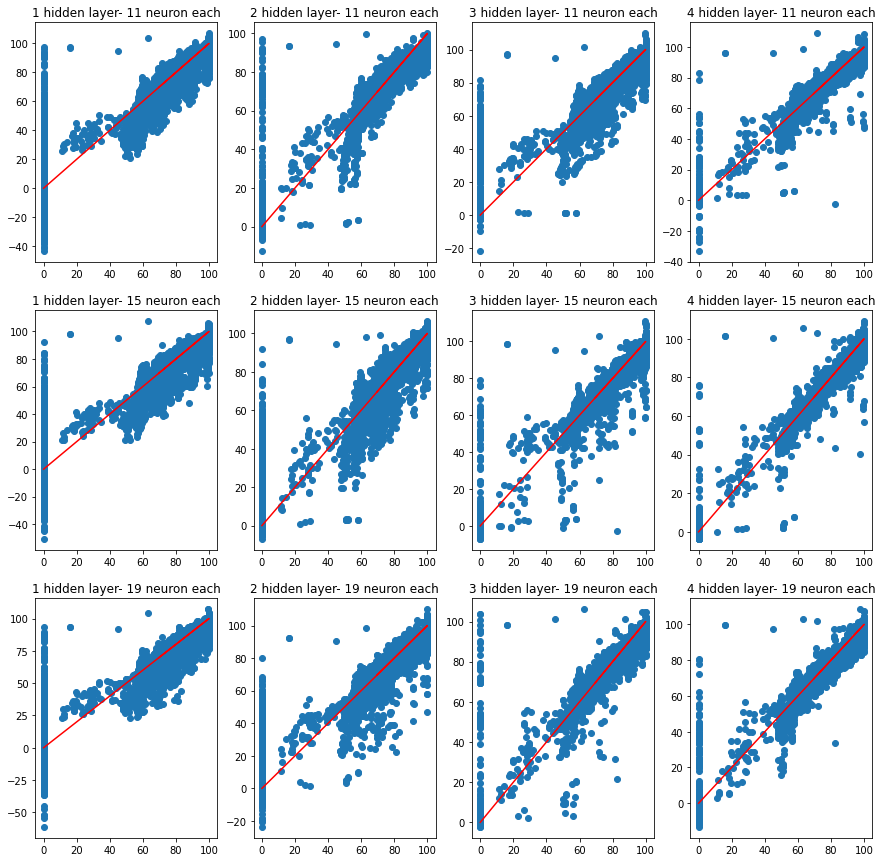

In [ ]:
f, ax = plt.subplots(3,4,figsize=(15,15))

ax=plt.subplot(3,4, 1)
plt.scatter(y_test,predictions_1)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('1 hidden layer- 11 neuron each')

ax=plt.subplot(3,4, 2)
plt.scatter(y_test,predictions_2)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('2 hidden layer- 11 neuron each')

ax=plt.subplot(3,4, 3)
plt.scatter(y_test,predictions_3)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('3 hidden layer- 11 neuron each')

ax=plt.subplot(3,4, 4)
plt.scatter(y_test,predictions_4)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('4 hidden layer- 11 neuron each')

############

ax=plt.subplot(3,4, 5)
plt.scatter(y_test,predictions_5)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('1 hidden layer- 15 neuron each')

ax=plt.subplot(3,4, 6)
plt.scatter(y_test,predictions_6)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('2 hidden layer- 15 neuron each')

ax=plt.subplot(3,4, 7)
plt.scatter(y_test,predictions_7)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('3 hidden layer- 15 neuron each')

ax=plt.subplot(3,4, 8)
plt.scatter(y_test,predictions_8)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('4 hidden layer- 15 neuron each')

###################

ax=plt.subplot(3,4, 9)
plt.scatter(y_test,predictions_9)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('1 hidden layer- 19 neuron each')

ax=plt.subplot(3,4, 10)
plt.scatter(y_test,predictions_10)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('2 hidden layer- 19 neuron each')

ax=plt.subplot(3,4, 11)
plt.scatter(y_test,predictions_11)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('3 hidden layer- 19 neuron each')

ax=plt.subplot(3,4, 12)
plt.scatter(y_test,predictions_12)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('4 hidden layer- 19 neuron each')

plt.show()

In [ ]:
MAE_3=[mean_absolute_error(y_test,predictions_1),mean_absolute_error(y_test,predictions_2),
     mean_absolute_error(y_test,predictions_3), mean_absolute_error(y_test,predictions_4),
     mean_absolute_error(y_test,predictions_5),mean_absolute_error(y_test,predictions_6),
     mean_absolute_error(y_test,predictions_7),mean_absolute_error(y_test,predictions_8),
     mean_absolute_error(y_test,predictions_9),mean_absolute_error(y_test,predictions_10),
     mean_absolute_error(y_test,predictions_11),mean_absolute_error(y_test,predictions_12)]

In [ ]:
np.sqrt(MAE_3)

array([3.48961451, 2.31719703, 2.52598082, 1.90962225, 3.53832842,
       2.52878538, 1.97972234, 1.68986237, 3.49673494, 2.47630768,
       2.0205556 , 1.85800594])

In [ ]:
Berea_7['permPerc'].mean()

46.64678788227939

In [ ]:
Berea_7['permPerc'].median()

58.41390594

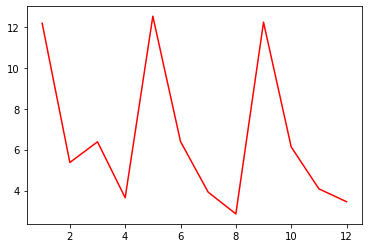

In [ ]:
plt.plot(range(1,13),MAE_3,'r')

It seems model 8 has a better accuracy (4 hidden layer,15 neuron each)

#sampling -2nd


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


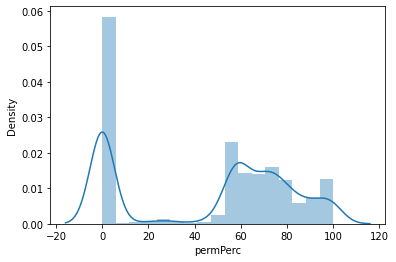

In [ ]:
sns.distplot(Berea_7['permPerc'])

The disturbution plot for permPerc which we want to predict with ANN shows extremely unbalanced data. So in this section we are going to make a balanced dataset which could be used for prediction 

## Version 2 sampling double zeros


###Version2 Preparation

Since the previous model match for percPerm near zero is not very good, we are doubling this class.

In [ ]:
Berea_balanced_2=pd.concat([perm_0_005_sample1,perm_0_005_sample1,
perm_005_01_sample1,
perm_01_015_sample1,
perm_015_02_sample1,
perm_02_025_sample1,
perm_025_03_sample1,
perm_03_035_sample1,
perm_035_04_sample1,
perm_04_045_sample1,
perm_045_05_sample1,
perm_05_055_sample1,
perm_055_06_sample1,
perm_06_065_sample1,
perm_065_07_sample1,
perm_07_075_sample1,
perm_075_08_sample1,
perm_08_085_sample1,
perm_085_09_sample1,
perm_09_095_sample1,
perm_095_1_sample1,
] ,axis=0)

In [ ]:
Berea_balanced_2.shape

(4200, 8)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


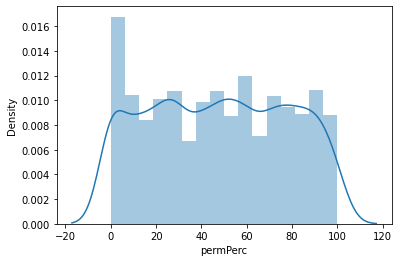

In [ ]:
sns.distplot(Berea_balanced_2['permPerc'])

###Version2 models

####training the model

In [ ]:

X = Berea_balanced_2.drop(['poroPerc', 'permPerc'],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_balanced_2['permPerc']

In [ ]:
X.shape

(4200, 6)

In [ ]:
y

17364     0.000000
8681      0.000000
9785      0.000000
16337     0.000000
10964     0.000000
           ...    
10735    99.966537
11204    99.645033
11427    99.542146
408      99.899342
413      99.899333
Name: permPerc, Length: 4200, dtype: float64

In [ ]:
X_train_02, X_test_02, y_train_02, y_test_02 = train_test_split(X,y,test_size=0.3,random_state=101)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_02= scaler.fit_transform(X_train_02)

In [ ]:
X_test_02= scaler.transform(X_test_02)

In [ ]:
model_02 = Sequential()

model_02.add(Dense(19,activation='relu'))
model_02.add(Dense(19,activation='relu'))
model_02.add(Dense(19,activation='relu'))
model_02.add(Dense(19,activation='relu'))
model_02.add(Dense(19,activation='relu'))
model_02.add(Dense(19,activation='relu'))
model_02.add(Dense(19,activation='relu'))
model_02.add(Dense(1))

model_02.compile(optimizer='adam',loss='mse')

In [ ]:
model_02.fit(x=X_train_02,y=y_train_02.values,
          validation_data=(X_test_02,y_test_02.values),
          batch_size=128,epochs=400)

Epoch 1/400
23/23 [==============================] - 1s 11ms/step - loss: 3151.7173 - val_loss: 3240.0793
Epoch 2/400
23/23 [==============================] - 0s 4ms/step - loss: 3082.5383 - val_loss: 3083.4448
Epoch 3/400
23/23 [==============================] - 0s 4ms/step - loss: 2690.1250 - val_loss: 2215.9609
Epoch 4/400
23/23 [==============================] - 0s 4ms/step - loss: 1332.8621 - val_loss: 918.6002
Epoch 5/400
23/23 [==============================] - 0s 4ms/step - loss: 808.2323 - val_loss: 784.1215
Epoch 6/400
23/23 [==============================] - 0s 4ms/step - loss: 709.6422 - val_loss: 691.1481
Epoch 7/400
23/23 [==============================] - 0s 5ms/step - loss: 633.1288 - val_loss: 612.5184
Epoch 8/400
23/23 [==============================] - 0s 4ms/step - loss: 557.0217 - val_loss: 530.9471
Epoch 9/400
23/23 [==============================] - 0s 4ms/step - loss: 478.6543 - val_loss: 443.6330
Epoch 10/400
23/23 [==============================] - 0s 4ms/step

####evaluation

In [ ]:
losses_02 = pd.DataFrame(model_02.history.history)

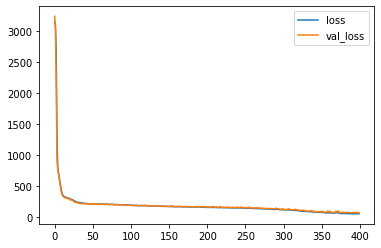

In [ ]:
losses_02.plot()

In [ ]:
predictions_02 = model_02.predict(X_test_02)

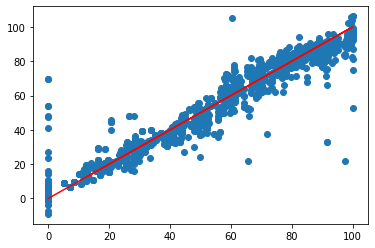

In [ ]:
# Our predictions
plt.scatter(y_test_02,predictions_02)

# Perfect predictions
plt.plot(y_test_02,y_test_02,'r')

In [ ]:
errors_02 = y_test_02.values.reshape(1260, 1) - predictions_02

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


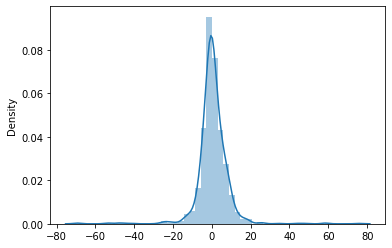

In [ ]:
sns.distplot(errors_02)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


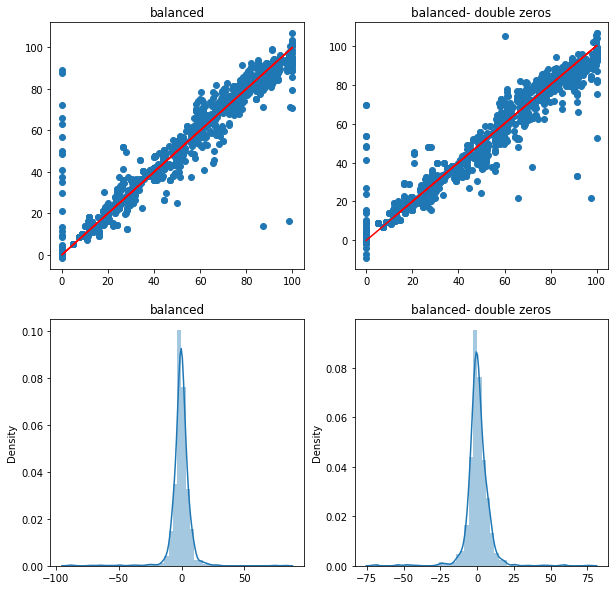

In [ ]:
f, ax = plt.subplots(2,2,figsize=(10,10))

ax=plt.subplot(2,2, 1)
plt.scatter(y_test_01,predictions_01)# Our predictions
cax=plt.plot(y_test_01,y_test_01,'r')# Perfect predictions
ax.set_title('balanced')

ax=plt.subplot(2,2, 2)
plt.scatter(y_test_02,predictions_02)# Our predictions
cax=plt.plot(y_test_02,y_test_02,'r')# Perfect predictions
ax.set_title('balanced- double zeros')

ax=plt.subplot(2,2, 3)
sns.distplot(errors_01)
ax.set_title('balanced')

ax=plt.subplot(2,2, 4)
sns.distplot(errors_02)
ax.set_title('balanced- double zeros')

plt.show()

##Version 3 sampling three times zeros

###Version3 Preparation

Since the previous model match for percPerm near zero is not very good, we make a dataframe with for times of zero class

In [ ]:
Berea_balanced_3=pd.concat([perm_0_005_sample1,perm_0_005_sample1,perm_0_005_sample1,
perm_005_01_sample1,
perm_01_015_sample1,
perm_015_02_sample1,
perm_02_025_sample1,
perm_025_03_sample1,
perm_03_035_sample1,
perm_035_04_sample1,
perm_04_045_sample1,
perm_045_05_sample1,
perm_05_055_sample1,
perm_055_06_sample1,
perm_06_065_sample1,
perm_065_07_sample1,
perm_07_075_sample1,
perm_075_08_sample1,
perm_08_085_sample1,
perm_085_09_sample1,
perm_09_095_sample1,
perm_095_1_sample1,
] ,axis=0)

In [ ]:
Berea_balanced_3.shape

(4400, 8)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


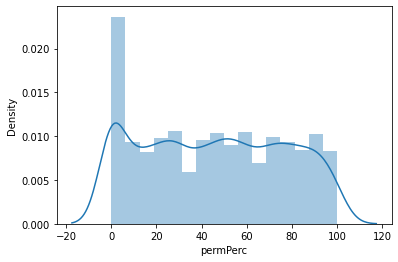

In [ ]:
sns.distplot(Berea_balanced_3['permPerc'])

###Version3 models

####training the model

In [ ]:

X = Berea_balanced_3.drop(['poroPerc', 'permPerc'],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_balanced_3['permPerc']

In [ ]:
X_train_03, X_test_03, y_train_03, y_test_03 = train_test_split(X,y,test_size=0.3,random_state=101)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_03= scaler.fit_transform(X_train_03)

In [ ]:
X_test_03= scaler.transform(X_test_03)

In [ ]:
model_03 = Sequential()

model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(1))

model_03.compile(optimizer='adam',loss='mse')

In [ ]:
model_03.fit(x=X_train_03,y=y_train_03.values,
          validation_data=(X_test_03,y_test_03.values),
          batch_size=128,epochs=400)

Epoch 1/400
25/25 [==============================] - 1s 10ms/step - loss: 3033.3960 - val_loss: 3058.1262
Epoch 2/400
25/25 [==============================] - 0s 4ms/step - loss: 3022.8140 - val_loss: 3043.3179
Epoch 3/400
25/25 [==============================] - 0s 4ms/step - loss: 2994.1519 - val_loss: 2978.3313
Epoch 4/400
25/25 [==============================] - 0s 5ms/step - loss: 2774.6106 - val_loss: 2370.9285
Epoch 5/400
25/25 [==============================] - 0s 4ms/step - loss: 1518.2214 - val_loss: 1078.0107
Epoch 6/400
25/25 [==============================] - 0s 5ms/step - loss: 901.3637 - val_loss: 823.4454
Epoch 7/400
25/25 [==============================] - 0s 4ms/step - loss: 761.4786 - val_loss: 722.5595
Epoch 8/400
25/25 [==============================] - 0s 4ms/step - loss: 671.2034 - val_loss: 636.0447
Epoch 9/400
25/25 [==============================] - 0s 4ms/step - loss: 593.1943 - val_loss: 565.8757
Epoch 10/400
25/25 [==============================] - 0s 5ms/s

####evaluation

In [ ]:
losses_03 = pd.DataFrame(model_03.history.history)

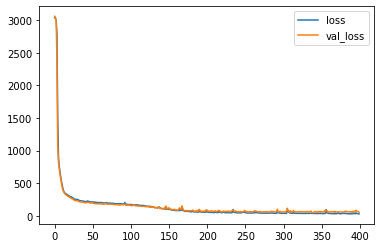

In [ ]:
losses_03.plot()

In [ ]:
predictions_03 = model_03.predict(X_test_03)

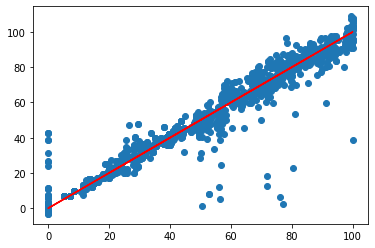

In [ ]:
# Our predictions
plt.scatter(y_test_03,predictions_03)

# Perfect predictions
plt.plot(y_test_03,y_test_03,'r')

In [ ]:
errors_03 = y_test_03.values.reshape(1320, 1) - predictions_03

ValueError: ignored

In [ ]:
sns.distplot(errors_03)

In [ ]:
f, ax = plt.subplots(2,3,figsize=(15,10))

ax=plt.subplot(2,3, 1)
plt.scatter(y_test_01,predictions_01)# Our predictions
cax=plt.plot(y_test_01,y_test_01,'r')# Perfect predictions
ax.set_title('balanced')

ax=plt.subplot(2,3, 2)
plt.scatter(y_test_02,predictions_02)# Our predictions
cax=plt.plot(y_test_02,y_test_02,'r')# Perfect predictions
ax.set_title('balanced- double zeros')

ax=plt.subplot(2,3, 3)
plt.scatter(y_test_03,predictions_03)# Our predictions
cax=plt.plot(y_test_03,y_test_03,'r')# Perfect predictions
ax.set_title('balanced- four times zeros')

ax=plt.subplot(2,3, 4)
sns.distplot(errors_01)
ax.set_title('balanced')

ax=plt.subplot(2,3, 5)
sns.distplot(errors_02)
ax.set_title('balanced- double zeros')

ax=plt.subplot(2,3, 6)
sns.distplot(errors_03)
ax.set_title('balanced- four times zeros')

plt.show()

In [ ]:
MAE_balancing=[mean_absolute_error(y_test_01,predictions_01),mean_absolute_error(y_test_02,predictions_02),
     mean_absolute_error(y_test_03,predictions_03)]

In [ ]:
plt.plot(range(1,4),MAE_balancing,'r')

In [ ]:
MAE_balancing

Now, the results seems much more better, so we will work on selecting hyperparameters for better performance

##Version 4 sampling four times zeros

###Version4 Preparation

Since the previous model match for percPerm near zero is not very good, we make a dataframe with for times of zero class

In [ ]:
Berea_balanced_3=pd.concat([perm_0_005_sample1,perm_0_005_sample1,perm_0_005_sample1,
perm_005_01_sample1,
perm_01_015_sample1,
perm_015_02_sample1,
perm_02_025_sample1,
perm_025_03_sample1,
perm_03_035_sample1,
perm_035_04_sample1,
perm_04_045_sample1,
perm_045_05_sample1,
perm_05_055_sample1,
perm_055_06_sample1,
perm_06_065_sample1,
perm_065_07_sample1,
perm_07_075_sample1,
perm_075_08_sample1,
perm_08_085_sample1,
perm_085_09_sample1,
perm_09_095_sample1,
perm_095_1_sample1,
] ,axis=0)

In [ ]:
Berea_balanced_3.shape

(4400, 8)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


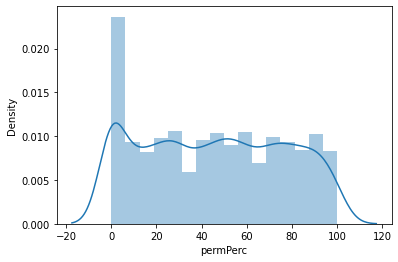

In [ ]:
sns.distplot(Berea_balanced_3['permPerc'])

###Version3 models

####training the model

In [ ]:

X = Berea_balanced_3.drop(['poroPerc', 'permPerc'],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_balanced_3['permPerc']

In [ ]:
X_train_03, X_test_03, y_train_03, y_test_03 = train_test_split(X,y,test_size=0.3,random_state=101)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_03= scaler.fit_transform(X_train_03)

In [ ]:
X_test_03= scaler.transform(X_test_03)

In [ ]:
model_03 = Sequential()

model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(19,activation='relu'))
model_03.add(Dense(1))

model_03.compile(optimizer='adam',loss='mse')

In [ ]:
model_03.fit(x=X_train_03,y=y_train_03.values,
          validation_data=(X_test_03,y_test_03.values),
          batch_size=128,epochs=400)

Epoch 1/400
25/25 [==============================] - 1s 10ms/step - loss: 3017.5671 - val_loss: 3012.6487
Epoch 2/400
25/25 [==============================] - 0s 4ms/step - loss: 2886.5801 - val_loss: 2692.2542
Epoch 3/400
25/25 [==============================] - 0s 4ms/step - loss: 2083.8542 - val_loss: 1131.1971
Epoch 4/400
25/25 [==============================] - 0s 4ms/step - loss: 882.2296 - val_loss: 770.4375
Epoch 5/400
25/25 [==============================] - 0s 4ms/step - loss: 696.9695 - val_loss: 621.9209
Epoch 6/400
25/25 [==============================] - 0s 4ms/step - loss: 555.7516 - val_loss: 509.1244
Epoch 7/400
25/25 [==============================] - 0s 4ms/step - loss: 455.7261 - val_loss: 424.2781
Epoch 8/400
25/25 [==============================] - 0s 4ms/step - loss: 391.7947 - val_loss: 377.9713
Epoch 9/400
25/25 [==============================] - 0s 4ms/step - loss: 360.7798 - val_loss: 356.9679
Epoch 10/400
25/25 [==============================] - 0s 4ms/step 

####evaluation

In [ ]:
losses_03 = pd.DataFrame(model_03.history.history)

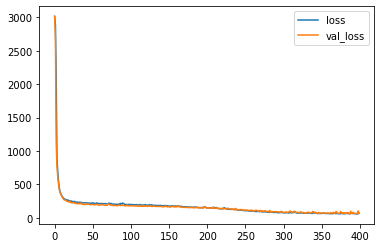

In [ ]:
losses_03.plot()

In [ ]:
predictions_03 = model_03.predict(X_test_03)

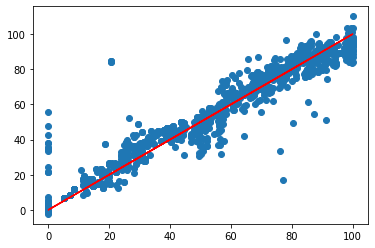

In [ ]:
# Our predictions
plt.scatter(y_test_03,predictions_03)

# Perfect predictions
plt.plot(y_test_03,y_test_03,'r')

In [ ]:
errors_03 = y_test_03.values.reshape(1320, 1) - predictions_03

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


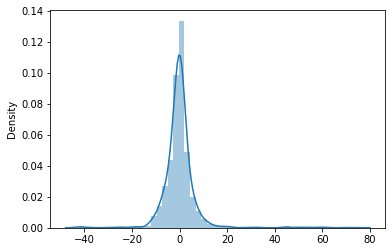

In [ ]:
sns.distplot(errors_03)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

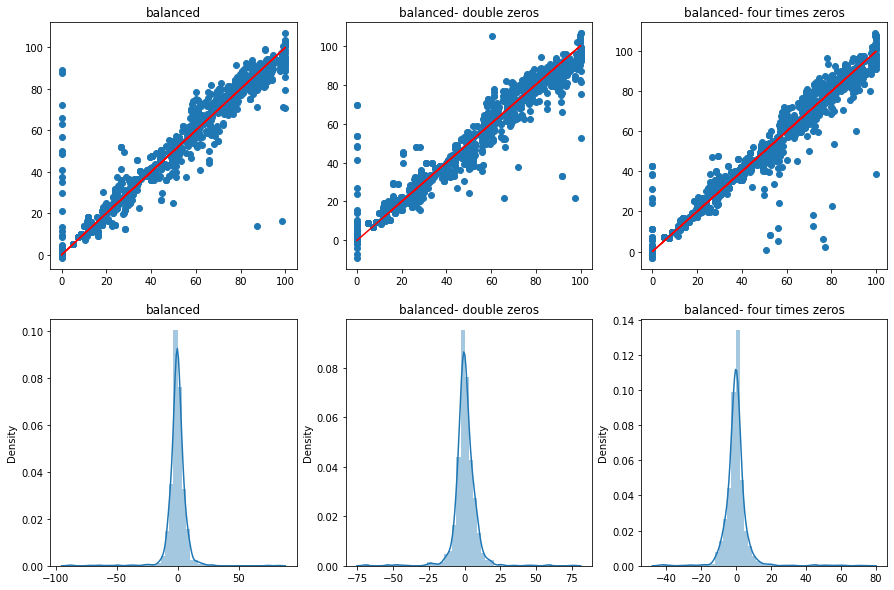

In [ ]:
f, ax = plt.subplots(2,3,figsize=(15,10))

ax=plt.subplot(2,3, 1)
plt.scatter(y_test_01,predictions_01)# Our predictions
cax=plt.plot(y_test_01,y_test_01,'r')# Perfect predictions
ax.set_title('balanced')

ax=plt.subplot(2,3, 2)
plt.scatter(y_test_02,predictions_02)# Our predictions
cax=plt.plot(y_test_02,y_test_02,'r')# Perfect predictions
ax.set_title('balanced- double zeros')

ax=plt.subplot(2,3, 3)
plt.scatter(y_test_03,predictions_03)# Our predictions
cax=plt.plot(y_test_03,y_test_03,'r')# Perfect predictions
ax.set_title('balanced- four times zeros')

ax=plt.subplot(2,3, 4)
sns.distplot(errors_01)
ax.set_title('balanced')

ax=plt.subplot(2,3, 5)
sns.distplot(errors_02)
ax.set_title('balanced- double zeros')

ax=plt.subplot(2,3, 6)
sns.distplot(errors_03)
ax.set_title('balanced- four times zeros')

plt.show()

##Version4 four times zeros

###Version4 Preparation

Since the previous model match for percPerm near zero is not very good, we make a dataframe with for times of zero class

In [ ]:
Berea_balanced_4=pd.concat([perm_0_005_sample1,perm_0_005_sample1,perm_0_005_sample1,perm_0_005_sample1,
perm_005_01_sample1,
perm_01_015_sample1,
perm_015_02_sample1,
perm_02_025_sample1,
perm_025_03_sample1,
perm_03_035_sample1,
perm_035_04_sample1,
perm_04_045_sample1,
perm_045_05_sample1,
perm_05_055_sample1,
perm_055_06_sample1,
perm_06_065_sample1,
perm_065_07_sample1,
perm_07_075_sample1,
perm_075_08_sample1,
perm_08_085_sample1,
perm_085_09_sample1,
perm_09_095_sample1,
perm_095_1_sample1,
] ,axis=0)

In [ ]:
Berea_balanced_4.shape

(4600, 8)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


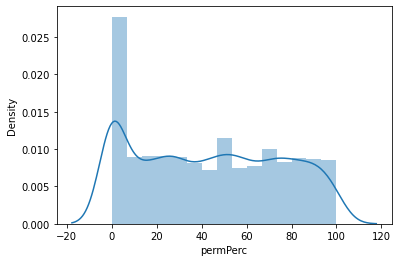

In [ ]:
sns.distplot(Berea_balanced_4['permPerc'])

###Version4 models

####training the model

In [ ]:

X = Berea_balanced_4.drop(['poroPerc', 'permPerc'],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_balanced_4['permPerc']

In [ ]:
X_train_04, X_test_04, y_train_04, y_test_04 = train_test_split(X,y,test_size=0.3,random_state=101)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train_04= scaler.fit_transform(X_train_04)

In [ ]:
X_test_04= scaler.transform(X_test_04)

In [ ]:
model_04 = Sequential()

model_04.add(Dense(19,activation='relu'))
model_04.add(Dense(19,activation='relu'))
model_04.add(Dense(19,activation='relu'))
model_04.add(Dense(19,activation='relu'))
model_04.add(Dense(19,activation='relu'))
model_04.add(Dense(19,activation='relu'))
model_04.add(Dense(19,activation='relu'))
model_04.add(Dense(1))

model_04.compile(optimizer='adam',loss='mse')

In [ ]:
model_04.fit(x=X_train_04,y=y_train_04.values,
          validation_data=(X_test_04,y_test_04.values),
          batch_size=128,epochs=400)

Epoch 1/400
26/26 [==============================] - 1s 11ms/step - loss: 2901.3071 - val_loss: 2913.2517
Epoch 2/400
26/26 [==============================] - 0s 4ms/step - loss: 2869.7339 - val_loss: 2828.5908
Epoch 3/400
26/26 [==============================] - 0s 4ms/step - loss: 2566.3704 - val_loss: 2033.0663
Epoch 4/400
26/26 [==============================] - 0s 4ms/step - loss: 1244.5242 - val_loss: 955.9289
Epoch 5/400
26/26 [==============================] - 0s 5ms/step - loss: 822.4495 - val_loss: 767.4884
Epoch 6/400
26/26 [==============================] - 0s 4ms/step - loss: 699.5806 - val_loss: 663.1877
Epoch 7/400
26/26 [==============================] - 0s 5ms/step - loss: 591.7726 - val_loss: 561.7420
Epoch 8/400
26/26 [==============================] - 0s 4ms/step - loss: 501.0462 - val_loss: 483.0004
Epoch 9/400
26/26 [==============================] - 0s 4ms/step - loss: 435.4224 - val_loss: 422.2511
Epoch 10/400
26/26 [==============================] - 0s 4ms/step

####evaluation

In [ ]:
losses_04 = pd.DataFrame(model_04.history.history)

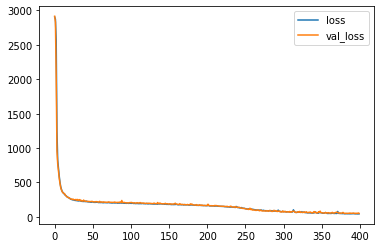

In [ ]:
losses_04.plot()

In [ ]:
predictions_04 = model_04.predict(X_test_04)

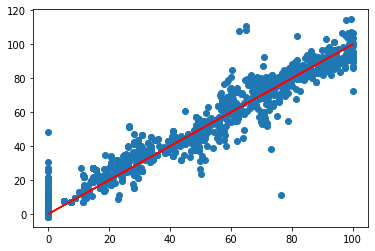

In [ ]:
# Our predictions
plt.scatter(y_test_04,predictions_04)

# Perfect predictions
plt.plot(y_test_04,y_test_04,'r')

In [ ]:
errors_04 = y_test_04.values.reshape(1380, 1) - predictions_04

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


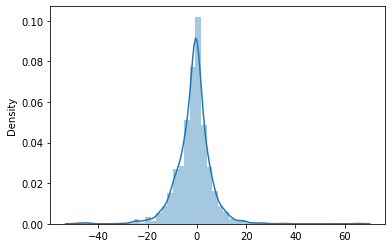

In [ ]:
sns.distplot(errors_04)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

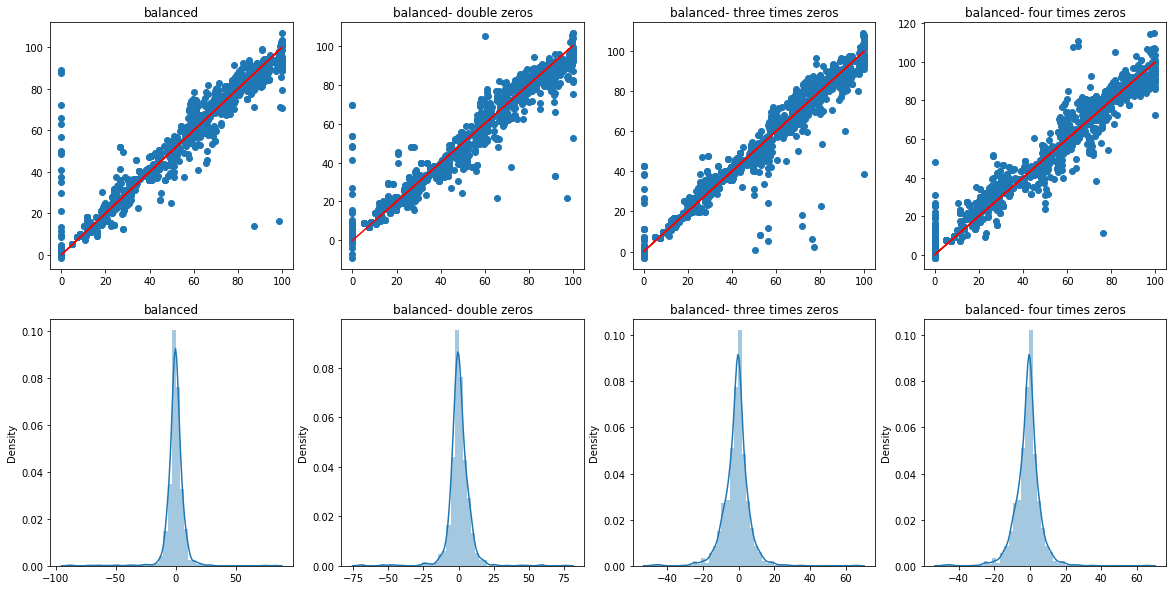

In [ ]:
f, ax = plt.subplots(2,4,figsize=(20,10))

ax=plt.subplot(2,4, 1)
plt.scatter(y_test_01,predictions_01)# Our predictions
cax=plt.plot(y_test_01,y_test_01,'r')# Perfect predictions
ax.set_title('balanced')

ax=plt.subplot(2,4, 2)
plt.scatter(y_test_02,predictions_02)# Our predictions
cax=plt.plot(y_test_02,y_test_02,'r')# Perfect predictions
ax.set_title('balanced- double zeros')

ax=plt.subplot(2,4, 3)
plt.scatter(y_test_03,predictions_03)# Our predictions
cax=plt.plot(y_test_03,y_test_03,'r')# Perfect predictions
ax.set_title('balanced- three times zeros')


ax=plt.subplot(2,4, 4)
plt.scatter(y_test_04,predictions_04)# Our predictions
cax=plt.plot(y_test_04,y_test_04,'r')# Perfect predictions
ax.set_title('balanced- four times zeros')

ax=plt.subplot(2,4, 5)
sns.distplot(errors_01)
ax.set_title('balanced')

ax=plt.subplot(2,4, 6)
sns.distplot(errors_02)
ax.set_title('balanced- double zeros')

ax=plt.subplot(2,4, 7)
sns.distplot(errors_04)
ax.set_title('balanced- three times zeros')

ax=plt.subplot(2,4, 8)
sns.distplot(errors_04)
ax.set_title('balanced- four times zeros')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

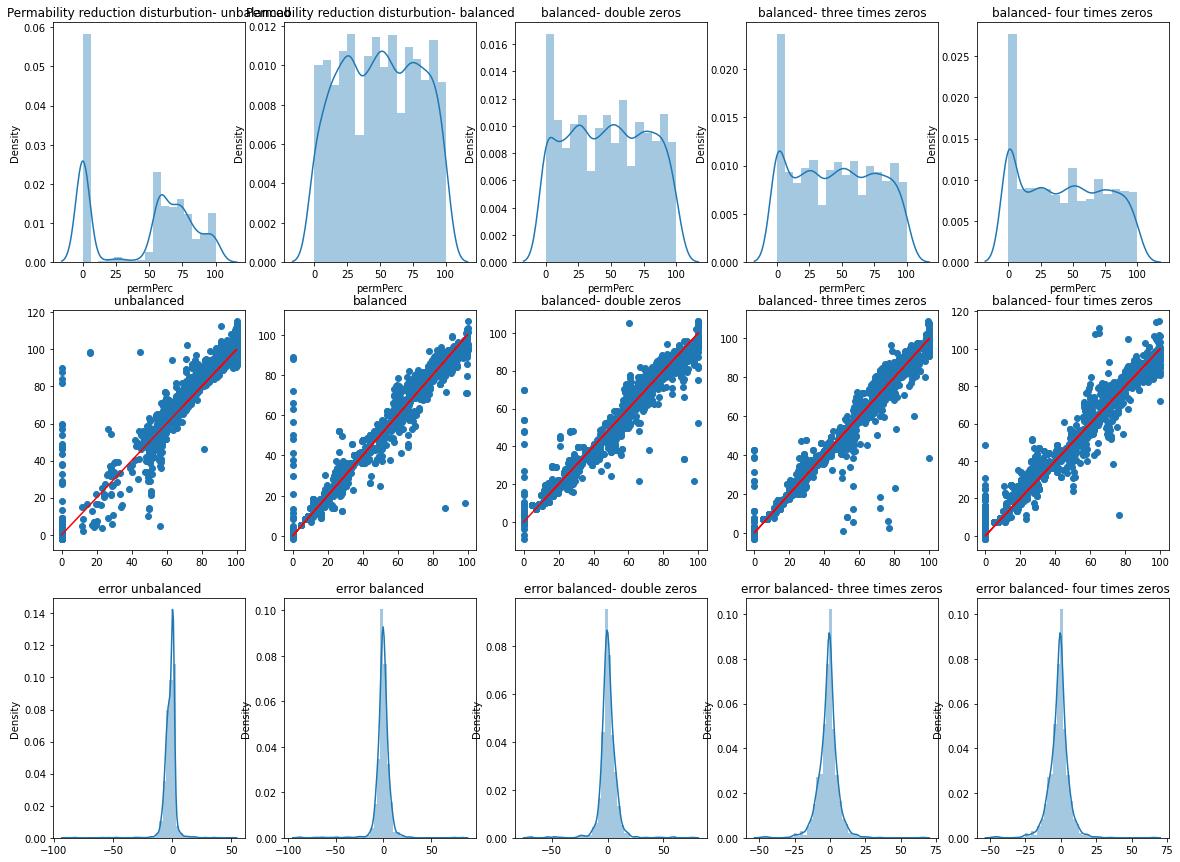

In [ ]:
f, ax = plt.subplots(3,5,figsize=(20,15))

ax=plt.subplot(3,5, 1)
sns.distplot(Berea_7['permPerc'])
ax.set_title('Permability reduction disturbution- unbalanced')

ax=plt.subplot(3,5, 2)
sns.distplot(Berea_balanced_1['permPerc'])
ax.set_title('Permability reduction disturbution- balanced')

ax=plt.subplot(3,5, 3)
sns.distplot(Berea_balanced_2['permPerc'])
ax.set_title('balanced- double zeros')

ax=plt.subplot(3,5, 4)
sns.distplot(Berea_balanced_3['permPerc'])
ax.set_title('balanced- three times zeros')

ax=plt.subplot(3,5, 5)
sns.distplot(Berea_balanced_4['permPerc'])
ax.set_title('balanced- four times zeros')

ax=plt.subplot(3,5, 6)
plt.scatter(y_test_00,predictions_00)# Our predictions
cax=plt.plot(y_test_00,y_test_00,'r')# Perfect predictions
ax.set_title('unbalanced')

ax=plt.subplot(3,5, 7)
plt.scatter(y_test_01,predictions_01)# Our predictions
cax=plt.plot(y_test_01,y_test_01,'r')# Perfect predictions
ax.set_title('balanced')

ax=plt.subplot(3,5, 8)
plt.scatter(y_test_02,predictions_02)# Our predictions
cax=plt.plot(y_test_02,y_test_02,'r')# Perfect predictions
ax.set_title('balanced- double zeros')

ax=plt.subplot(3,5, 9)
plt.scatter(y_test_03,predictions_03)# Our predictions
cax=plt.plot(y_test_03,y_test_03,'r')# Perfect predictions
ax.set_title('balanced- three times zeros')


ax=plt.subplot(3,5, 10)
plt.scatter(y_test_04,predictions_04)# Our predictions
cax=plt.plot(y_test_04,y_test_04,'r')# Perfect predictions
ax.set_title('balanced- four times zeros')

ax=plt.subplot(3,5, 11)
sns.distplot(errors_00)
ax.set_title('error unbalanced')

ax=plt.subplot(3,5, 12)
sns.distplot(errors_01)
ax.set_title('error balanced')

ax=plt.subplot(3,5, 13)
sns.distplot(errors_02)
ax.set_title('error balanced- double zeros')

ax=plt.subplot(3,5, 14)
sns.distplot(errors_04)
ax.set_title('error balanced- three times zeros')

ax=plt.subplot(3,5, 15)
sns.distplot(errors_04)
ax.set_title('error balanced- four times zeros')

plt.show()

In [ ]:
MAE_balancing=[mean_absolute_error(y_test_00,predictions_00),mean_absolute_error(y_test_01,predictions_01),mean_absolute_error(y_test_02,predictions_02),mean_absolute_error(y_test_03,predictions_03),
     mean_absolute_error(y_test_04,predictions_04)]

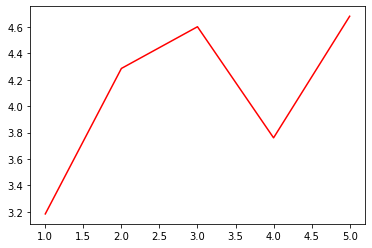

In [ ]:
plt.plot(range(1,6),MAE_balancing,'r')

In [ ]:
MAE_balancing

[3.1833821433901397,
 4.28573097126172,
 4.601818551449016,
 3.760074432157269,
 4.681426294923551]

It seems dataset third datasets ( containing three times of zero class ) shows better performance.
-MAE is lower
-the range for error disturbution is smaller
-scatter plot shows better match

# HPO- 2nd


Although the result of model 7 for Berea_balanced_3 dataset looks fine, we could try to make it better by addding new neurons and hidden layers to the network.

## with 11 neurons in each layer

In [ ]:

X = Berea_balanced_3.drop(['poroPerc', 'permPerc'],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_balanced_3['permPerc']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)

####Scaling

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train= scaler.fit_transform(X_train)

In [ ]:
X_test= scaler.transform(X_test)

In [ ]:
X_train.shape

(3080, 6)

In [ ]:
X_test.shape

(1320, 6)

#### training and validation

In [ ]:
deep_model_1 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_1.add(Dense(11,activation='relu'))
deep_model_1.add(Dense(1))

deep_model_1.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_1.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
25/25 [==============================] - 1s 7ms/step - loss: 3062.8545 - val_loss: 3082.0713
Epoch 2/400
25/25 [==============================] - 0s 3ms/step - loss: 3044.6199 - val_loss: 3063.8970
Epoch 3/400
25/25 [==============================] - 0s 3ms/step - loss: 3026.4978 - val_loss: 3045.1189
Epoch 4/400
25/25 [==============================] - 0s 4ms/step - loss: 3007.1204 - val_loss: 3024.6743
Epoch 5/400
25/25 [==============================] - 0s 3ms/step - loss: 2985.5283 - val_loss: 3001.4177
Epoch 6/400
25/25 [==============================] - 0s 3ms/step - loss: 2961.7795 - val_loss: 2976.6980
Epoch 7/400
25/25 [==============================] - 0s 3ms/step - loss: 2936.4358 - val_loss: 2949.9670
Epoch 8/400
25/25 [==============================] - 0s 3ms/step - loss: 2908.8831 - val_loss: 2921.5322
Epoch 9/400
25/25 [==============================] - 0s 3ms/step - loss: 2879.5696 - val_loss: 2890.8867
Epoch 10/400
25/25 [==============================] - 0

In [ ]:
deep_model_2 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_2.add(Dense(11,activation='relu'))
deep_model_2.add(Dense(11,activation='relu'))
deep_model_2.add(Dense(1))

deep_model_2.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_2.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
25/25 [==============================] - 1s 8ms/step - loss: 3008.1606 - val_loss: 3027.4722
Epoch 2/400
25/25 [==============================] - 0s 3ms/step - loss: 2986.7969 - val_loss: 3002.5090
Epoch 3/400
25/25 [==============================] - 0s 3ms/step - loss: 2956.4175 - val_loss: 2965.0139
Epoch 4/400
25/25 [==============================] - 0s 3ms/step - loss: 2909.0889 - val_loss: 2904.9871
Epoch 5/400
25/25 [==============================] - 0s 3ms/step - loss: 2833.4744 - val_loss: 2811.3635
Epoch 6/400
25/25 [==============================] - 0s 3ms/step - loss: 2718.6404 - val_loss: 2671.6638
Epoch 7/400
25/25 [==============================] - 0s 3ms/step - loss: 2555.6406 - val_loss: 2482.2529
Epoch 8/400
25/25 [==============================] - 0s 4ms/step - loss: 2345.2952 - val_loss: 2250.1292
Epoch 9/400
25/25 [==============================] - 0s 4ms/step - loss: 2097.3372 - val_loss: 1984.3915
Epoch 10/400
25/25 [==============================] - 0

In [ ]:
deep_model_3 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_3.add(Dense(11,activation='relu'))
deep_model_3.add(Dense(11,activation='relu'))
deep_model_3.add(Dense(11,activation='relu'))
deep_model_3.add(Dense(1))

deep_model_3.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_3.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
25/25 [==============================] - 1s 9ms/step - loss: 3011.6650 - val_loss: 3021.1584
Epoch 2/400
25/25 [==============================] - 0s 3ms/step - loss: 2964.2778 - val_loss: 2957.1497
Epoch 3/400
25/25 [==============================] - 0s 4ms/step - loss: 2880.5850 - val_loss: 2844.5334
Epoch 4/400
25/25 [==============================] - 0s 4ms/step - loss: 2729.2656 - val_loss: 2638.5720
Epoch 5/400
25/25 [==============================] - 0s 4ms/step - loss: 2466.6262 - val_loss: 2294.8882
Epoch 6/400
25/25 [==============================] - 0s 3ms/step - loss: 2050.1697 - val_loss: 1806.2507
Epoch 7/400
25/25 [==============================] - 0s 3ms/step - loss: 1534.0956 - val_loss: 1286.5167
Epoch 8/400
25/25 [==============================] - 0s 4ms/step - loss: 1086.0219 - val_loss: 959.2883
Epoch 9/400
25/25 [==============================] - 0s 4ms/step - loss: 877.2769 - val_loss: 867.9794
Epoch 10/400
25/25 [==============================] - 0s 5

In [ ]:
deep_model_4 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_4.add(Dense(11,activation='relu'))
deep_model_4.add(Dense(11,activation='relu'))
deep_model_4.add(Dense(11,activation='relu'))
deep_model_4.add(Dense(11,activation='relu'))
deep_model_4.add(Dense(1))

deep_model_4.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_4.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
25/25 [==============================] - 1s 9ms/step - loss: 3032.6145 - val_loss: 3055.8442
Epoch 2/400
25/25 [==============================] - 0s 3ms/step - loss: 3019.7588 - val_loss: 3039.6875
Epoch 3/400
25/25 [==============================] - 0s 3ms/step - loss: 2994.4526 - val_loss: 2998.9333
Epoch 4/400
25/25 [==============================] - 0s 4ms/step - loss: 2926.8467 - val_loss: 2889.8098
Epoch 5/400
25/25 [==============================] - 0s 4ms/step - loss: 2747.1367 - val_loss: 2612.9539
Epoch 6/400
25/25 [==============================] - 0s 4ms/step - loss: 2338.9375 - val_loss: 2039.7294
Epoch 7/400
25/25 [==============================] - 0s 3ms/step - loss: 1620.6487 - val_loss: 1211.3157
Epoch 8/400
25/25 [==============================] - 0s 4ms/step - loss: 892.0795 - val_loss: 752.6309
Epoch 9/400
25/25 [==============================] - 0s 3ms/step - loss: 709.5010 - val_loss: 714.2197
Epoch 10/400
25/25 [==============================] - 0s 4m

## with 15 neurons in each layer

#### training and validation

In [ ]:
deep_model_5 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_5.add(Dense(15,activation='relu'))
deep_model_5.add(Dense(1))

deep_model_5.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_5.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
25/25 [==============================] - 1s 7ms/step - loss: 2969.7271 - val_loss: 2985.9219
Epoch 2/400
25/25 [==============================] - 0s 3ms/step - loss: 2945.4475 - val_loss: 2960.3154
Epoch 3/400
25/25 [==============================] - 0s 3ms/step - loss: 2918.3916 - val_loss: 2930.4619
Epoch 4/400
25/25 [==============================] - 0s 3ms/step - loss: 2885.7920 - val_loss: 2893.7227
Epoch 5/400
25/25 [==============================] - 0s 3ms/step - loss: 2845.0759 - val_loss: 2847.1570
Epoch 6/400
25/25 [==============================] - 0s 3ms/step - loss: 2793.0662 - val_loss: 2788.0820
Epoch 7/400
25/25 [==============================] - 0s 3ms/step - loss: 2727.1458 - val_loss: 2715.4143
Epoch 8/400
25/25 [==============================] - 0s 3ms/step - loss: 2648.1057 - val_loss: 2630.6658
Epoch 9/400
25/25 [==============================] - 0s 4ms/step - loss: 2561.0803 - val_loss: 2541.2791
Epoch 10/400
25/25 [==============================] - 0

In [ ]:
deep_model_6 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_6.add(Dense(15,activation='relu'))
deep_model_6.add(Dense(15,activation='relu'))
deep_model_6.add(Dense(1))

deep_model_6.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_6.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
25/25 [==============================] - 1s 8ms/step - loss: 3042.5715 - val_loss: 3048.9116
Epoch 2/400
25/25 [==============================] - 0s 4ms/step - loss: 3001.9358 - val_loss: 3012.4495
Epoch 3/400
25/25 [==============================] - 0s 3ms/step - loss: 2964.4580 - val_loss: 2970.3342
Epoch 4/400
25/25 [==============================] - 0s 3ms/step - loss: 2914.3481 - val_loss: 2910.2876
Epoch 5/400
25/25 [==============================] - 0s 3ms/step - loss: 2843.6150 - val_loss: 2825.6101
Epoch 6/400
25/25 [==============================] - 0s 3ms/step - loss: 2744.1116 - val_loss: 2707.1667
Epoch 7/400
25/25 [==============================] - 0s 4ms/step - loss: 2601.5095 - val_loss: 2532.6587
Epoch 8/400
25/25 [==============================] - 0s 3ms/step - loss: 2404.7585 - val_loss: 2313.3518
Epoch 9/400
25/25 [==============================] - 0s 3ms/step - loss: 2167.4905 - val_loss: 2057.5249
Epoch 10/400
25/25 [==============================] - 0

In [ ]:
deep_model_7 = Sequential()

deep_model_7.add(Dense(15,activation='relu'))
deep_model_7.add(Dense(15,activation='relu'))
deep_model_7.add(Dense(15,activation='relu'))
deep_model_7.add(Dense(1))

deep_model_7.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_7.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
25/25 [==============================] - 1s 8ms/step - loss: 3017.3994 - val_loss: 3031.9116
Epoch 2/400
25/25 [==============================] - 0s 3ms/step - loss: 2984.2065 - val_loss: 2985.4319
Epoch 3/400
25/25 [==============================] - 0s 3ms/step - loss: 2913.5264 - val_loss: 2876.4185
Epoch 4/400
25/25 [==============================] - 0s 3ms/step - loss: 2750.9524 - val_loss: 2635.2793
Epoch 5/400
25/25 [==============================] - 0s 3ms/step - loss: 2418.9575 - val_loss: 2198.1384
Epoch 6/400
25/25 [==============================] - 0s 3ms/step - loss: 1889.5035 - val_loss: 1588.4647
Epoch 7/400
25/25 [==============================] - 0s 3ms/step - loss: 1293.1722 - val_loss: 1063.4645
Epoch 8/400
25/25 [==============================] - 0s 3ms/step - loss: 922.2776 - val_loss: 883.0491
Epoch 9/400
25/25 [==============================] - 0s 4ms/step - loss: 832.1228 - val_loss: 833.6932
Epoch 10/400
25/25 [==============================] - 0s 3m

In [ ]:
deep_model_8 = Sequential()

#4 hidden layer 15 neuron each
deep_model_8.add(Dense(15,activation='relu'))
deep_model_8.add(Dense(15,activation='relu'))
deep_model_8.add(Dense(15,activation='relu'))
deep_model_8.add(Dense(15,activation='relu'))
deep_model_8.add(Dense(1))

deep_model_8.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_8.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
25/25 [==============================] - 1s 9ms/step - loss: 3014.0613 - val_loss: 3023.0874
Epoch 2/400
25/25 [==============================] - 0s 3ms/step - loss: 2959.9382 - val_loss: 2931.0164
Epoch 3/400
25/25 [==============================] - 0s 4ms/step - loss: 2795.3198 - val_loss: 2650.6135
Epoch 4/400
25/25 [==============================] - 0s 3ms/step - loss: 2358.3535 - val_loss: 1997.8884
Epoch 5/400
25/25 [==============================] - 0s 4ms/step - loss: 1517.4771 - val_loss: 1055.7501
Epoch 6/400
25/25 [==============================] - 0s 5ms/step - loss: 822.3132 - val_loss: 770.5437
Epoch 7/400
25/25 [==============================] - 0s 5ms/step - loss: 724.1221 - val_loss: 717.2961
Epoch 8/400
25/25 [==============================] - 0s 4ms/step - loss: 679.4479 - val_loss: 675.5612
Epoch 9/400
25/25 [==============================] - 0s 3ms/step - loss: 638.7971 - val_loss: 634.3241
Epoch 10/400
25/25 [==============================] - 0s 4ms/st

## with 19 neurons in each layer

#### training and validation

In [ ]:
deep_model_9 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_9.add(Dense(19,activation='relu'))
deep_model_9.add(Dense(1))

deep_model_9.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_9.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
25/25 [==============================] - 1s 7ms/step - loss: 3032.9939 - val_loss: 3047.8906
Epoch 2/400
25/25 [==============================] - 0s 3ms/step - loss: 3006.2454 - val_loss: 3019.5815
Epoch 3/400
25/25 [==============================] - 0s 3ms/step - loss: 2975.2910 - val_loss: 2984.8291
Epoch 4/400
25/25 [==============================] - 0s 4ms/step - loss: 2934.7300 - val_loss: 2937.4434
Epoch 5/400
25/25 [==============================] - 0s 3ms/step - loss: 2880.2617 - val_loss: 2877.8384
Epoch 6/400
25/25 [==============================] - 0s 3ms/step - loss: 2816.1794 - val_loss: 2809.5513
Epoch 7/400
25/25 [==============================] - 0s 3ms/step - loss: 2746.0085 - val_loss: 2738.2959
Epoch 8/400
25/25 [==============================] - 0s 3ms/step - loss: 2673.0901 - val_loss: 2663.1580
Epoch 9/400
25/25 [==============================] - 0s 3ms/step - loss: 2595.5898 - val_loss: 2583.2852
Epoch 10/400
25/25 [==============================] - 0

In [ ]:
deep_model_10 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_10.add(Dense(19,activation='relu'))
deep_model_10.add(Dense(19,activation='relu'))
deep_model_10.add(Dense(1))

deep_model_10.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_10.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
25/25 [==============================] - 1s 7ms/step - loss: 3021.8665 - val_loss: 3037.8115
Epoch 2/400
25/25 [==============================] - 0s 3ms/step - loss: 2994.4016 - val_loss: 3004.6252
Epoch 3/400
25/25 [==============================] - 0s 3ms/step - loss: 2951.6489 - val_loss: 2945.7351
Epoch 4/400
25/25 [==============================] - 0s 4ms/step - loss: 2869.4683 - val_loss: 2827.8831
Epoch 5/400
25/25 [==============================] - 0s 4ms/step - loss: 2715.1902 - val_loss: 2629.9412
Epoch 6/400
25/25 [==============================] - 0s 4ms/step - loss: 2479.1831 - val_loss: 2346.3162
Epoch 7/400
25/25 [==============================] - 0s 5ms/step - loss: 2158.4658 - val_loss: 1989.4385
Epoch 8/400
25/25 [==============================] - 0s 4ms/step - loss: 1775.1919 - val_loss: 1592.8904
Epoch 9/400
25/25 [==============================] - 0s 5ms/step - loss: 1392.9246 - val_loss: 1232.6028
Epoch 10/400
25/25 [==============================] - 0

In [ ]:
deep_model_11 = Sequential()

deep_model_11.add(Dense(19,activation='relu'))
deep_model_11.add(Dense(19,activation='relu'))
deep_model_11.add(Dense(19,activation='relu'))
deep_model_11.add(Dense(1))

deep_model_11.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_11.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
25/25 [==============================] - 2s 8ms/step - loss: 3030.4285 - val_loss: 3038.6587
Epoch 2/400
25/25 [==============================] - 0s 4ms/step - loss: 2985.2883 - val_loss: 2982.9600
Epoch 3/400
25/25 [==============================] - 0s 4ms/step - loss: 2901.5544 - val_loss: 2854.9292
Epoch 4/400
25/25 [==============================] - 0s 4ms/step - loss: 2707.5322 - val_loss: 2572.8247
Epoch 5/400
25/25 [==============================] - 0s 4ms/step - loss: 2320.0791 - val_loss: 2042.3689
Epoch 6/400
25/25 [==============================] - 0s 4ms/step - loss: 1671.4138 - val_loss: 1294.5851
Epoch 7/400
25/25 [==============================] - 0s 3ms/step - loss: 1013.2618 - val_loss: 839.9514
Epoch 8/400
25/25 [==============================] - 0s 4ms/step - loss: 783.9078 - val_loss: 776.1718
Epoch 9/400
25/25 [==============================] - 0s 3ms/step - loss: 734.4365 - val_loss: 723.8983
Epoch 10/400
25/25 [==============================] - 0s 3ms

In [ ]:
deep_model_12 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_12.add(Dense(19,activation='relu'))
deep_model_12.add(Dense(19,activation='relu'))
deep_model_12.add(Dense(19,activation='relu'))
deep_model_12.add(Dense(19,activation='relu'))
deep_model_12.add(Dense(1))

deep_model_12.compile(optimizer='adam',loss='mse')

In [ ]:
deep_model_12.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=400)

Epoch 1/400
25/25 [==============================] - 1s 8ms/step - loss: 3028.1162 - val_loss: 3040.6602
Epoch 2/400
25/25 [==============================] - 0s 4ms/step - loss: 2988.3855 - val_loss: 2981.2905
Epoch 3/400
25/25 [==============================] - 0s 4ms/step - loss: 2890.0554 - val_loss: 2813.7275
Epoch 4/400
25/25 [==============================] - 0s 4ms/step - loss: 2603.9058 - val_loss: 2339.1128
Epoch 5/400
25/25 [==============================] - 0s 5ms/step - loss: 1894.0344 - val_loss: 1364.5811
Epoch 6/400
25/25 [==============================] - 0s 4ms/step - loss: 961.2978 - val_loss: 770.4364
Epoch 7/400
25/25 [==============================] - 0s 4ms/step - loss: 743.2468 - val_loss: 727.5914
Epoch 8/400
25/25 [==============================] - 0s 3ms/step - loss: 695.6269 - val_loss: 689.3074
Epoch 9/400
25/25 [==============================] - 0s 5ms/step - loss: 662.0593 - val_loss: 655.3865
Epoch 10/400
25/25 [==============================] - 0s 4ms/st

## Evaluation on test data

In [ ]:
predictions_1 = deep_model_1.predict(X_test)
predictions_2 = deep_model_2.predict(X_test)
predictions_3 = deep_model_3.predict(X_test)
predictions_4 = deep_model_4.predict(X_test)
predictions_5 = deep_model_5.predict(X_test)
predictions_6 = deep_model_6.predict(X_test)
predictions_7 = deep_model_7.predict(X_test)
predictions_8 = deep_model_8.predict(X_test)
predictions_9 = deep_model_9.predict(X_test)
predictions_10 = deep_model_10.predict(X_test)
predictions_11 = deep_model_11.predict(X_test)
predictions_12 = deep_model_12.predict(X_test)


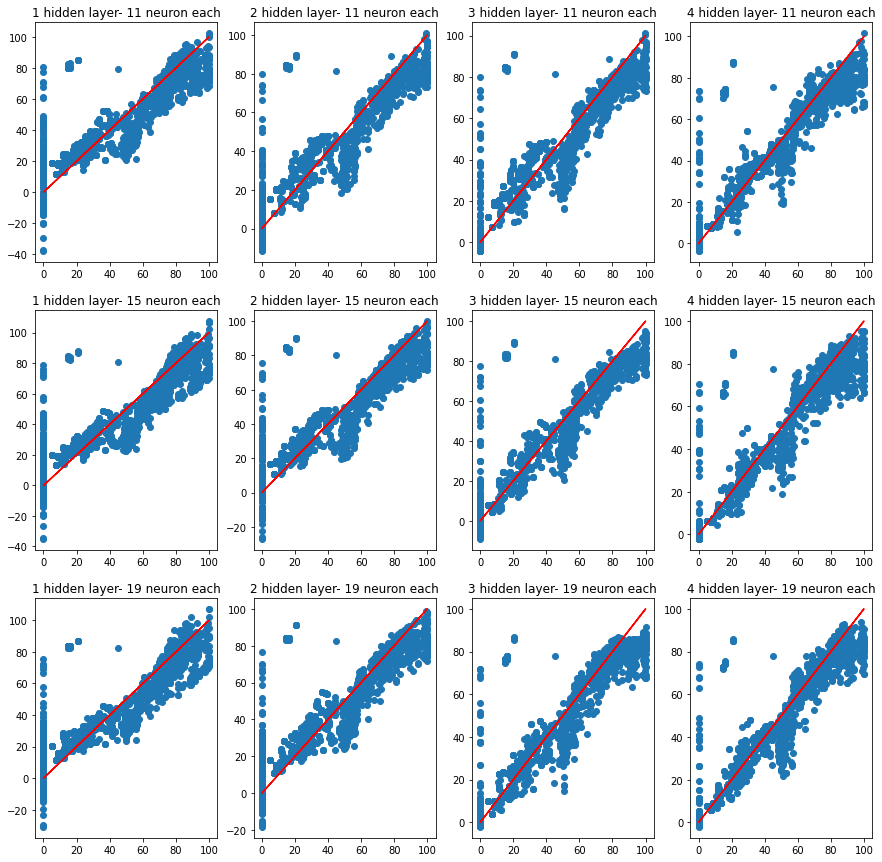

In [ ]:
f, ax = plt.subplots(3,4,figsize=(15,15))

ax=plt.subplot(3,4, 1)
plt.scatter(y_test,predictions_1)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('1 hidden layer- 11 neuron each')

ax=plt.subplot(3,4, 2)
plt.scatter(y_test,predictions_2)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('2 hidden layer- 11 neuron each')

ax=plt.subplot(3,4, 3)
plt.scatter(y_test,predictions_3)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('3 hidden layer- 11 neuron each')

ax=plt.subplot(3,4, 4)
plt.scatter(y_test,predictions_4)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('4 hidden layer- 11 neuron each')

############

ax=plt.subplot(3,4, 5)
plt.scatter(y_test,predictions_5)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('1 hidden layer- 15 neuron each')

ax=plt.subplot(3,4, 6)
plt.scatter(y_test,predictions_6)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('2 hidden layer- 15 neuron each')

ax=plt.subplot(3,4, 7)
plt.scatter(y_test,predictions_7)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('3 hidden layer- 15 neuron each')

ax=plt.subplot(3,4, 8)
plt.scatter(y_test,predictions_8)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('4 hidden layer- 15 neuron each')

###################

ax=plt.subplot(3,4, 9)
plt.scatter(y_test,predictions_9)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('1 hidden layer- 19 neuron each')

ax=plt.subplot(3,4, 10)
plt.scatter(y_test,predictions_10)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('2 hidden layer- 19 neuron each')

ax=plt.subplot(3,4, 11)
plt.scatter(y_test,predictions_11)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('3 hidden layer- 19 neuron each')

ax=plt.subplot(3,4, 12)
plt.scatter(y_test,predictions_12)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('4 hidden layer- 19 neuron each')

plt.show()

In [ ]:
MAE_3=[mean_absolute_error(y_test,predictions_1),mean_absolute_error(y_test,predictions_2),
     mean_absolute_error(y_test,predictions_3), mean_absolute_error(y_test,predictions_4),
     mean_absolute_error(y_test,predictions_5),mean_absolute_error(y_test,predictions_6),
     mean_absolute_error(y_test,predictions_7),mean_absolute_error(y_test,predictions_8),
     mean_absolute_error(y_test,predictions_9),mean_absolute_error(y_test,predictions_10),
     mean_absolute_error(y_test,predictions_11),mean_absolute_error(y_test,predictions_12)]

In [ ]:
np.sqrt(MAE_3)

array([3.42315773, 3.20812419, 3.06699182, 2.76245979, 3.44173115,
       3.26730527, 2.92734081, 2.77099772, 3.39327752, 3.1516594 ,
       2.83916352, 2.68649932])

In [ ]:
Berea_balanced_3['permPerc'].mean()

45.47935901671597

In [ ]:
Berea_balanced_3['permPerc'].median()

44.946323774999996

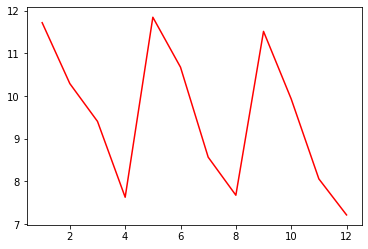

In [ ]:
plt.plot(range(1,13),MAE_3,'r')

It seems model 8 has a better accuracy (4 hidden layer,15 neuron each)

In [ ]:
len(Berea_balanced_3)

4600

In [ ]:
len(Berea_8)

14845

#LR

####import libraries

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

In [ ]:
from keras import backend as K


In [ ]:
X = Berea_balanced_4.drop(['poroPerc', 'permPerc'],axis=1) #n#TDfactor#threshold#deltaP#lambda#Re#Cu
y = Berea_balanced_4['permPerc']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train= scaler.fit_transform(X_train)

In [ ]:
X_test= scaler.transform(X_test)

##LR 0.00025

In [ ]:
deep19_model_7_LR00025 = Sequential()

deep19_model_7_LR00025.add(Dense(19,activation='relu'))
deep19_model_7_LR00025.add(Dense(19,activation='relu'))
deep19_model_7_LR00025.add(Dense(19,activation='relu'))
deep19_model_7_LR00025.add(Dense(19,activation='relu'))
deep19_model_7_LR00025.add(Dense(19,activation='relu'))
deep19_model_7_LR00025.add(Dense(19,activation='relu'))
deep19_model_7_LR00025.add(Dense(19,activation='relu'))
deep19_model_7_LR00025.add(Dense(1))

deep19_model_7_LR00025.compile(optimizer='adam',loss='mse')

In [ ]:
K.set_value(deep19_model_7_LR00025.optimizer.learning_rate, 0.00025)

In [ ]:
deep19_model_7_LR00025.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=800)

Epoch 1/800
26/26 [==============================] - 1s 10ms/step - loss: 2901.2498 - val_loss: 2913.0273
Epoch 2/800
26/26 [==============================] - 0s 4ms/step - loss: 2888.9854 - val_loss: 2896.3853
Epoch 3/800
26/26 [==============================] - 0s 4ms/step - loss: 2866.4666 - val_loss: 2865.0039
Epoch 4/800
26/26 [==============================] - 0s 4ms/step - loss: 2825.2195 - val_loss: 2809.0178
Epoch 5/800
26/26 [==============================] - 0s 4ms/step - loss: 2750.1716 - val_loss: 2704.1514
Epoch 6/800
26/26 [==============================] - 0s 4ms/step - loss: 2604.4048 - val_loss: 2499.9541
Epoch 7/800
26/26 [==============================] - 0s 4ms/step - loss: 2327.3735 - val_loss: 2125.5857
Epoch 8/800
26/26 [==============================] - 0s 4ms/step - loss: 1855.0485 - val_loss: 1549.2216
Epoch 9/800
26/26 [==============================] - 0s 4ms/step - loss: 1275.1837 - val_loss: 1070.4990
Epoch 10/800
26/26 [==============================] - 

In [ ]:
losses_LR00025 = pd.DataFrame(deep19_model_7_LR00025.history.history)

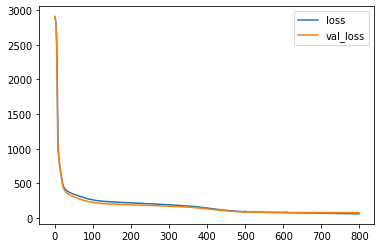

In [ ]:
losses_LR00025.plot()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


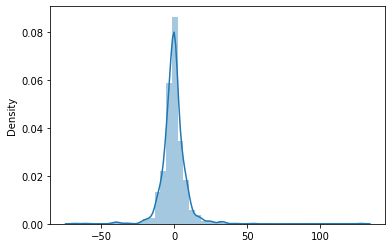

In [ ]:
predictions19_7_LR00025= deep19_model_7_LR00025.predict(X_test)
errors_last_LR00025= y_test.values.reshape(1380, 1) - predictions19_7_LR00025
sns.distplot(errors_last_LR00025)

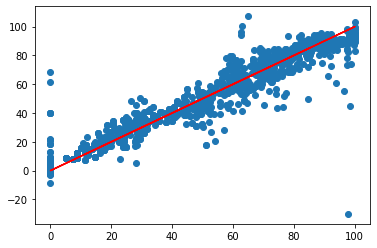

In [ ]:
# Our predictions
plt.scatter(y_test,predictions19_7_LR00025)

# Perfect predictions
plt.plot(y_test,y_test,'r')

##LR 0.0003

In [ ]:
deep19_model_7_LR0003 = Sequential()

deep19_model_7_LR0003.add(Dense(19,activation='relu'))
deep19_model_7_LR0003.add(Dense(19,activation='relu'))
deep19_model_7_LR0003.add(Dense(19,activation='relu'))
deep19_model_7_LR0003.add(Dense(19,activation='relu'))
deep19_model_7_LR0003.add(Dense(19,activation='relu'))
deep19_model_7_LR0003.add(Dense(19,activation='relu'))
deep19_model_7_LR0003.add(Dense(19,activation='relu'))
deep19_model_7_LR0003.add(Dense(1))

deep19_model_7_LR0003.compile(optimizer='adam',loss='mse')

In [ ]:
K.set_value(deep19_model_7_LR0003.optimizer.learning_rate, 0.0003)

In [ ]:
deep19_model_7_LR0003.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=800)

Epoch 1/800
26/26 [==============================] - 1s 10ms/step - loss: 2902.9861 - val_loss: 2914.4797
Epoch 2/800
26/26 [==============================] - 0s 4ms/step - loss: 2889.6755 - val_loss: 2895.5308
Epoch 3/800
26/26 [==============================] - 0s 4ms/step - loss: 2861.2075 - val_loss: 2851.4890
Epoch 4/800
26/26 [==============================] - 0s 4ms/step - loss: 2794.8176 - val_loss: 2748.6399
Epoch 5/800
26/26 [==============================] - 0s 5ms/step - loss: 2641.1348 - val_loss: 2522.8103
Epoch 6/800
26/26 [==============================] - 0s 4ms/step - loss: 2321.0923 - val_loss: 2071.0298
Epoch 7/800
26/26 [==============================] - 0s 5ms/step - loss: 1748.1810 - val_loss: 1390.3232
Epoch 8/800
26/26 [==============================] - 0s 4ms/step - loss: 1134.9817 - val_loss: 985.2666
Epoch 9/800
26/26 [==============================] - 0s 4ms/step - loss: 958.5510 - val_loss: 941.8278
Epoch 10/800
26/26 [==============================] - 0s 

In [ ]:
losses_LR0003 = pd.DataFrame(deep19_model_7_LR0003.history.history)

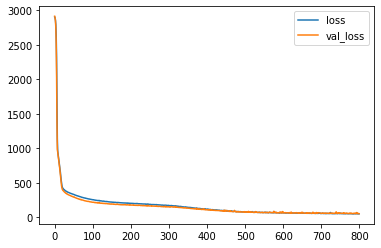

In [ ]:
losses_LR0003.plot()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


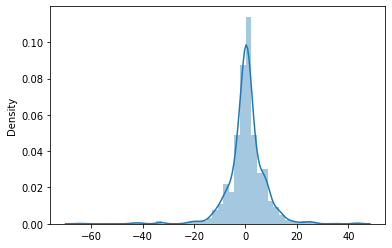

In [ ]:
predictions19_7_LR0003= deep19_model_7_LR0003.predict(X_test)
errors_last_LR0003= y_test.values.reshape(1380, 1) - predictions19_7_LR0003
sns.distplot(errors_last_LR0003)

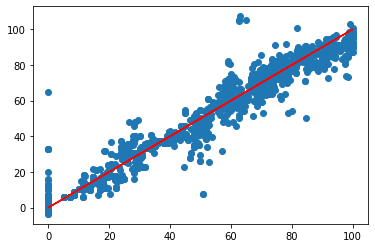

In [ ]:
# Our predictions
plt.scatter(y_test,predictions19_7_LR0003)

# Perfect predictions
plt.plot(y_test,y_test,'r')

##LR 0.00035

In [ ]:
deep19_model_7_LR00035 = Sequential()

deep19_model_7_LR00035.add(Dense(19,activation='relu'))
deep19_model_7_LR00035.add(Dense(19,activation='relu'))
deep19_model_7_LR00035.add(Dense(19,activation='relu'))
deep19_model_7_LR00035.add(Dense(19,activation='relu'))
deep19_model_7_LR00035.add(Dense(19,activation='relu'))
deep19_model_7_LR00035.add(Dense(19,activation='relu'))
deep19_model_7_LR00035.add(Dense(19,activation='relu'))
deep19_model_7_LR00035.add(Dense(1))

deep19_model_7_LR00035.compile(optimizer='adam',loss='mse')

In [ ]:
K.set_value(deep19_model_7_LR00035.optimizer.learning_rate, 0.00035)

In [ ]:
deep19_model_7_LR00035.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=800)

Epoch 1/800
26/26 [==============================] - 1s 10ms/step - loss: 2906.1360 - val_loss: 2919.4236
Epoch 2/800
26/26 [==============================] - 0s 4ms/step - loss: 2897.6675 - val_loss: 2907.8711
Epoch 3/800
26/26 [==============================] - 0s 4ms/step - loss: 2878.9910 - val_loss: 2876.3721
Epoch 4/800
26/26 [==============================] - 0s 5ms/step - loss: 2826.1648 - val_loss: 2786.7441
Epoch 5/800
26/26 [==============================] - 0s 5ms/step - loss: 2678.1487 - val_loss: 2547.1626
Epoch 6/800
26/26 [==============================] - 0s 4ms/step - loss: 2316.5352 - val_loss: 2002.5854
Epoch 7/800
26/26 [==============================] - 0s 5ms/step - loss: 1628.1354 - val_loss: 1200.0068
Epoch 8/800
26/26 [==============================] - 0s 5ms/step - loss: 999.9885 - val_loss: 931.7264
Epoch 9/800
26/26 [==============================] - 0s 5ms/step - loss: 899.7474 - val_loss: 877.2012
Epoch 10/800
26/26 [==============================] - 0s 4

In [ ]:
losses_LR00035 = pd.DataFrame(deep19_model_7_LR00035.history.history)

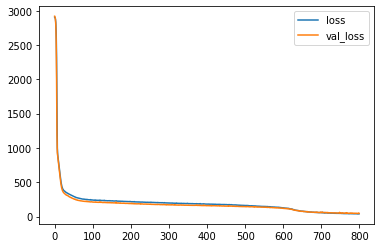

In [ ]:
losses_LR00035.plot()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


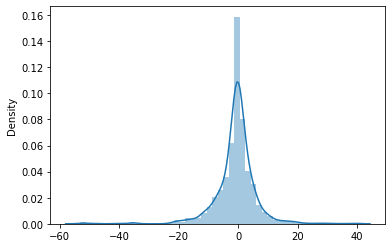

In [ ]:
predictions19_7_LR00035= deep19_model_7_LR00035.predict(X_test)
errors_last_LR00035= y_test.values.reshape(1380, 1) - predictions19_7_LR00035
sns.distplot(errors_last_LR00035)

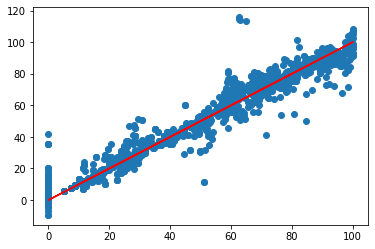

In [ ]:
# Our predictions
plt.scatter(y_test,predictions19_7_LR00035)

# Perfect predictions
plt.plot(y_test,y_test,'r')

##LR 0.0004

In [ ]:
deep19_model_7_LR0004 = Sequential()

deep19_model_7_LR0004.add(Dense(19,activation='relu'))
deep19_model_7_LR0004.add(Dense(19,activation='relu'))
deep19_model_7_LR0004.add(Dense(19,activation='relu'))
deep19_model_7_LR0004.add(Dense(19,activation='relu'))
deep19_model_7_LR0004.add(Dense(19,activation='relu'))
deep19_model_7_LR0004.add(Dense(19,activation='relu'))
deep19_model_7_LR0004.add(Dense(19,activation='relu'))
deep19_model_7_LR0004.add(Dense(1))

deep19_model_7_LR0004.compile(optimizer='adam',loss='mse')

In [ ]:
K.set_value(deep19_model_7_LR0004.optimizer.learning_rate, 0.0004)

In [ ]:
deep19_model_7_LR0004.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=800)

Epoch 1/800
26/26 [==============================] - 1s 10ms/step - loss: 2905.2156 - val_loss: 2918.1853
Epoch 2/800
26/26 [==============================] - 0s 4ms/step - loss: 2894.0403 - val_loss: 2900.3533
Epoch 3/800
26/26 [==============================] - 0s 4ms/step - loss: 2865.1978 - val_loss: 2852.5186
Epoch 4/800
26/26 [==============================] - 0s 4ms/step - loss: 2782.5220 - val_loss: 2712.3452
Epoch 5/800
26/26 [==============================] - 0s 4ms/step - loss: 2536.1567 - val_loss: 2296.7224
Epoch 6/800
26/26 [==============================] - 0s 3ms/step - loss: 1894.5917 - val_loss: 1397.4148
Epoch 7/800
26/26 [==============================] - 0s 4ms/step - loss: 1088.9314 - val_loss: 988.5389
Epoch 8/800
26/26 [==============================] - 0s 4ms/step - loss: 944.0194 - val_loss: 927.4235
Epoch 9/800
26/26 [==============================] - 0s 5ms/step - loss: 893.2304 - val_loss: 873.8344
Epoch 10/800
26/26 [==============================] - 0s 5m

In [ ]:
losses_LR0004 = pd.DataFrame(deep19_model_7_LR0004.history.history)

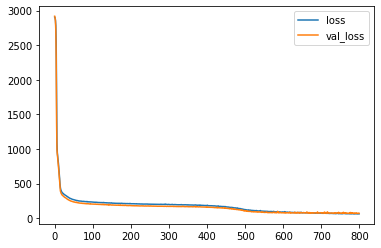

In [ ]:
losses_LR0004.plot()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


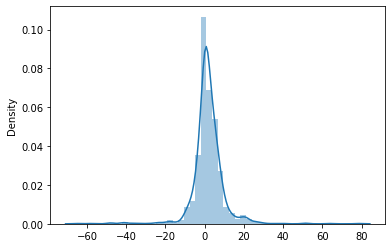

In [ ]:
predictions19_7_LR0004= deep19_model_7_LR0004.predict(X_test)
errors_last_LR0004= y_test.values.reshape(1380, 1) - predictions19_7_LR0004
sns.distplot(errors_last_LR0004)


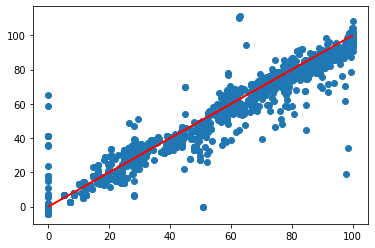

In [ ]:
# Our predictions
plt.scatter(y_test,predictions19_7_LR0004)

# Perfect predictions
plt.plot(y_test,y_test,'r')

##LR 0.00045

In [ ]:
deep19_model_7_LR00045 = Sequential()

deep19_model_7_LR00045.add(Dense(19,activation='relu'))
deep19_model_7_LR00045.add(Dense(19,activation='relu'))
deep19_model_7_LR00045.add(Dense(19,activation='relu'))
deep19_model_7_LR00045.add(Dense(19,activation='relu'))
deep19_model_7_LR00045.add(Dense(19,activation='relu'))
deep19_model_7_LR00045.add(Dense(19,activation='relu'))
deep19_model_7_LR00045.add(Dense(19,activation='relu'))
deep19_model_7_LR00045.add(Dense(1))

deep19_model_7_LR00045.compile(optimizer='adam',loss='mse')

In [ ]:
K.set_value(deep19_model_7_LR00045.optimizer.learning_rate, 0.00045)

In [ ]:
deep19_model_7_LR00045.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=800)

Epoch 1/800
26/26 [==============================] - 1s 10ms/step - loss: 2900.9688 - val_loss: 2910.2075
Epoch 2/800
26/26 [==============================] - 0s 4ms/step - loss: 2880.3000 - val_loss: 2873.8218
Epoch 3/800
26/26 [==============================] - 0s 5ms/step - loss: 2810.6926 - val_loss: 2746.5825
Epoch 4/800
26/26 [==============================] - 0s 4ms/step - loss: 2594.0293 - val_loss: 2380.2903
Epoch 5/800
26/26 [==============================] - 0s 4ms/step - loss: 2033.6238 - val_loss: 1568.8844
Epoch 6/800
26/26 [==============================] - 0s 4ms/step - loss: 1179.0763 - val_loss: 944.7626
Epoch 7/800
26/26 [==============================] - 0s 4ms/step - loss: 917.3654 - val_loss: 890.4207
Epoch 8/800
26/26 [==============================] - 0s 4ms/step - loss: 858.9998 - val_loss: 831.3168
Epoch 9/800
26/26 [==============================] - 0s 4ms/step - loss: 795.8612 - val_loss: 763.1203
Epoch 10/800
26/26 [==============================] - 0s 4ms/

In [ ]:
losses_LR00045 = pd.DataFrame(deep19_model_7_LR00045.history.history)

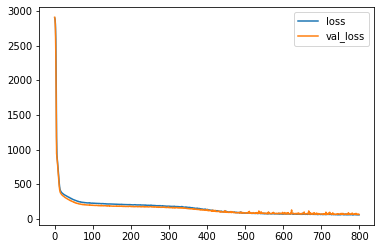

In [ ]:
losses_LR00045.plot()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


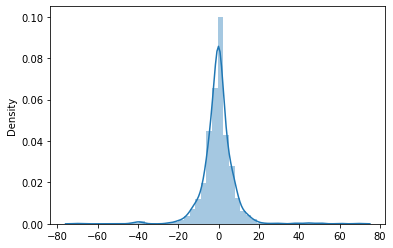

In [ ]:
predictions19_7_LR00045= deep19_model_7_LR00045.predict(X_test)
errors_last_LR00045= y_test.values.reshape(1380, 1) - predictions19_7_LR00045
sns.distplot(errors_last_LR00045)

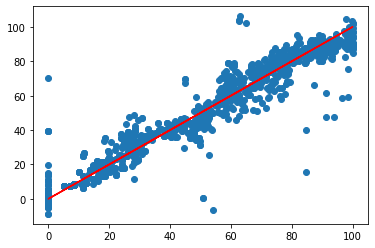

In [ ]:
# Our predictions
plt.scatter(y_test,predictions19_7_LR00045)

# Perfect predictions
plt.plot(y_test,y_test,'r')

##LR 0.0005

In [ ]:
deep19_model_7_LR0005 = Sequential()

deep19_model_7_LR0005.add(Dense(19,activation='relu'))
deep19_model_7_LR0005.add(Dense(19,activation='relu'))
deep19_model_7_LR0005.add(Dense(19,activation='relu'))
deep19_model_7_LR0005.add(Dense(19,activation='relu'))
deep19_model_7_LR0005.add(Dense(19,activation='relu'))
deep19_model_7_LR0005.add(Dense(19,activation='relu'))
deep19_model_7_LR0005.add(Dense(19,activation='relu'))
deep19_model_7_LR0005.add(Dense(1))

deep19_model_7_LR0005.compile(optimizer='adam',loss='mse')

In [ ]:
K.set_value(deep19_model_7_LR0005.optimizer.learning_rate, 0.0005)

In [ ]:
deep19_model_7_LR0005.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=800)

Epoch 1/800
26/26 [==============================] - 1s 9ms/step - loss: 2905.2810 - val_loss: 2917.2273
Epoch 2/800
26/26 [==============================] - 0s 3ms/step - loss: 2891.8403 - val_loss: 2894.3738
Epoch 3/800
26/26 [==============================] - 0s 4ms/step - loss: 2849.9265 - val_loss: 2822.0342
Epoch 4/800
26/26 [==============================] - 0s 4ms/step - loss: 2726.7693 - val_loss: 2612.5222
Epoch 5/800
26/26 [==============================] - 0s 4ms/step - loss: 2382.1541 - val_loss: 2052.9009
Epoch 6/800
26/26 [==============================] - 0s 4ms/step - loss: 1599.5327 - val_loss: 1089.5063
Epoch 7/800
26/26 [==============================] - 0s 4ms/step - loss: 904.9666 - val_loss: 863.1008
Epoch 8/800
26/26 [==============================] - 0s 4ms/step - loss: 834.5508 - val_loss: 820.0250
Epoch 9/800
26/26 [==============================] - 0s 4ms/step - loss: 799.9365 - val_loss: 788.0431
Epoch 10/800
26/26 [==============================] - 0s 4ms/

In [ ]:
losses_LR0005 = pd.DataFrame(deep19_model_7_LR0005.history.history)

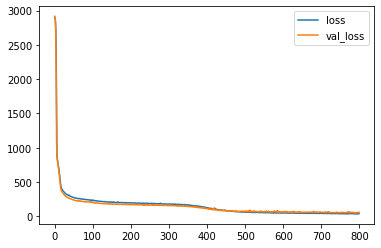

In [ ]:
losses_LR0005.plot()

In [ ]:
predictions19_7_LR0005= deep19_model_7_LR0005.predict(X_test)
errors_last_LR0005= y_test.values.reshape(1380, 1) - predictions19_7_LR0005
sns.distplot(errors_last_LR0005)

In [ ]:
# Our predictions
plt.scatter(y_test,predictions19_7_LR0005)

# Perfect predictions
plt.plot(y_test,y_test,'r')

##LR 0.0007

In [ ]:
deep19_model_7_LR0007 = Sequential()

deep19_model_7_LR0007.add(Dense(19,activation='relu'))
deep19_model_7_LR0007.add(Dense(19,activation='relu'))
deep19_model_7_LR0007.add(Dense(19,activation='relu'))
deep19_model_7_LR0007.add(Dense(19,activation='relu'))
deep19_model_7_LR0007.add(Dense(19,activation='relu'))
deep19_model_7_LR0007.add(Dense(19,activation='relu'))
deep19_model_7_LR0007.add(Dense(19,activation='relu'))
deep19_model_7_LR0007.add(Dense(1))

deep19_model_7_LR0007.compile(optimizer='adam',loss='mse')

In [ ]:
K.set_value(deep19_model_7_LR0007.optimizer.learning_rate, 0.007)

In [ ]:
deep19_model_7_LR0007.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=800)

Epoch 1/800
26/26 [==============================] - 1s 10ms/step - loss: 2427.2087 - val_loss: 1332.8892
Epoch 2/800
26/26 [==============================] - 0s 4ms/step - loss: 831.2223 - val_loss: 576.9659
Epoch 3/800
26/26 [==============================] - 0s 4ms/step - loss: 483.0020 - val_loss: 413.7514
Epoch 4/800
26/26 [==============================] - 0s 3ms/step - loss: 406.9445 - val_loss: 343.9206
Epoch 5/800
26/26 [==============================] - 0s 4ms/step - loss: 354.4585 - val_loss: 291.9696
Epoch 6/800
26/26 [==============================] - 0s 4ms/step - loss: 319.7806 - val_loss: 266.8536
Epoch 7/800
26/26 [==============================] - 0s 4ms/step - loss: 291.3227 - val_loss: 298.1176
Epoch 8/800
26/26 [==============================] - 0s 4ms/step - loss: 299.8860 - val_loss: 264.8030
Epoch 9/800
26/26 [==============================] - 0s 4ms/step - loss: 286.1049 - val_loss: 271.7448
Epoch 10/800
26/26 [==============================] - 0s 4ms/step - lo

In [ ]:
losses_LR0007 = pd.DataFrame(deep19_model_7_LR0007.history.history)

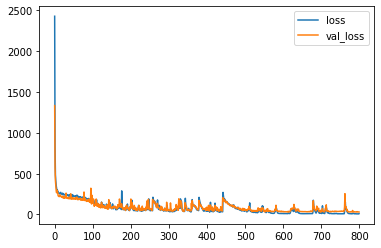

In [ ]:
losses_LR0007.plot()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


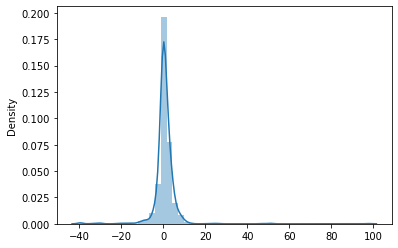

In [ ]:
predictions19_7_LR0007= deep19_model_7_LR0007.predict(X_test)
errors_last_LR0007= y_test.values.reshape(1380, 1) - predictions19_7_LR0007
sns.distplot(errors_last_LR0007)

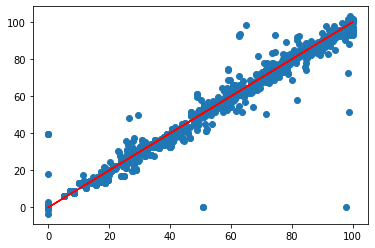

In [ ]:
# Our predictions
plt.scatter(y_test,predictions19_7_LR0007)

# Perfect predictions
plt.plot(y_test,y_test,'r')

##LR 0.001

In [ ]:
deep19_model_7_LR001 = Sequential()

deep19_model_7_LR001.add(Dense(19,activation='relu'))
deep19_model_7_LR001.add(Dense(19,activation='relu'))
deep19_model_7_LR001.add(Dense(19,activation='relu'))
deep19_model_7_LR001.add(Dense(19,activation='relu'))
deep19_model_7_LR001.add(Dense(19,activation='relu'))
deep19_model_7_LR001.add(Dense(19,activation='relu'))
deep19_model_7_LR001.add(Dense(19,activation='relu'))
deep19_model_7_LR001.add(Dense(1))

deep19_model_7_LR001.compile(optimizer='adam',loss='mse')

In [ ]:
K.set_value(deep19_model_7_LR001.optimizer.learning_rate, 0.001)

In [ ]:
deep19_model_7_LR001.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=800)

Epoch 1/800
26/26 [==============================] - 1s 9ms/step - loss: 2878.0464 - val_loss: 2838.9546
Epoch 2/800
26/26 [==============================] - 0s 4ms/step - loss: 2639.8835 - val_loss: 2239.7820
Epoch 3/800
26/26 [==============================] - 0s 5ms/step - loss: 1428.6029 - val_loss: 839.9467
Epoch 4/800
26/26 [==============================] - 0s 4ms/step - loss: 778.3216 - val_loss: 709.0031
Epoch 5/800
26/26 [==============================] - 0s 4ms/step - loss: 665.7706 - val_loss: 610.0909
Epoch 6/800
26/26 [==============================] - 0s 4ms/step - loss: 568.1976 - val_loss: 505.7029
Epoch 7/800
26/26 [==============================] - 0s 4ms/step - loss: 477.0432 - val_loss: 424.3700
Epoch 8/800
26/26 [==============================] - 0s 4ms/step - loss: 428.9863 - val_loss: 389.2507
Epoch 9/800
26/26 [==============================] - 0s 4ms/step - loss: 404.1821 - val_loss: 367.5746
Epoch 10/800
26/26 [==============================] - 0s 4ms/step - 

In [ ]:
losses_LR001 = pd.DataFrame(deep19_model_7_LR001.history.history)

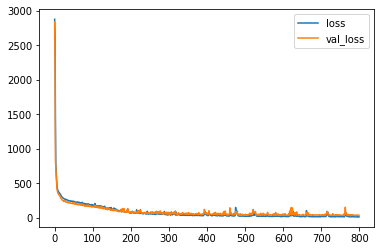

In [ ]:
losses_LR001.plot()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


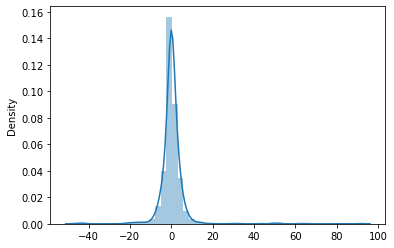

In [ ]:
predictions19_7_LR001 = deep19_model_7_LR001.predict(X_test)
errors_last_LR001 = y_test.values.reshape(1380, 1) - predictions19_7_LR001
sns.distplot(errors_last_LR001)

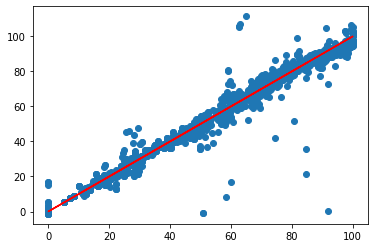

In [ ]:
# Our predictions
plt.scatter(y_test,predictions19_7_LR001)

# Perfect predictions
plt.plot(y_test,y_test,'r')

##LR 0.003

In [ ]:
deep19_model_7_LR003 = Sequential()

deep19_model_7_LR003.add(Dense(19,activation='relu'))
deep19_model_7_LR003.add(Dense(19,activation='relu'))
deep19_model_7_LR003.add(Dense(19,activation='relu'))
deep19_model_7_LR003.add(Dense(19,activation='relu'))
deep19_model_7_LR003.add(Dense(19,activation='relu'))
deep19_model_7_LR003.add(Dense(19,activation='relu'))
deep19_model_7_LR003.add(Dense(19,activation='relu'))
deep19_model_7_LR003.add(Dense(1))

deep19_model_7_LR003.compile(optimizer='adam',loss='mse')

In [ ]:
K.set_value(deep19_model_7_LR003.optimizer.learning_rate, 0.003)

In [ ]:
deep19_model_7_LR003.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=800)

Epoch 1/800
26/26 [==============================] - 1s 9ms/step - loss: 2867.4634 - val_loss: 2714.9277
Epoch 2/800
26/26 [==============================] - 0s 4ms/step - loss: 1793.4941 - val_loss: 961.8640
Epoch 3/800
26/26 [==============================] - 0s 4ms/step - loss: 865.4317 - val_loss: 731.5931
Epoch 4/800
26/26 [==============================] - 0s 4ms/step - loss: 644.0118 - val_loss: 537.4581
Epoch 5/800
26/26 [==============================] - 0s 4ms/step - loss: 490.4414 - val_loss: 413.2012
Epoch 6/800
26/26 [==============================] - 0s 5ms/step - loss: 431.5076 - val_loss: 372.4435
Epoch 7/800
26/26 [==============================] - 0s 5ms/step - loss: 396.8811 - val_loss: 349.3962
Epoch 8/800
26/26 [==============================] - 0s 4ms/step - loss: 373.7943 - val_loss: 331.2752
Epoch 9/800
26/26 [==============================] - 0s 4ms/step - loss: 357.9998 - val_loss: 310.2240
Epoch 10/800
26/26 [==============================] - 0s 5ms/step - lo

In [ ]:
losses_LR003 = pd.DataFrame(deep19_model_7_LR003.history.history)

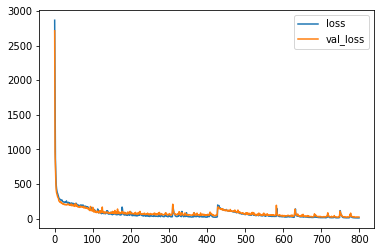

In [ ]:
losses_LR003.plot()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


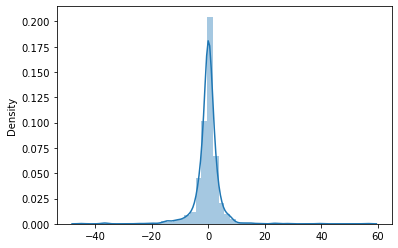

In [ ]:
predictions19_7_LR003= deep19_model_7_LR003.predict(X_test)
errors_last_LR003= y_test.values.reshape(1380, 1) - predictions19_7_LR003
sns.distplot(errors_last_LR003)

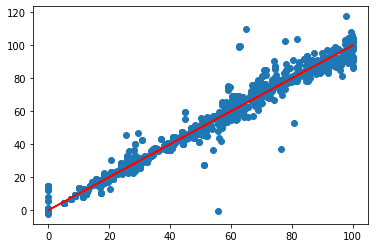

In [ ]:
# Our predictions
plt.scatter(y_test,predictions19_7_LR003)

# Perfect predictions
plt.plot(y_test,y_test,'r')

##LR 0.005

In [ ]:
deep19_model_7_LR005 = Sequential()

deep19_model_7_LR005.add(Dense(19,activation='relu'))
deep19_model_7_LR005.add(Dense(19,activation='relu'))
deep19_model_7_LR005.add(Dense(19,activation='relu'))
deep19_model_7_LR005.add(Dense(19,activation='relu'))
deep19_model_7_LR005.add(Dense(19,activation='relu'))
deep19_model_7_LR005.add(Dense(19,activation='relu'))
deep19_model_7_LR005.add(Dense(19,activation='relu'))
deep19_model_7_LR005.add(Dense(1))

deep19_model_7_LR005.compile(optimizer='adam',loss='mse')

In [ ]:
K.set_value(deep19_model_7_LR005.optimizer.learning_rate, 0.005)

In [ ]:
deep19_model_7_LR005.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=800)

Epoch 1/800
26/26 [==============================] - 1s 9ms/step - loss: 2314.6567 - val_loss: 1302.5309
Epoch 2/800
26/26 [==============================] - 0s 4ms/step - loss: 793.2361 - val_loss: 589.4156
Epoch 3/800
26/26 [==============================] - 0s 3ms/step - loss: 510.7392 - val_loss: 427.6818
Epoch 4/800
26/26 [==============================] - 0s 3ms/step - loss: 416.7489 - val_loss: 357.0082
Epoch 5/800
26/26 [==============================] - 0s 4ms/step - loss: 375.3530 - val_loss: 323.0155
Epoch 6/800
26/26 [==============================] - 0s 4ms/step - loss: 349.6296 - val_loss: 301.6751
Epoch 7/800
26/26 [==============================] - 0s 5ms/step - loss: 330.7265 - val_loss: 273.5878
Epoch 8/800
26/26 [==============================] - 0s 4ms/step - loss: 309.2479 - val_loss: 271.6606
Epoch 9/800
26/26 [==============================] - 0s 4ms/step - loss: 286.4427 - val_loss: 243.9302
Epoch 10/800
26/26 [==============================] - 0s 3ms/step - los

In [ ]:
losses_LR005 = pd.DataFrame(deep19_model_7_LR005.history.history)

In [ ]:
deep19_model_7_LR005.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f9ee9bce2d0>>

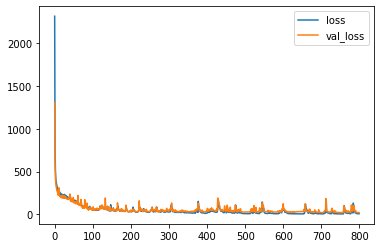

In [ ]:
losses_LR005.plot()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


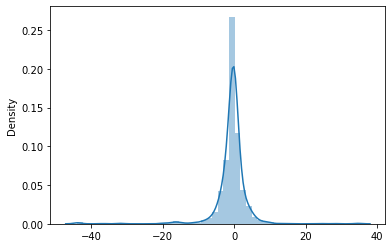

In [ ]:
predictions19_7_LR005= deep19_model_7_LR005.predict(X_test)
errors_last_LR005= y_test.values.reshape(1380, 1) - predictions19_7_LR005
sns.distplot(errors_last_LR005)

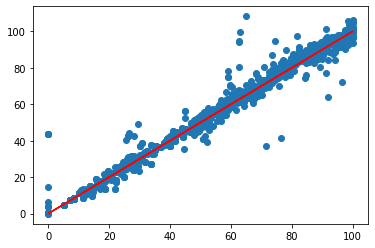

In [ ]:
# Our predictions
plt.scatter(y_test,predictions19_7_LR005)

# Perfect predictions
plt.plot(y_test,y_test,'r')

##LR 0.007

In [ ]:
deep19_model_7_LR007 = Sequential()

deep19_model_7_LR007.add(Dense(19,activation='relu'))
deep19_model_7_LR007.add(Dense(19,activation='relu'))
deep19_model_7_LR007.add(Dense(19,activation='relu'))
deep19_model_7_LR007.add(Dense(19,activation='relu'))
deep19_model_7_LR007.add(Dense(19,activation='relu'))
deep19_model_7_LR007.add(Dense(19,activation='relu'))
deep19_model_7_LR007.add(Dense(19,activation='relu'))
deep19_model_7_LR007.add(Dense(1))

deep19_model_7_LR007.compile(optimizer='adam',loss='mse')

In [ ]:
K.set_value(deep19_model_7_LR007.optimizer.learning_rate, 0.007)

In [ ]:
deep19_model_7_LR007.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=800)

Epoch 1/800
26/26 [==============================] - 1s 11ms/step - loss: 1765.9905 - val_loss: 979.7917
Epoch 2/800
26/26 [==============================] - 0s 3ms/step - loss: 692.8262 - val_loss: 499.7630
Epoch 3/800
26/26 [==============================] - 0s 4ms/step - loss: 445.6851 - val_loss: 368.2508
Epoch 4/800
26/26 [==============================] - 0s 4ms/step - loss: 377.9142 - val_loss: 322.9543
Epoch 5/800
26/26 [==============================] - 0s 4ms/step - loss: 343.2831 - val_loss: 298.3488
Epoch 6/800
26/26 [==============================] - 0s 4ms/step - loss: 322.9086 - val_loss: 270.2810
Epoch 7/800
26/26 [==============================] - 0s 6ms/step - loss: 292.7900 - val_loss: 258.4348
Epoch 8/800
26/26 [==============================] - 0s 5ms/step - loss: 276.6297 - val_loss: 231.8627
Epoch 9/800
26/26 [==============================] - 0s 4ms/step - loss: 264.3326 - val_loss: 230.7421
Epoch 10/800
26/26 [==============================] - 0s 5ms/step - los

In [ ]:
losses_LR007 = pd.DataFrame(deep19_model_7_LR007.history.history)

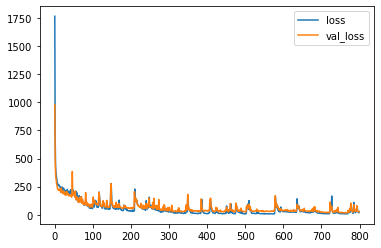

In [ ]:
losses_LR007.plot()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


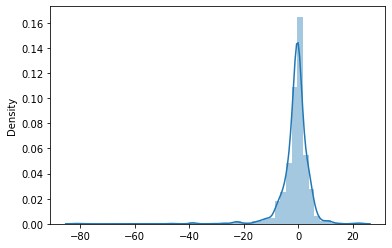

In [ ]:
predictions19_7_LR007= deep19_model_7_LR007.predict(X_test)
errors_last_LR007= y_test.values.reshape(1380, 1) - predictions19_7_LR007
sns.distplot(errors_last_LR007)

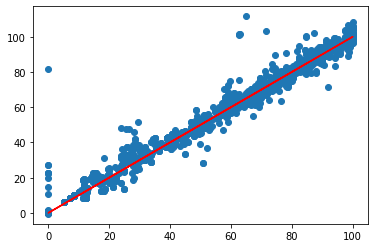

In [ ]:
# Our predictions
plt.scatter(y_test,predictions19_7_LR007)

# Perfect predictions
plt.plot(y_test,y_test,'r')

##LR 0.01

In [ ]:
deep19_model_7_LR01 = Sequential()

deep19_model_7_LR01.add(Dense(19,activation='relu'))
deep19_model_7_LR01.add(Dense(19,activation='relu'))
deep19_model_7_LR01.add(Dense(19,activation='relu'))
deep19_model_7_LR01.add(Dense(19,activation='relu'))
deep19_model_7_LR01.add(Dense(19,activation='relu'))
deep19_model_7_LR01.add(Dense(19,activation='relu'))
deep19_model_7_LR01.add(Dense(19,activation='relu'))
deep19_model_7_LR01.add(Dense(1))

deep19_model_7_LR01.compile(optimizer='adam',loss='mse')

In [ ]:
K.set_value(deep19_model_7_LR01.optimizer.learning_rate, 0.01)

In [ ]:
deep19_model_7_LR01.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=800)

Epoch 1/800
26/26 [==============================] - 1s 10ms/step - loss: 1798.2521 - val_loss: 761.8595
Epoch 2/800
26/26 [==============================] - 0s 4ms/step - loss: 599.3779 - val_loss: 451.5331
Epoch 3/800
26/26 [==============================] - 0s 4ms/step - loss: 436.5880 - val_loss: 372.7513
Epoch 4/800
26/26 [==============================] - 0s 4ms/step - loss: 407.1601 - val_loss: 354.5429
Epoch 5/800
26/26 [==============================] - 0s 4ms/step - loss: 381.1243 - val_loss: 334.5714
Epoch 6/800
26/26 [==============================] - 0s 4ms/step - loss: 372.0718 - val_loss: 313.3534
Epoch 7/800
26/26 [==============================] - 0s 4ms/step - loss: 340.5353 - val_loss: 289.5919
Epoch 8/800
26/26 [==============================] - 0s 4ms/step - loss: 310.5989 - val_loss: 253.3860
Epoch 9/800
26/26 [==============================] - 0s 4ms/step - loss: 287.3148 - val_loss: 249.0941
Epoch 10/800
26/26 [==============================] - 0s 3ms/step - los

In [ ]:
losses_LR01 = pd.DataFrame(deep19_model_7_LR01.history.history)

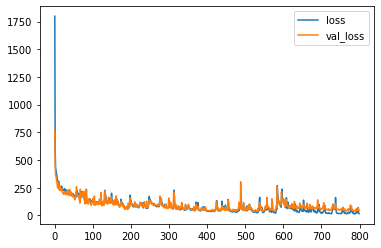

In [ ]:
losses_LR01.plot()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


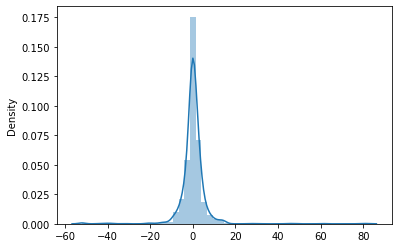

In [ ]:
predictions19_7_LR01 = deep19_model_7_LR01.predict(X_test)
errors_last_LR01= y_test.values.reshape(1380, 1) - predictions19_7_LR01
sns.distplot(errors_last_LR01)

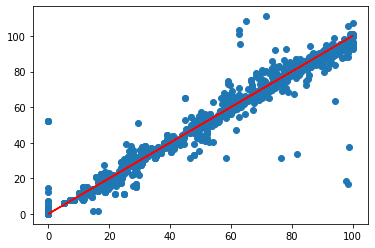

In [ ]:
# Our predictions
plt.scatter(y_test,predictions19_7_LR01)

# Perfect predictions
plt.plot(y_test,y_test,'r')

##results

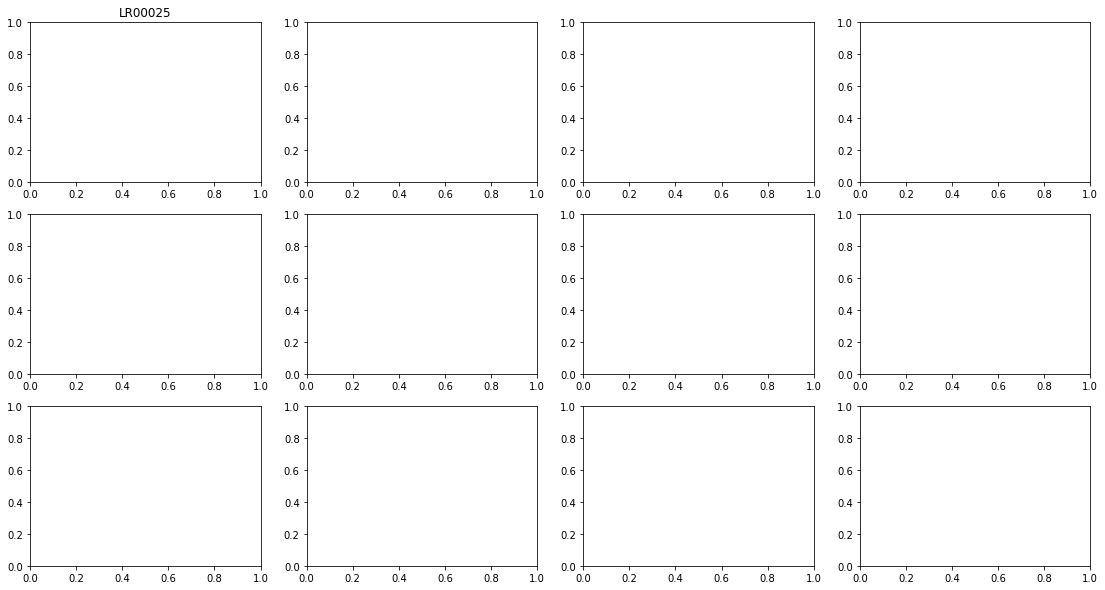

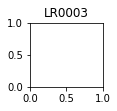

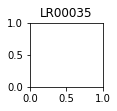

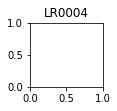

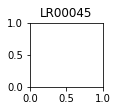

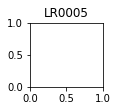

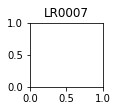

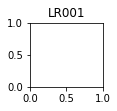

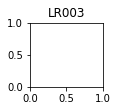

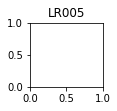

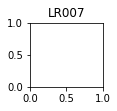

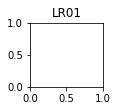

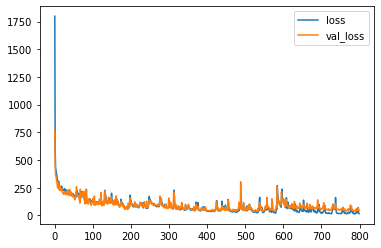

In [ ]:
f, ax = plt.subplots(3,4,figsize=(19,10))

ax=plt.subplot(3,4, 1)
cax=losses_LR00025.plot()
ax.set_title('LR00025')

ax=plt.subplot(3,4, 2)
cax=losses_LR0003.plot()
ax.set_title('LR0003')


ax=plt.subplot(3,4, 3)
losses_LR00035.plot()
ax.set_title('LR00035')

ax=plt.subplot(3,4, 4)
losses_LR0004.plot()
ax.set_title('LR0004')

############

ax=plt.subplot(3,4, 5)
losses_LR00045.plot()
ax.set_title('LR00045')

ax=plt.subplot(3,4, 6)
losses_LR0005.plot()
ax.set_title('LR0005')

ax=plt.subplot(3,4, 7)
losses_LR0007.plot()
ax.set_title('LR0007')

ax=plt.subplot(3,4, 8)
losses_LR001.plot()
ax.set_title('LR001')

###
ax=plt.subplot(3,4, 9)
losses_LR003.plot()
ax.set_title('LR003')

ax=plt.subplot(3,4, 10)
losses_LR005.plot()
ax.set_title('LR005')

ax=plt.subplot(3,4,11)
losses_LR007.plot()
ax.set_title('LR007')

ax=plt.subplot(3,4,12)
losses_LR01.plot()
ax.set_title('LR01')


plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

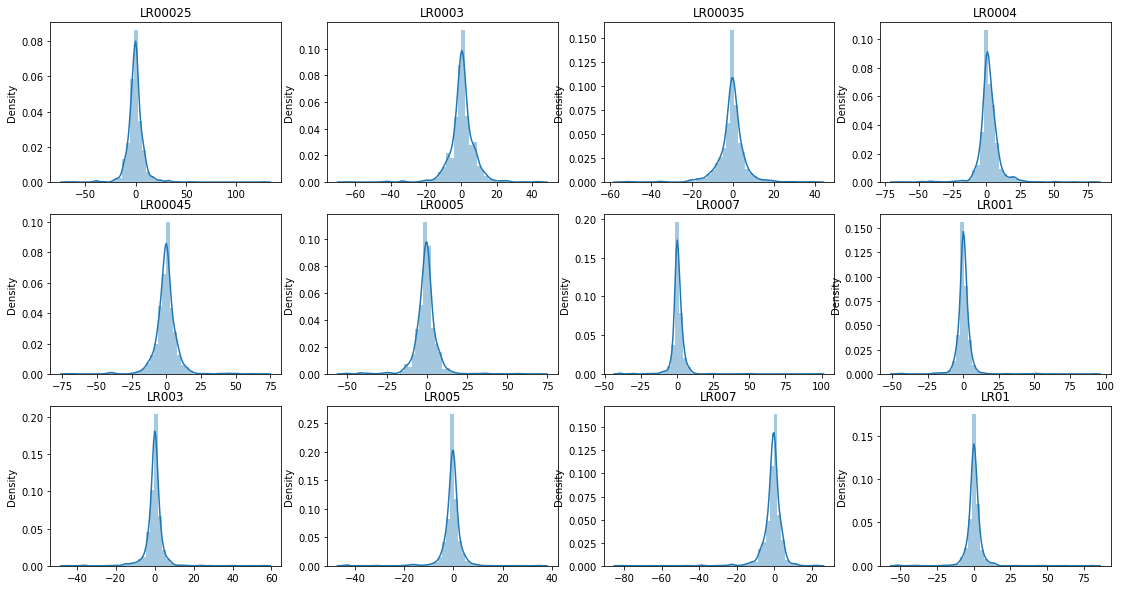

In [ ]:
f, ax = plt.subplots(3,4,figsize=(19,10))

ax=plt.subplot(3,4, 1)
sns.distplot(errors_last_LR00025)
ax.set_title('LR00025')

ax=plt.subplot(3,4, 2)
sns.distplot(errors_last_LR0003)
ax.set_title('LR0003')


ax=plt.subplot(3,4, 3)
sns.distplot(errors_last_LR00035)
ax.set_title('LR00035')

ax=plt.subplot(3,4, 4)
sns.distplot(errors_last_LR0004)
ax.set_title('LR0004')

############

ax=plt.subplot(3,4, 5)
sns.distplot(errors_last_LR00045)
ax.set_title('LR00045')

ax=plt.subplot(3,4, 6)
sns.distplot(errors_last_LR0005)
ax.set_title('LR0005')

ax=plt.subplot(3,4, 7)
sns.distplot(errors_last_LR0007)
ax.set_title('LR0007')

ax=plt.subplot(3,4, 8)
sns.distplot(errors_last_LR001)
ax.set_title('LR001')

###
ax=plt.subplot(3,4, 9)
sns.distplot(errors_last_LR003)
ax.set_title('LR003')

ax=plt.subplot(3,4, 10)
sns.distplot(errors_last_LR005)
ax.set_title('LR005')

ax=plt.subplot(3,4,11)
sns.distplot(errors_last_LR007)
ax.set_title('LR007')

ax=plt.subplot(3,4,12)
sns.distplot(errors_last_LR01)
ax.set_title('LR01')


plt.show()

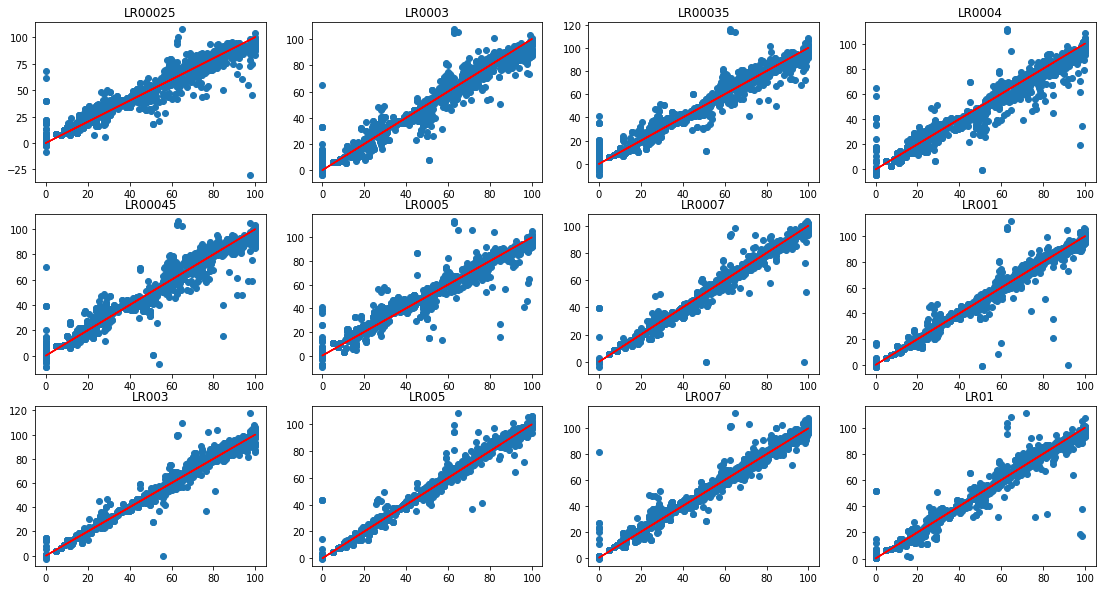

In [ ]:
f, ax = plt.subplots(3,4,figsize=(19,10))

ax=plt.subplot(3,4, 1)
plt.scatter(y_test,predictions19_7_LR00025)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('LR00025')

ax=plt.subplot(3,4, 2)
plt.scatter(y_test,predictions19_7_LR0003)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('LR0003')


ax=plt.subplot(3,4, 3)
plt.scatter(y_test,predictions19_7_LR00035)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('LR00035')

ax=plt.subplot(3,4, 4)
plt.scatter(y_test,predictions19_7_LR0004)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('LR0004')

############

ax=plt.subplot(3,4, 5)
plt.scatter(y_test,predictions19_7_LR00045)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('LR00045')

ax=plt.subplot(3,4, 6)
plt.scatter(y_test,predictions19_7_LR0005)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('LR0005')

ax=plt.subplot(3,4, 7)
plt.scatter(y_test,predictions19_7_LR0007)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('LR0007')

ax=plt.subplot(3,4, 8)
plt.scatter(y_test,predictions19_7_LR001)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('LR001')

###
ax=plt.subplot(3,4, 9)
plt.scatter(y_test,predictions19_7_LR003)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('LR003')

ax=plt.subplot(3,4, 10)
plt.scatter(y_test,predictions19_7_LR005)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('LR005')

ax=plt.subplot(3,4,11)
plt.scatter(y_test,predictions19_7_LR007)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('LR007')

ax=plt.subplot(3,4,12)
plt.scatter(y_test,predictions19_7_LR01)# Our predictions
cax=plt.plot(y_test,y_test,'r')# Perfect predictions
ax.set_title('LR01')


plt.show()

In [ ]:
MAE_LR=[mean_absolute_error(y_test,predictions19_7_LR00025),mean_absolute_error(y_test,predictions19_7_LR0003),mean_absolute_error(y_test,predictions19_7_LR00035),mean_absolute_error(y_test,predictions19_7_LR0004),mean_absolute_error(y_test,predictions19_7_LR00045),mean_absolute_error(y_test,predictions19_7_LR0005),mean_absolute_error(y_test,predictions19_7_LR0007),mean_absolute_error(y_test,predictions19_7_LR001),mean_absolute_error(y_test,predictions19_7_LR003),mean_absolute_error(y_test,predictions19_7_LR005),
     mean_absolute_error(y_test,predictions19_7_LR007), mean_absolute_error(y_test,predictions19_7_LR01)]

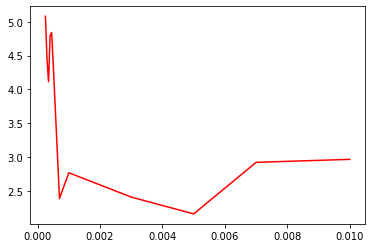

In [ ]:
plt.plot([0.00025,0.0003,0.00035,0.0004,0.00045,0.0005,0.0007,0.001,0.003,0.005,0.007,0.01],MAE_LR,'r')

In [ ]:
plt.scatter([0.0005,0.0007,0.001,0.003,0.005,0.007,0.01],MAE_LR)

In [ ]:
errors_last_7_LR01 = y_test.values.reshape(1482, 1) - predictions19_7_LR01
errors_last_7_LR007 = y_test.values.reshape(1482, 1) - predictions19_7_LR007
errors_last_7_LR005 = y_test.values.reshape(1482, 1) - predictions19_7_LR005
errors_last_7_LR003 = y_test.values.reshape(1482, 1) - predictions19_7_LR003
errors_last_7_LR001 = y_test.values.reshape(1482, 1) - predictions19_7_LR001
errors_last_7_LR0007 = y_test.values.reshape(1482, 1) - predictions19_7_LR0007
errors_last_7_LR0005 = y_test.values.reshape(1482, 1) - predictions19_7_LR0005


In [ ]:
f, ax = plt.subplots(3,4,figsize=(19,10))

ax=plt.subplot(3,4, 1)
sns.distplot(errors_last_7_LR0005)
ax.set_title('LR0005')

ax=plt.subplot(3,4, 2)
sns.distplot(errors_last_7_LR0007)
ax.set_title('LR0007')

ax=plt.subplot(3,4, 3)
sns.distplot(errors_last_7_LR001)
ax.set_title('LR001')

ax=plt.subplot(3,4, 4)
sns.distplot(errors_last_7_LR003)
ax.set_title('LR003')

############

ax=plt.subplot(3,4, 5)
sns.distplot(errors_last_7_LR005)
ax.set_title('LR005')

ax=plt.subplot(3,4, 6)
sns.distplot(errors_last_7_LR007)
ax.set_title('LR007')

ax=plt.subplot(3,4, 7)
sns.distplot(errors_last_7_LR01)
ax.set_title('LR01')

ax=plt.subplot(3,4, 8)
sns.distplot(errors_last_7_LR01)
ax.set_title('LR01')


plt.show()

#Reporting

In [ ]:
import tensorflow as tf
import datetime, os

In [ ]:
deep_model_12 = Sequential()

#number of neurons in hidden layer is assumed about 1.5 times of number of features
deep_model_12.add(Dense(19,activation='relu'))
deep_model_12.add(Dense(19,activation='relu'))
deep_model_12.add(Dense(19,activation='relu'))
deep_model_12.add(Dense(19,activation='relu'))
deep_model_12.add(Dense(1))

deep_model_12.compile(optimizer='adam',loss='mse')

In [ ]:
def train_model():

  ########
  deep19_model_7_LR005 = Sequential()

  deep19_model_7_LR005.add(Dense(19,activation='relu'))
  deep19_model_7_LR005.add(Dense(19,activation='relu'))
  deep19_model_7_LR005.add(Dense(19,activation='relu'))
  deep19_model_7_LR005.add(Dense(19,activation='relu'))
  deep19_model_7_LR005.add(Dense(19,activation='relu'))
  deep19_model_7_LR005.add(Dense(19,activation='relu'))
  deep19_model_7_LR005.add(Dense(19,activation='relu'))
  deep19_model_7_LR005.add(Dense(1))

  deep19_model_7_LR005.compile(optimizer='adam',loss='mse', metrics=['accuracy'])

  K.set_value(deep19_model_7_LR005.optimizer.learning_rate, 0.005)

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  deep19_model_7_LR005.fit(x=X_train,y=y_train.values,
            validation_data=(X_test,y_test.values),
            batch_size=128,epochs=800, callbacks=[tensorboard_callback])
		  


  ########
  
train_model()

In [ ]:
%load_ext tensorboard

In [ ]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

In [ ]:
print(deep19_model_7_LR005.summary())

#SHAP


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.2 MB/s 


In [ ]:
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

In [ ]:
explainer = shap.KernelExplainer(deep19_model_7_LR005.predict,X_train)

In [ ]:
test_pred=shap.sample(X_test, 1000)

In [ ]:
explainer = shap.KernelExplainer(deep19_model_7_LR005.predict,test_pred)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
shap_values = explainer.shap_values(test_pred,nsamples=100)

  0%|          | 0/1000 [00:00<?, ?it/s]

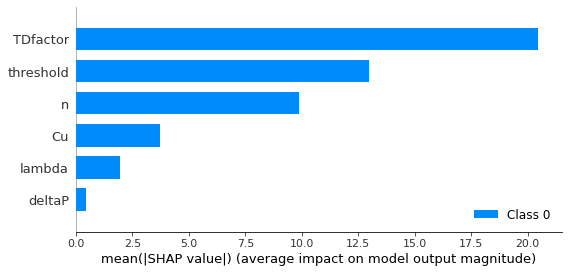

In [ ]:
shap.summary_plot(shap_values,test_pred,feature_names=X.columns)

In [ ]:
X.columns

In [ ]:
shap_va=np.array(shap_values)

In [ ]:
shap.initjs()
shap.plots.force(explainer.expected_value, shap_values[0])

The summary plot shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

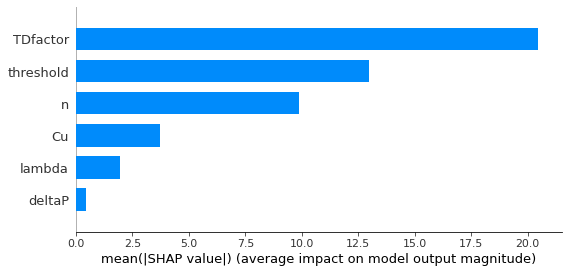

In [ ]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = X.columns)

The force plot is good to see where the “output value” fits in relation to the “base value”. We also see which features have a positive (red) or negative (blue) impact on the prediction and the magnitude of the impact.

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features = X.columns)

The waterfall plot also allows us to see the amplitude and the nature of the impact of a feature. It also allows seeing the order of importance of the features and the values taken by each feature for the sample.

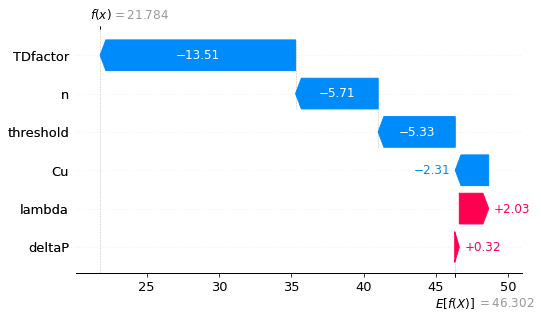

In [ ]:
shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0], feature_names = X.columns)

The decision plot makes it possible to observe the amplitude of each change, taken by a sample for the values of the displayed features.

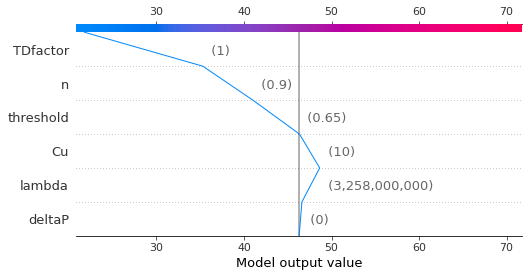

In [ ]:
shap.decision_plot(explainer.expected_value[0], shap_values[0][0], features = X.iloc[0,:], feature_names = X.columns.tolist())

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], test_pred, link="logit")

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1000 [00:00<?, ?it/s]

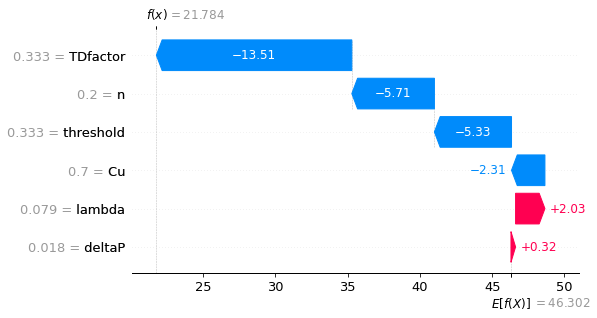

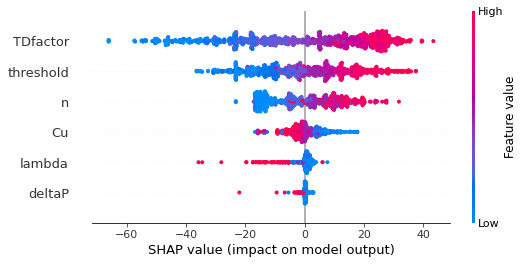

In [ ]:
keras_explainer = shap.KernelExplainer(deep19_model_7_LR005.predict, test_pred)
keras_shap_values = keras_explainer.shap_values(test_pred)

values = keras_shap_values[0]
base_values = [keras_explainer.expected_value[0]]*len(keras_shap_values[0])

tmp = shap.Explanation(values = np.array(values, dtype=np.float32),
                       base_values = np.array(base_values, dtype=np.float32),
                       data=np.array(test_pred),
                       feature_names=X.columns)

shap.plots.waterfall(tmp[0])
shap.plots.beeswarm(tmp)

In [ ]:
X.columns


Index(['deltaP', 'Cu', 'n', 'lambda', 'TDfactor', 'threshold'], dtype='object')